# Código Completo Mejorado para Análisis Multimodal - PAD-UFES-20


## Índice de Secciones
- Importación de librerías y configuración inicial mejorada
- Carga y exploración inicial del dataset con visualizaciones avanzadas
- Preprocesamiento de datos clínicos con manejo robusto de valores faltantes
- Extracción de características de imágenes optimizada
- Creación del dataset multimodal con validación
- Reducción de dimensionalidad con PCA y análisis de varianza
- Selección de características con múltiples métodos
- División de datos con balance de clases (SMOTE + pesos)
- Entrenamiento de modelos individuales con búsqueda de hiperparámetros
- Implementación de Ensemble Learning con pesos automáticos
- Evaluación final con métricas avanzadas y visualizaciones
- Análisis de costo computacional y comparación
- Generación de reportes y guardado de resultados

## 1. Importación de librerías y configuración inicial mejorada


In [ ]:
# ===== IMPORTACIÓN DE LIBRERÍAS =====

# Librerías básicas
import pandas as pd
import numpy as np
import os
import warnings
import yaml
import pickle
import json
from datetime import datetime
import logging
warnings.filterwarnings('ignore')

# Librerías para procesamiento de imágenes
from skimage import io, color, feature, measure, filters, segmentation
from skimage.transform import resize
import cv2

# Librerías para preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Librerías para balance de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight

# Librerías para reducción de dimensionalidad y selección de características
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import (SelectKBest, f_classif, chi2, mutual_info_classif,
                                     RFECV, SelectFromModel, VarianceThreshold)

# Librerías para modelos de machine learning
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                   StratifiedKFold, cross_val_score, validation_curve)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, StackingClassifier,
                            GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Librerías para evaluación de modelos
from sklearn.metrics import (classification_report, accuracy_score,
                           confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, matthews_corrcoef, cohen_kappa_score)

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para medición de rendimiento
import time
import psutil
from memory_profiler import profile
import gc

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ===== CONFIGURACIÓN CENTRALIZADA =====

CONFIG = {
    'paths': {
        'metadata_file': "./data/metadata.csv",
        'images_folder': "./data/imagenes/",
        'output_folder': "./resultados/",
        'models_folder': "./modelos/",
        'plots_folder': "./graficos/"
    },
    
    'data_params': {
        'test_size': 0.25,
        'val_size': 0.15,
        'random_state': 42,
        'target_image_size': (224, 224)
    },
    
    'preprocessing': {
        'handle_missing_values': True,
        'missing_threshold': 0.5,  # Eliminar columnas con >50% valores faltantes
        'imputation_strategy': {
            'numeric': 'median',  # 'mean', 'median', 'knn'
            'categorical': 'most_frequent'  # 'most_frequent', 'constant'
        },
        'scaling_method': 'standard'  # 'standard', 'robust', 'minmax'
    },
    
    'feature_extraction': {
        'extract_color_features': True,
        'extract_texture_features': True,
        'extract_shape_features': True,
        'extract_statistical_features': True,
        'color_bins': 20,
        'glcm_distances': [1, 2, 3],
        'glcm_angles': [0, 45, 90, 135],
        'lbp_radius': 3,
        'lbp_n_points': 24
    },
    
    'dimensionality_reduction': {
        'apply_pca': True,
        'pca_variance_threshold': 0.95,
        'apply_feature_selection': True,
        'feature_selection_method': 'univariate',  # 'univariate', 'rfe', 'importance'
        'n_features_to_select': 50
    },
    
    'class_balance': {
        'apply_smote': True,
        'smote_method': 'SMOTE',  # 'SMOTE', 'ADASYN', 'BorderlineSMOTE'
        'smote_k_neighbors': 5,
        'use_class_weights': True,
        'undersampling': False
    },
    
    'model_params': {
        'cv_folds': 5,
        'n_jobs': -1,
        'max_iter': 1000,
        'scoring_metric': 'f1_weighted',
        'hyperparameter_search': 'randomized',  # 'grid', 'randomized'
        'n_iter_search': 100
    },
    
    'ensemble_params': {
        'voting_types': ['hard', 'soft'],
        'auto_weights': True,
        'stacking_final_estimator': 'logistic',  # 'logistic', 'gradient_boosting'
        'stacking_cv': 5
    },
    
    'evaluation': {
        'metrics': ['accuracy', 'precision', 'recall', 'f1', 'auc', 'kappa'],
        'plot_confusion_matrix': True,
        'plot_roc_curves': True,
        'plot_precision_recall': True,
        'save_predictions': True
    },
    
    'visualization': {
        'save_plots': True,
        'plot_format': 'png',
        'dpi': 300,
        'interactive_plots': True,
        'plot_style': 'seaborn-v0_8'
    },
    
    'logging': {
        'level': 'INFO',
        'save_logs': True,
        'log_file': './multimodal_analysis.log'
    }
}

# ===== FUNCIONES DE CONFIGURACIÓN =====

def create_directories(config):
    """Crea directorios necesarios para el proyecto"""
    directories = [
        config['paths']['output_folder'],
        config['paths']['models_folder'],
        config['paths']['plots_folder']
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    
    print("Directorios creados:")
    for directory in directories:
        print(f"  ✓ {directory}")

def setup_logging(config):
    """Configura el sistema de logging"""
    if config['logging']['save_logs']:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(config['logging']['log_file']),
                logging.StreamHandler()
            ]
        )
    else:
        logging.basicConfig(
            level=getattr(logging, config['logging']['level']),
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
    
    return logging.getLogger(__name__)

def save_config(config, filepath='config.yaml'):
    """Guarda la configuración en un archivo YAML"""
    with open(filepath, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, indent=2)
    print(f"Configuración guardada en: {filepath}")

def load_config(filepath='config.yaml'):
    """Carga la configuración desde un archivo YAML"""
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            loaded_config = yaml.safe_load(f)
        print(f"Configuración cargada desde: {filepath}")
        return loaded_config
    else:
        print("Archivo de configuración no encontrado. Usando configuración por defecto.")
        return CONFIG

def print_config_summary(config):
    """Imprime un resumen de la configuración"""
    print("="*60)
    print("RESUMEN DE CONFIGURACIÓN")
    print("="*60)
    
    print(f"📁 Archivos:")
    print(f"  Metadata: {config['paths']['metadata_file']}")
    print(f"  Imágenes: {config['paths']['images_folder']}")
    print(f"  Resultados: {config['paths']['output_folder']}")
    
    print(f"\n📊 División de datos:")
    print(f"  Test: {config['data_params']['test_size']*100:.1f}%")
    print(f"  Validación: {config['data_params']['val_size']*100:.1f}%")
    print(f"  Entrenamiento: {(1-config['data_params']['test_size']-config['data_params']['val_size'])*100:.1f}%")
    
    print(f"\n🔧 Preprocesamiento:")
    print(f"  Balance de clases: {'✓' if config['class_balance']['apply_smote'] else '✗'}")
    print(f"  PCA: {'✓' if config['dimensionality_reduction']['apply_pca'] else '✗'}")
    print(f"  Selección de características: {'✓' if config['dimensionality_reduction']['apply_feature_selection'] else '✗'}")
    
    print(f"\n🤖 Modelos:")
    print(f"  Validación cruzada: {config['model_params']['cv_folds']} folds")
    print(f"  Búsqueda de hiperparámetros: {config['model_params']['hyperparameter_search']}")
    print(f"  Métrica de evaluación: {config['model_params']['scoring_metric']}")

# ===== INICIALIZACIÓN =====

# Crear directorios
create_directories(CONFIG)

# Configurar logging
logger = setup_logging(CONFIG)

# Guardar configuración inicial
save_config(CONFIG)

# Mostrar resumen de configuración
print_config_summary(CONFIG)

print("\n" + "="*60)
print("INICIALIZACIÓN COMPLETADA")
print("="*60)
print(f"Fecha y hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Configuración guardada en: config.yaml")
print(f"Logs guardados en: {CONFIG['logging']['log_file']}")


Directorios creados:
  ✓ ./resultados/
  ✓ ./modelos/
  ✓ ./graficos/
Configuración guardada en: config.yaml
RESUMEN DE CONFIGURACIÓN
📁 Archivos:
  Metadata: ./data/metadata.csv
  Imágenes: ./data/imagenes/
  Resultados: ./resultados/

📊 División de datos:
  Test: 25.0%
  Validación: 15.0%
  Entrenamiento: 60.0%

🔧 Preprocesamiento:
  Balance de clases: ✓
  PCA: ✓
  Selección de características: ✓

🤖 Modelos:
  Validación cruzada: 5 folds
  Búsqueda de hiperparámetros: randomized
  Métrica de evaluación: f1_weighted

INICIALIZACIÓN COMPLETADA
Fecha y hora: 2025-06-30 00:15:04
Configuración guardada en: config.yaml
Logs guardados en: ./multimodal_analysis.log


## 2. Carga y exploración inicial del dataset con visualizaciones avanzadas


2025-06-30 00:15:08,461 - INFO - Iniciando carga del dataset
2025-06-30 00:15:08,502 - INFO - Dataset cargado exitosamente: (2298, 26)


CARGA Y EXPLORACIÓN DEL DATASET
✓ Dataset cargado: 2298 filas, 26 columnas

📋 Información básica del dataset:
  Forma: (2298, 26)
  Memoria utilizada: 2.14 MB
  Tipos de datos:
    object: 20 columnas
    float64: 3 columnas
    int64: 2 columnas
    bool: 1 columnas

📊 Análisis de columnas:
  Columnas disponibles: ['patient_id', 'lesion_id', 'smoke', 'drink', 'background_father', 'background_mother', 'age', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'region', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation', 'img_id', 'biopsed']
  Columnas ID: ['patient_id', 'lesion_id', 'img_id']
  Columna objetivo: diagnostic
  Columnas numéricas: ['age', 'fitspatrick', 'diameter_1', 'diameter_2']
  Columnas categóricas: ['smoke', 'drink', 'background_father', 'background_mother', 'pesticide', 'gender', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_sy

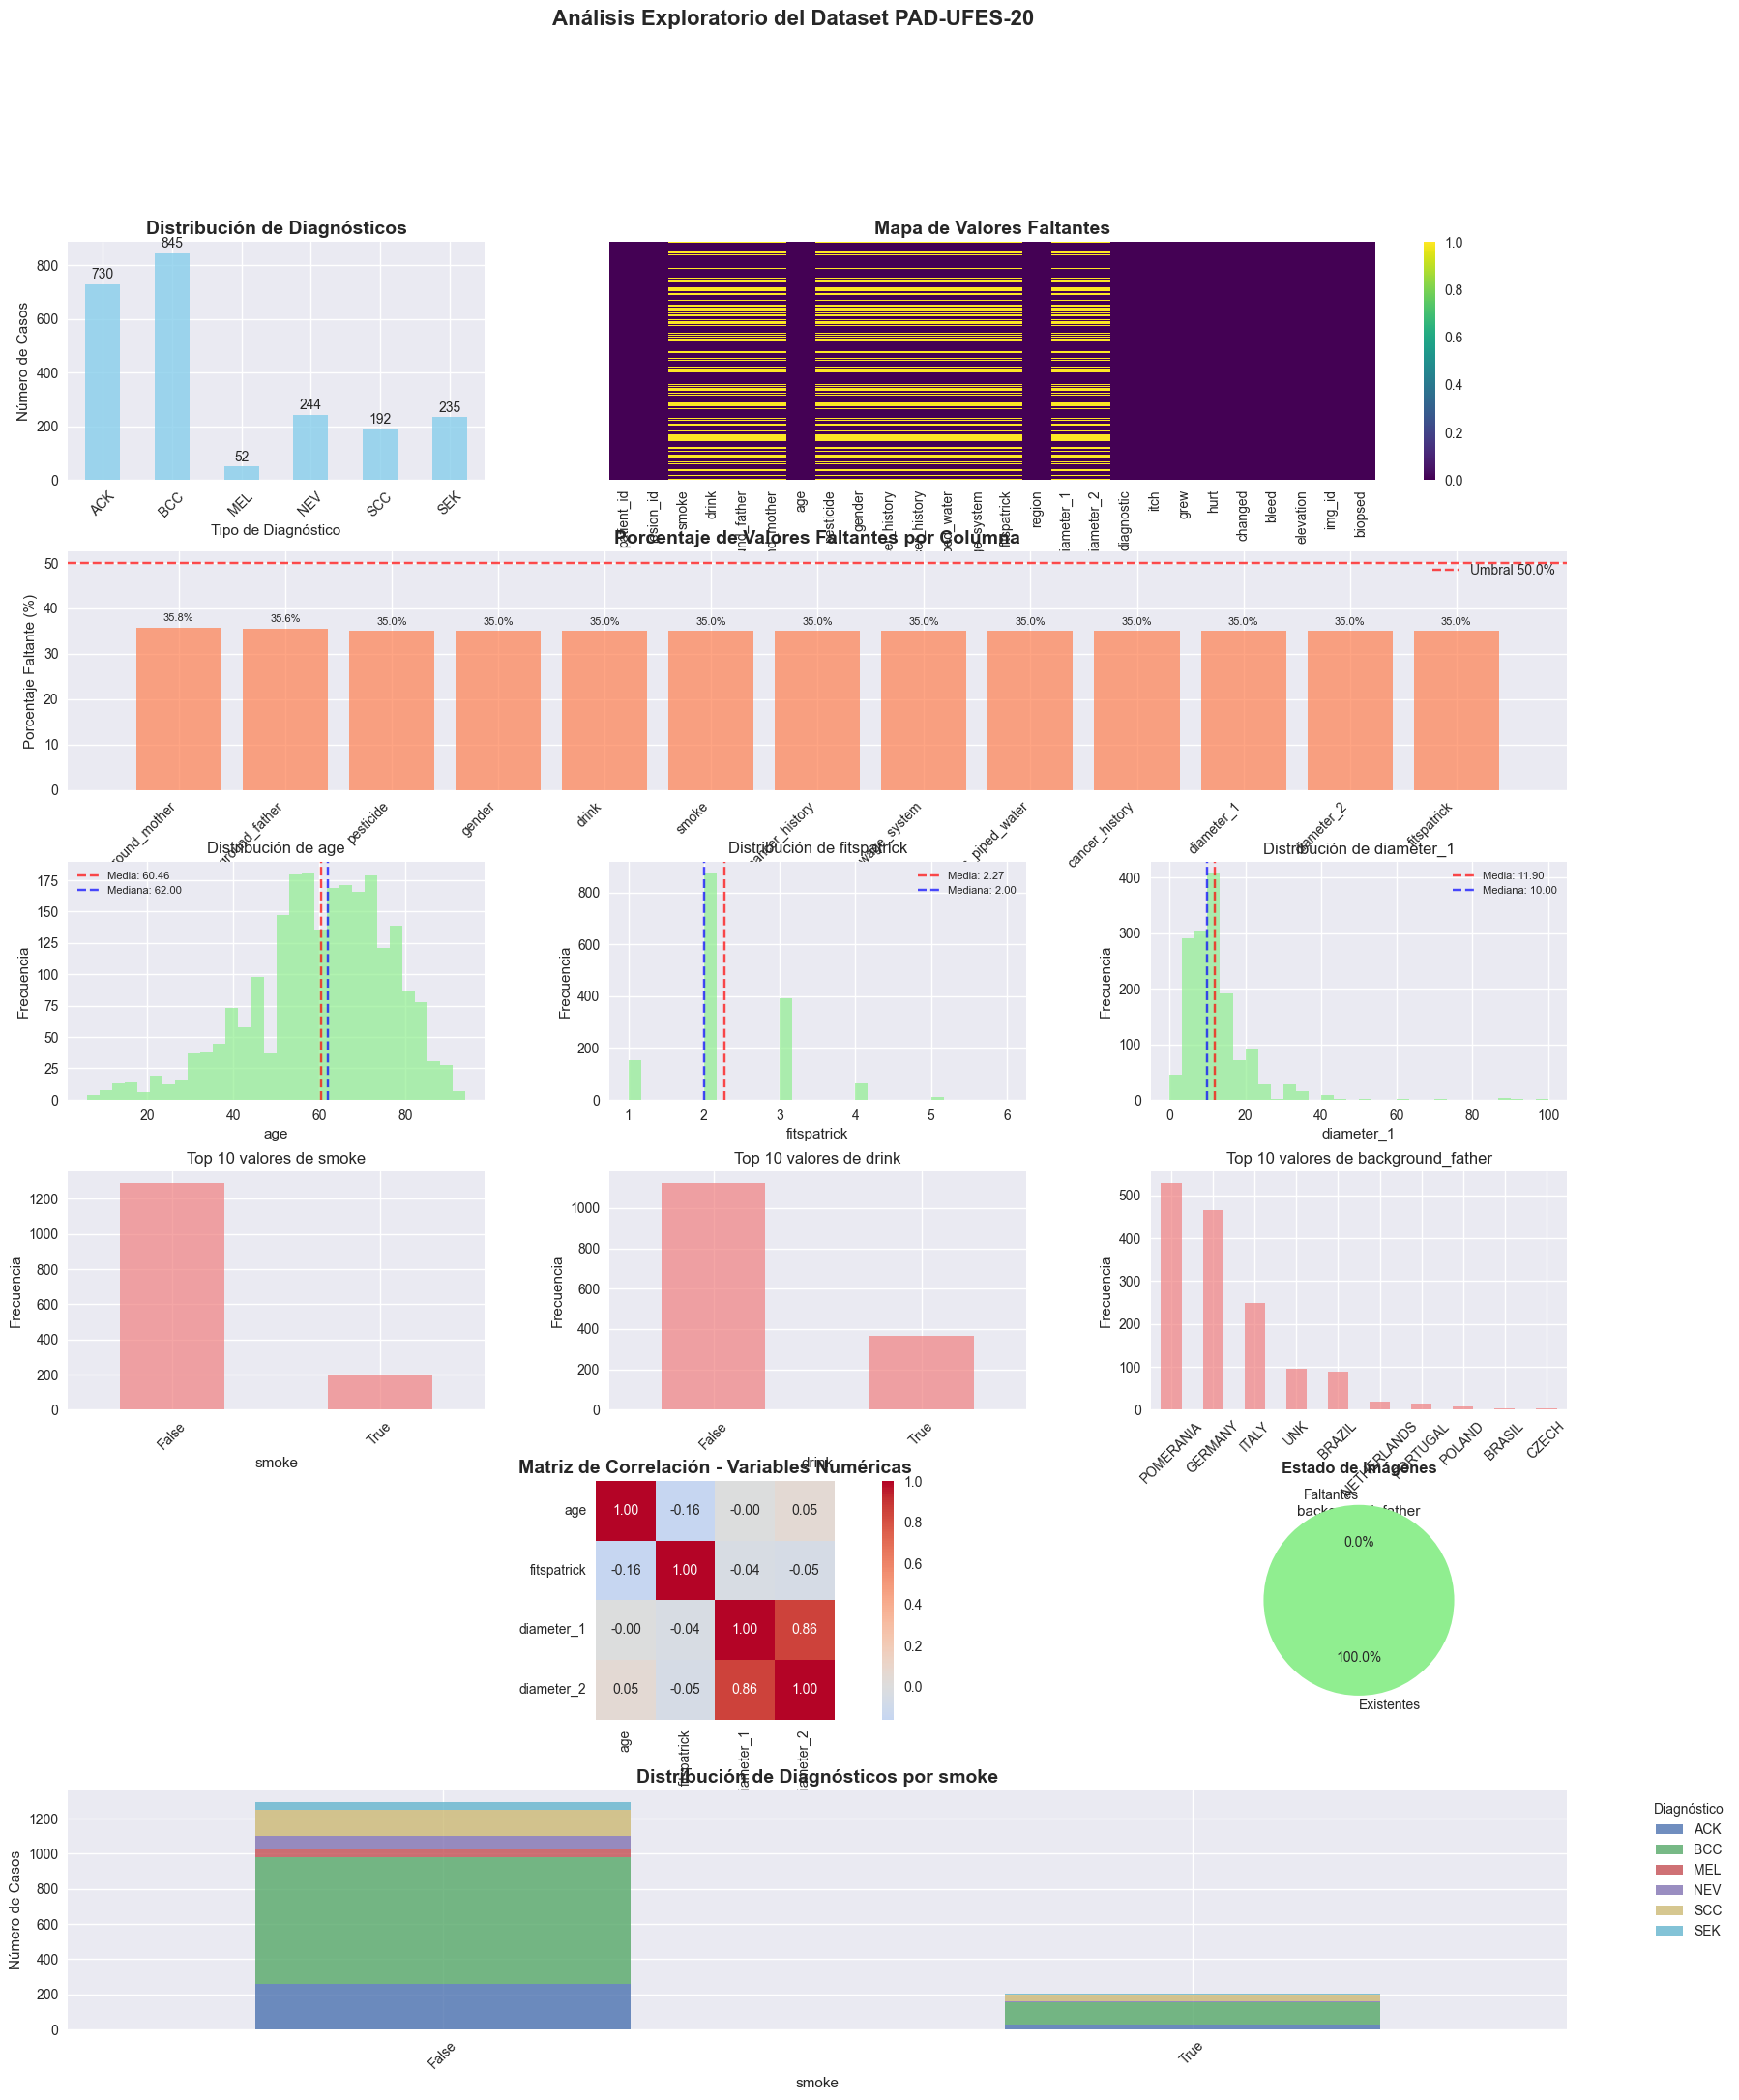


📊 Generando visualizaciones interactivas...
✓ Gráfico interactivo guardado en: ./graficos/interactive_class_distribution.html


2025-06-30 00:15:19,110 - INFO - Exploración del dataset completada exitosamente



✓ Resultados de exploración guardados en: ./resultados/exploration_results.json


In [3]:
def load_and_explore_dataset(config):
    """
    Carga y realiza exploración exhaustiva del dataset PAD-UFES-20
    
    Args:
        config: Configuración del proyecto
    
    Returns:
        df: DataFrame cargado
        exploration_results: Resultados de la exploración
    """
    
    print("="*60)
    print("CARGA Y EXPLORACIÓN DEL DATASET")
    print("="*60)
    
    logger.info("Iniciando carga del dataset")
    
    # ===== CARGA DEL DATASET =====
    try:
        df = pd.read_csv(config['paths']['metadata_file'])
        logger.info(f"Dataset cargado exitosamente: {df.shape}")
        print(f"✓ Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
    except Exception as e:
        logger.error(f"Error al cargar el dataset: {e}")
        raise
    
    # ===== INFORMACIÓN BÁSICA =====
    print(f"\n📋 Información básica del dataset:")
    print(f"  Forma: {df.shape}")
    print(f"  Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Tipos de datos:")
    for dtype in df.dtypes.value_counts().items():
        print(f"    {dtype[0]}: {dtype[1]} columnas")
    
    # ===== ANÁLISIS DE COLUMNAS =====
    print(f"\n📊 Análisis de columnas:")
    print(f"  Columnas disponibles: {list(df.columns)}")
    
    # Identificar tipos de columnas
    id_columns = ['patient_id', 'lesion_id', 'img_id']
    target_column = 'diagnostic'
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remover columnas de ID y target de las listas
    numeric_columns = [col for col in numeric_columns if col not in id_columns + [target_column]]
    categorical_columns = [col for col in categorical_columns if col not in id_columns + [target_column]]
    
    print(f"  Columnas ID: {id_columns}")
    print(f"  Columna objetivo: {target_column}")
    print(f"  Columnas numéricas: {numeric_columns}")
    print(f"  Columnas categóricas: {categorical_columns}")
    
    # ===== ANÁLISIS DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis de valores faltantes:")
    
    missing_analysis = pd.DataFrame({
        'Columna': df.columns,
        'Valores_Faltantes': df.isnull().sum(),
        'Porcentaje_Faltante': (df.isnull().sum() / len(df)) * 100,
        'Tipo_Dato': df.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis)
    
    # Identificar columnas con muchos valores faltantes
    high_missing_cols = missing_analysis[
        missing_analysis['Porcentaje_Faltante'] > config['preprocessing']['missing_threshold'] * 100
    ]['Columna'].tolist()
    
    if high_missing_cols:
        print(f"\n⚠️  Columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        for col in high_missing_cols:
            pct = missing_analysis[missing_analysis['Columna'] == col]['Porcentaje_Faltante'].iloc[0]
            print(f"    {col}: {pct:.1f}%")
    
    # ===== ANÁLISIS DE LA VARIABLE OBJETIVO =====
    print(f"\n🎯 Análisis de la variable objetivo '{target_column}':")
    
    target_analysis = df[target_column].value_counts().sort_index()
    target_percentages = (target_analysis / len(df)) * 100
    
    print("Distribución de clases:")
    for class_name, count in target_analysis.items():
        percentage = target_percentages[class_name]
        print(f"  {class_name}: {count} casos ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = target_analysis.max()
    min_class_size = target_analysis.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"\nMétricas de desbalance:")
    print(f"  Clase mayoritaria: {target_analysis.idxmax()} ({max_class_size} casos)")
    print(f"  Clase minoritaria: {target_analysis.idxmin()} ({min_class_size} casos)")
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 5:
        print("  ⚠️  Dataset significativamente desbalanceado (ratio > 5:1)")
    elif imbalance_ratio > 2:
        print("  ⚠️  Dataset moderadamente desbalanceado (ratio > 2:1)")
    else:
        print("  ✓ Dataset relativamente balanceado")
    
    # ===== ANÁLISIS ESTADÍSTICO DE VARIABLES NUMÉRICAS =====
    if numeric_columns:
        print(f"\n📈 Estadísticas descriptivas de variables numéricas:")
        numeric_stats = df[numeric_columns].describe()
        print(numeric_stats)
        
        # Detectar outliers usando IQR
        print(f"\n🔍 Detección de outliers (método IQR):")
        outlier_summary = {}
        for col in numeric_columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(df)) * 100
            
            outlier_summary[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            print(f"  {col}: {outlier_count} outliers ({outlier_percentage:.1f}%)")
    
    # ===== ANÁLISIS DE VARIABLES CATEGÓRICAS =====
    if categorical_columns:
        print(f"\n📊 Análisis de variables categóricas:")
        categorical_summary = {}
        
        for col in categorical_columns:
            unique_values = df[col].nunique()
            most_frequent = df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A'
            most_frequent_count = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
            most_frequent_pct = (most_frequent_count / len(df)) * 100
            
            categorical_summary[col] = {
                'unique_values': unique_values,
                'most_frequent': most_frequent,
                'most_frequent_count': most_frequent_count,
                'most_frequent_percentage': most_frequent_pct
            }
            
            print(f"  {col}:")
            print(f"    Valores únicos: {unique_values}")
            print(f"    Más frecuente: '{most_frequent}' ({most_frequent_count} casos, {most_frequent_pct:.1f}%)")
            
            # Mostrar distribución si hay pocos valores únicos
            if unique_values <= 10:
                value_counts = df[col].value_counts()
                print(f"    Distribución: {dict(value_counts)}")
    
    # ===== VERIFICACIÓN DE IMÁGENES =====
    print(f"\n🖼️  Verificación de imágenes:")
    
    if 'img_id' in df.columns:
        total_images_metadata = len(df)
        
        # Verificar cuántas imágenes existen físicamente
        images_folder = config['paths']['images_folder']
        if os.path.exists(images_folder):
            existing_images = []
            missing_images = []
            
            print("Verificando existencia de archivos de imagen...")
            for idx, img_id in enumerate(df['img_id']):
                img_path = os.path.join(images_folder, img_id)
                if os.path.exists(img_path):
                    existing_images.append(img_id)
                else:
                    missing_images.append(img_id)
                
                # Mostrar progreso cada 500 imágenes
                if (idx + 1) % 500 == 0:
                    print(f"  Verificadas: {idx + 1}/{total_images_metadata}")
            
            print(f"\nResultados de verificación:")
            print(f"  Imágenes en metadata: {total_images_metadata}")
            print(f"  Imágenes existentes: {len(existing_images)} ({len(existing_images)/total_images_metadata*100:.1f}%)")
            print(f"  Imágenes faltantes: {len(missing_images)} ({len(missing_images)/total_images_metadata*100:.1f}%)")
            
            if missing_images:
                print(f"  ⚠️  Primeras 5 imágenes faltantes: {missing_images[:5]}")
        else:
            print(f"  ⚠️  Carpeta de imágenes no encontrada: {images_folder}")
            existing_images = []
            missing_images = list(df['img_id'])
    else:
        print("  ⚠️  Columna 'img_id' no encontrada en el dataset")
        existing_images = []
        missing_images = []
    
    # ===== CREAR VISUALIZACIONES AVANZADAS =====
    print(f"\n📊 Generando visualizaciones...")
    
    # Configurar el estilo de las visualizaciones
    plt.style.use(config['visualization']['plot_style'])
    
    # Crear figura principal con múltiples subplots
    fig = plt.figure(figsize=(20, 24))
    gs = fig.add_gridspec(6, 3, hspace=0.3, wspace=0.3)
    
    # 1. Distribución de clases
    ax1 = fig.add_subplot(gs[0, 0])
    target_analysis.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('Distribución de Diagnósticos', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Diagnóstico')
    ax1.set_ylabel('Número de Casos')
    ax1.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for i, v in enumerate(target_analysis.values):
        ax1.text(i, v + max(target_analysis.values)*0.01, str(v), ha='center', va='bottom')
    
    # 2. Mapa de calor de valores faltantes
    ax2 = fig.add_subplot(gs[0, 1:])
    missing_matrix = df.isnull()
    sns.heatmap(missing_matrix, cbar=True, yticklabels=False, cmap='viridis', ax=ax2)
    ax2.set_title('Mapa de Valores Faltantes', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Columnas')
    
    # 3. Porcentaje de valores faltantes por columna
    ax3 = fig.add_subplot(gs[1, :])
    missing_pct = missing_analysis[missing_analysis['Porcentaje_Faltante'] > 0]
    if not missing_pct.empty:
        bars = ax3.bar(range(len(missing_pct)), missing_pct['Porcentaje_Faltante'], 
                      color='coral', alpha=0.7)
        ax3.set_title('Porcentaje de Valores Faltantes por Columna', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Columnas')
        ax3.set_ylabel('Porcentaje Faltante (%)')
        ax3.set_xticks(range(len(missing_pct)))
        ax3.set_xticklabels(missing_pct['Columna'], rotation=45, ha='right')
        
        # Línea de umbral
        ax3.axhline(y=config['preprocessing']['missing_threshold']*100, 
                   color='red', linestyle='--', alpha=0.7, 
                   label=f'Umbral {config["preprocessing"]["missing_threshold"]*100}%')
        ax3.legend()
        
        # Añadir etiquetas de valores
        for bar, value in zip(bars, missing_pct['Porcentaje_Faltante']):
            if value > 5:  # Solo mostrar etiquetas para valores > 5%
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # 4-6. Distribuciones de variables numéricas (si existen)
    if numeric_columns:
        for i, col in enumerate(numeric_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[2, i])
            df[col].hist(bins=30, ax=ax, alpha=0.7, color='lightgreen')
            ax.set_title(f'Distribución de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            
            # Añadir estadísticas
            mean_val = df[col].mean()
            median_val = df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_val:.2f}')
            ax.axvline(median_val, color='blue', linestyle='--', alpha=0.7, label=f'Mediana: {median_val:.2f}')
            ax.legend(fontsize=8)
    
    # 7-9. Distribuciones de variables categóricas (si existen)
    if categorical_columns:
        for i, col in enumerate(categorical_columns[:3]):  # Mostrar máximo 3 columnas
            ax = fig.add_subplot(gs[3, i])
            value_counts = df[col].value_counts().head(10)  # Top 10 valores
            value_counts.plot(kind='bar', ax=ax, color='lightcoral', alpha=0.7)
            ax.set_title(f'Top 10 valores de {col}', fontsize=12)
            ax.set_xlabel(col)
            ax.set_ylabel('Frecuencia')
            ax.tick_params(axis='x', rotation=45)
    
    # 10. Correlación entre variables numéricas
    if len(numeric_columns) > 1:
        ax10 = fig.add_subplot(gs[4, :2])
        correlation_matrix = df[numeric_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, ax=ax10, fmt='.2f')
        ax10.set_title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
    
    # 11. Resumen de verificación de imágenes
    ax11 = fig.add_subplot(gs[4, 2])
    if existing_images or missing_images:
        image_status = ['Existentes', 'Faltantes']
        image_counts = [len(existing_images), len(missing_images)]
        colors = ['lightgreen', 'lightcoral']
        
        wedges, texts, autotexts = ax11.pie(image_counts, labels=image_status, colors=colors, 
                                           autopct='%1.1f%%', startangle=90)
        ax11.set_title('Estado de Imágenes', fontsize=12, fontweight='bold')
    
    # 12. Distribución de clases por variable categórica (ejemplo con la primera)
    if categorical_columns and target_column in df.columns:
        ax12 = fig.add_subplot(gs[5, :])
        first_cat_col = categorical_columns[0]
        
        # Crear tabla cruzada
        crosstab = pd.crosstab(df[first_cat_col], df[target_column])
        crosstab_pct = pd.crosstab(df[first_cat_col], df[target_column], normalize='index') * 100
        
        # Gráfico de barras apiladas
        crosstab.plot(kind='bar', stacked=True, ax=ax12, alpha=0.8)
        ax12.set_title(f'Distribución de Diagnósticos por {first_cat_col}', fontsize=14, fontweight='bold')
        ax12.set_xlabel(first_cat_col)
        ax12.set_ylabel('Número de Casos')
        ax12.tick_params(axis='x', rotation=45)
        ax12.legend(title='Diagnóstico', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Guardar la figura
    plt.suptitle('Análisis Exploratorio del Dataset PAD-UFES-20', fontsize=16, fontweight='bold', y=0.98)
    
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'exploratory_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== CREAR VISUALIZACIONES INTERACTIVAS (PLOTLY) =====
    if config['visualization']['interactive_plots']:
        print(f"\n📊 Generando visualizaciones interactivas...")
        
        # Gráfico interactivo de distribución de clases
        fig_interactive = px.bar(
            x=target_analysis.index, 
            y=target_analysis.values,
            title='Distribución Interactiva de Diagnósticos',
            labels={'x': 'Tipo de Diagnóstico', 'y': 'Número de Casos'},
            color=target_analysis.values,
            color_continuous_scale='viridis'
        )
        
        fig_interactive.update_layout(
            showlegend=False,
            title_font_size=16,
            xaxis_title_font_size=14,
            yaxis_title_font_size=14
        )
        
        # Guardar gráfico interactivo
        if config['visualization']['save_plots']:
            interactive_path = os.path.join(config['paths']['plots_folder'], 
                                          'interactive_class_distribution.html')
            fig_interactive.write_html(interactive_path)
            print(f"✓ Gráfico interactivo guardado en: {interactive_path}")
        
        fig_interactive.show()
    
    # ===== COMPILAR RESULTADOS DE EXPLORACIÓN =====
    exploration_results = {
        'dataset_shape': df.shape,
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'column_types': {
            'id_columns': id_columns,
            'target_column': target_column,
            'numeric_columns': numeric_columns,
            'categorical_columns': categorical_columns
        },
        'missing_analysis': missing_analysis.to_dict('records'),
        'high_missing_columns': high_missing_cols,
        'target_analysis': {
            'distribution': target_analysis.to_dict(),
            'percentages': target_percentages.to_dict(),
            'imbalance_ratio': imbalance_ratio,
            'majority_class': target_analysis.idxmax(),
            'minority_class': target_analysis.idxmin()
        },
        'numeric_stats': numeric_stats.to_dict() if numeric_columns else {},
        'outlier_summary': outlier_summary if numeric_columns else {},
        'categorical_summary': categorical_summary if categorical_columns else {},
        'image_verification': {
            'total_in_metadata': len(df),
            'existing_images': len(existing_images),
            'missing_images': len(missing_images),
            'existing_percentage': len(existing_images) / len(df) * 100 if len(df) > 0 else 0
        }
    }
    
    # Guardar resultados de exploración
    exploration_path = os.path.join(config['paths']['output_folder'], 'exploration_results.json')
    with open(exploration_path, 'w') as f:
        json.dump(exploration_results, f, indent=2, default=str)
    
    print(f"\n✓ Resultados de exploración guardados en: {exploration_path}")
    
    logger.info("Exploración del dataset completada exitosamente")
    
    return df, exploration_results

# ===== EJECUTAR EXPLORACIÓN =====
df, exploration_results = load_and_explore_dataset(CONFIG)


## 3. Preprocesamiento de datos clínicos con manejo robusto de valores faltantes


2025-06-30 00:15:27,197 - INFO - Iniciando preprocesamiento de datos clínicos


PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS
📋 Información inicial:
  Filas: 2298
  Columnas totales: 26
  Columnas numéricas: 4
  Columnas categóricas: 17
  Columnas con muchos faltantes: 0

🎯 Separando características y etiquetas...
  Características clínicas: 22 columnas
  Muestras: 2298

🏷️  Codificando etiquetas...
  Mapeo de clases: {'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

🔍 Análisis detallado de valores faltantes en características:
                                 Columna  Valores_Faltantes  \
background_mother      background_mother                822   
background_father      background_father                818   
drink                              drink                804   
smoke                              smoke                804   
pesticide                      pesticide                804   
gender                            gender                804   
has_sewage_system      has_sewage_system                804   
skin_cancer_history  skin_cancer_

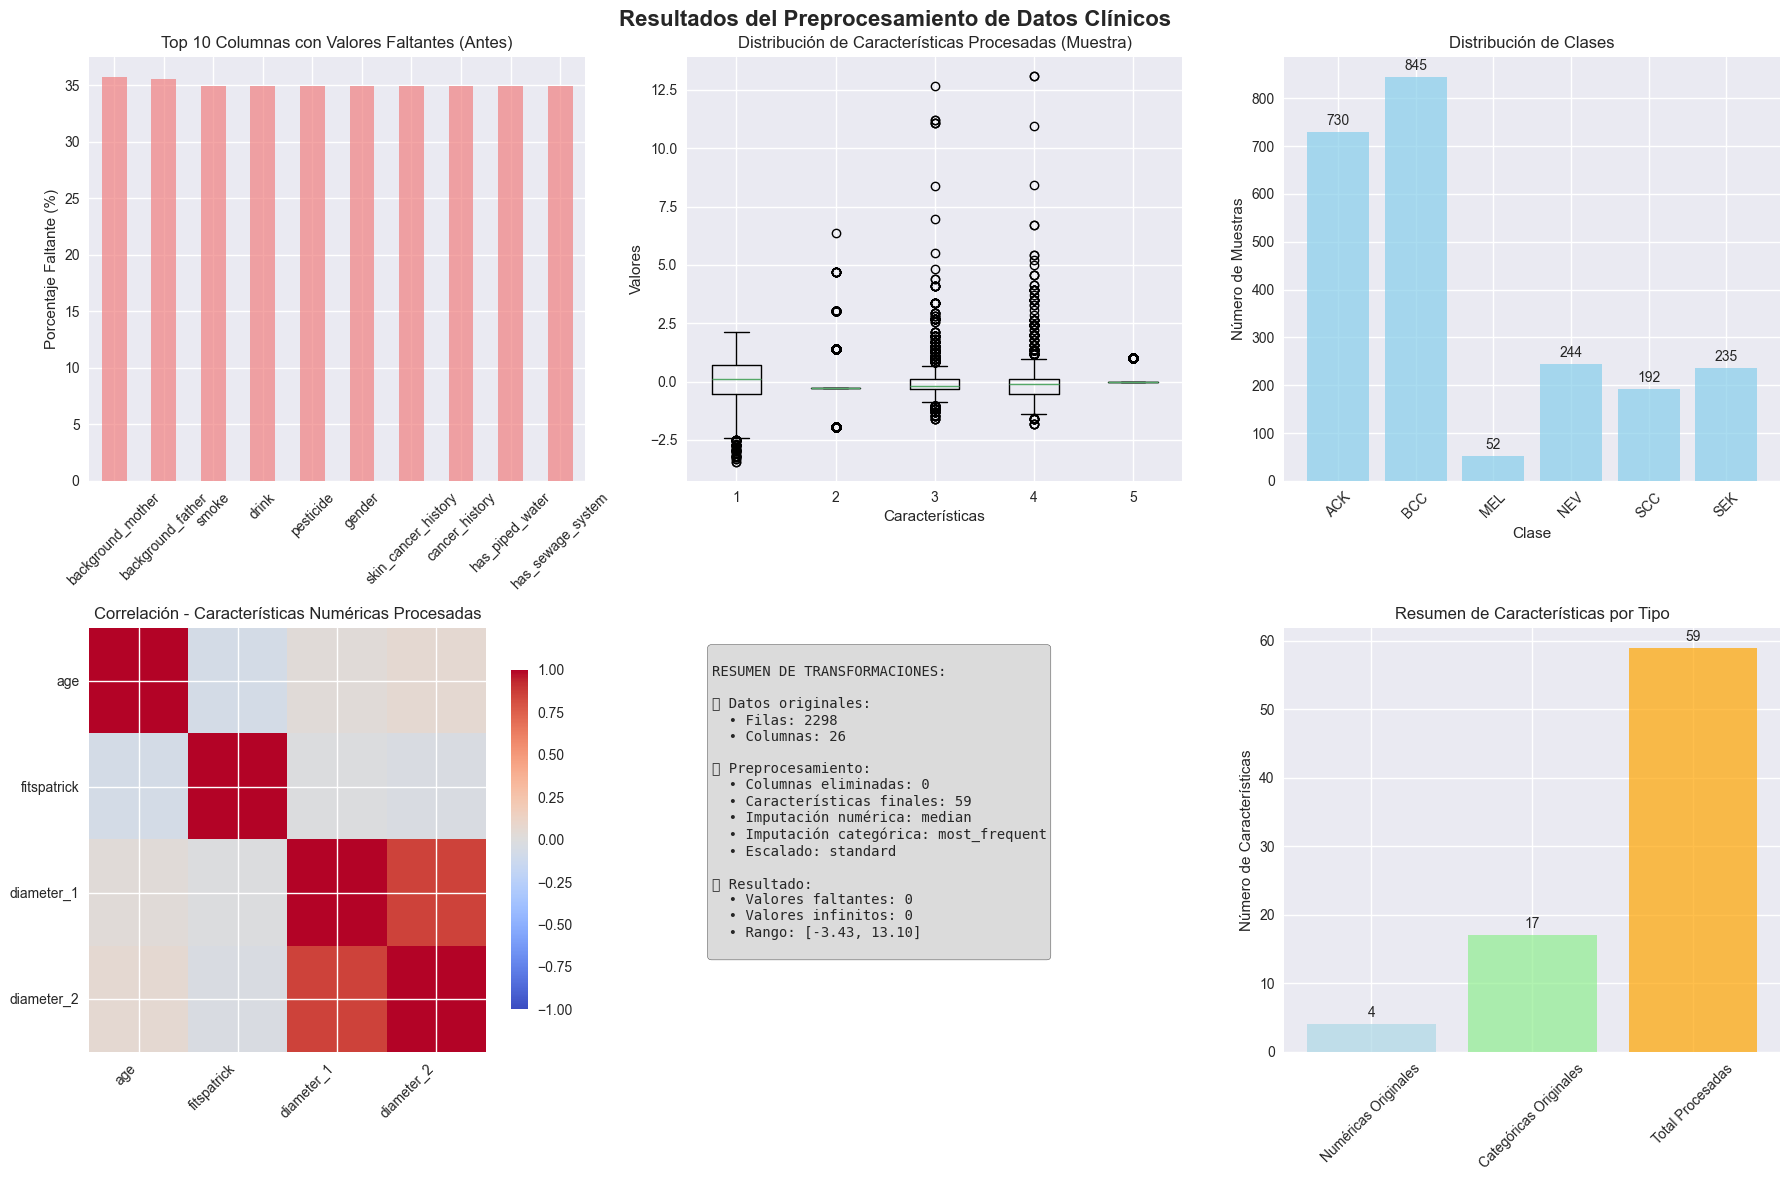

2025-06-30 00:15:29,239 - INFO - Preprocesamiento de datos clínicos completado exitosamente



✓ Resultados de preprocesamiento guardados en: ./resultados/preprocessing_results.pkl


In [4]:
def preprocess_clinical_data_robust(df, exploration_results, config):
    """
    Preprocesamiento robusto de datos clínicos con manejo avanzado de valores faltantes
    
    Args:
        df: DataFrame original
        exploration_results: Resultados de la exploración
        config: Configuración del proyecto
    
    Returns:
        preprocessing_results: Diccionario con datos procesados y metadatos
    """
    
    print("="*60)
    print("PREPROCESAMIENTO ROBUSTO DE DATOS CLÍNICOS")
    print("="*60)
    
    logger.info("Iniciando preprocesamiento de datos clínicos")
    
    # ===== PREPARACIÓN INICIAL =====
    df_processed = df.copy()
    
    # Obtener información de columnas desde exploration_results
    id_columns = exploration_results['column_types']['id_columns']
    target_column = exploration_results['column_types']['target_column']
    numeric_columns = exploration_results['column_types']['numeric_columns']
    categorical_columns = exploration_results['column_types']['categorical_columns']
    high_missing_columns = exploration_results['high_missing_columns']
    
    print(f"📋 Información inicial:")
    print(f"  Filas: {len(df_processed)}")
    print(f"  Columnas totales: {len(df_processed.columns)}")
    print(f"  Columnas numéricas: {len(numeric_columns)}")
    print(f"  Columnas categóricas: {len(categorical_columns)}")
    print(f"  Columnas con muchos faltantes: {len(high_missing_columns)}")
    
    # ===== MANEJO DE COLUMNAS CON MUCHOS VALORES FALTANTES =====
    columns_to_drop = []
    
    if high_missing_columns and config['preprocessing']['handle_missing_values']:
        print(f"\n🗑️  Evaluando columnas con >{config['preprocessing']['missing_threshold']*100}% valores faltantes:")
        
        for col in high_missing_columns:
            missing_pct = (df_processed[col].isnull().sum() / len(df_processed)) * 100
            print(f"  {col}: {missing_pct:.1f}% faltantes")
            
            # Decidir si eliminar la columna
            if missing_pct > config['preprocessing']['missing_threshold'] * 100:
                columns_to_drop.append(col)
                print(f"    → Marcada para eliminación")
            else:
                print(f"    → Conservada")
        
        if columns_to_drop:
            print(f"\n🗑️  Eliminando {len(columns_to_drop)} columnas:")
            for col in columns_to_drop:
                print(f"    - {col}")
            
            df_processed = df_processed.drop(columns=columns_to_drop)
            
            # Actualizar listas de columnas
            numeric_columns = [col for col in numeric_columns if col not in columns_to_drop]
            categorical_columns = [col for col in categorical_columns if col not in columns_to_drop]
    
    # ===== SEPARAR CARACTERÍSTICAS Y ETIQUETAS =====
    print(f"\n🎯 Separando características y etiquetas...")
    
    # Columnas a excluir de las características
    columns_to_exclude = id_columns + [target_column]
    feature_columns = [col for col in df_processed.columns if col not in columns_to_exclude]
    
    X_clinical = df_processed[feature_columns].copy()
    y_clinical = df_processed[target_column].copy()
    
    print(f"  Características clínicas: {X_clinical.shape[1]} columnas")
    print(f"  Muestras: {len(y_clinical)}")
    
    # ===== CODIFICACIÓN DE ETIQUETAS =====
    print(f"\n🏷️  Codificando etiquetas...")
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_clinical)
    
    class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    print(f"  Mapeo de clases: {class_mapping}")
    
    # ===== ANÁLISIS DETALLADO DE VALORES FALTANTES =====
    print(f"\n🔍 Análisis detallado de valores faltantes en características:")
    
    missing_analysis_features = pd.DataFrame({
        'Columna': X_clinical.columns,
        'Valores_Faltantes': X_clinical.isnull().sum(),
        'Porcentaje_Faltante': (X_clinical.isnull().sum() / len(X_clinical)) * 100,
        'Tipo_Dato': X_clinical.dtypes
    }).sort_values('Porcentaje_Faltante', ascending=False)
    
    print(missing_analysis_features[missing_analysis_features['Valores_Faltantes'] > 0])
    
    # ===== ESTRATEGIAS DE IMPUTACIÓN AVANZADAS =====
    print(f"\n🔧 Aplicando estrategias de imputación...")
    
    # Actualizar listas de columnas después de eliminar columnas
    numeric_features_final = [col for col in numeric_columns if col in X_clinical.columns]
    categorical_features_final = [col for col in categorical_columns if col in X_clinical.columns]
    
    print(f"  Columnas numéricas finales: {len(numeric_features_final)}")
    print(f"  Columnas categóricas finales: {len(categorical_features_final)}")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES NUMÉRICAS =====
    if numeric_features_final:
        print(f"\n📊 Configurando pipeline para variables numéricas...")
        
        # Seleccionar estrategia de imputación
        if config['preprocessing']['imputation_strategy']['numeric'] == 'knn':
            numeric_imputer = KNNImputer(n_neighbors=5)
            print(f"    Imputación: KNN (k=5)")
        else:
            numeric_imputer = SimpleImputer(strategy=config['preprocessing']['imputation_strategy']['numeric'])
            print(f"    Imputación: {config['preprocessing']['imputation_strategy']['numeric']}")
        
        # Seleccionar método de escalado
        if config['preprocessing']['scaling_method'] == 'robust':
            scaler = RobustScaler()
            print(f"    Escalado: Robust (resistente a outliers)")
        elif config['preprocessing']['scaling_method'] == 'minmax':
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            print(f"    Escalado: MinMax (0-1)")
        else:
            scaler = StandardScaler()
            print(f"    Escalado: Standard (z-score)")
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', numeric_imputer),
            ('scaler', scaler)
        ])
    else:
        numeric_transformer = None
        print(f"    No hay variables numéricas para procesar")
    
    # ===== PIPELINE DE PREPROCESAMIENTO PARA VARIABLES CATEGÓRICAS =====
    if categorical_features_final:
        print(f"\n📊 Configurando pipeline para variables categóricas...")
        
        categorical_imputer = SimpleImputer(
            strategy=config['preprocessing']['imputation_strategy']['categorical'],
            fill_value='desconocido' if config['preprocessing']['imputation_strategy']['categorical'] == 'constant' else None
        )
        
        print(f"    Imputación: {config['preprocessing']['imputation_strategy']['categorical']}")
        print(f"    Codificación: One-Hot Encoding")
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', categorical_imputer),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
        ])
    else:
        categorical_transformer = None
        print(f"    No hay variables categóricas para procesar")
    
    # ===== COMBINAR TRANSFORMADORES =====
    print(f"\n🔗 Combinando transformadores...")
    
    transformers = []
    if numeric_transformer is not None:
        transformers.append(('num', numeric_transformer, numeric_features_final))
    if categorical_transformer is not None:
        transformers.append(('cat', categorical_transformer, categorical_features_final))
    
    if transformers:
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Aplicar preprocesamiento
        print(f"    Aplicando transformaciones...")
        X_processed = preprocessor.fit_transform(X_clinical)
        
        print(f"    Forma después del preprocesamiento: {X_processed.shape}")
        
        # ===== OBTENER NOMBRES DE CARACTERÍSTICAS =====
        feature_names = []
        
        # Nombres de características numéricas
        if numeric_transformer is not None:
            feature_names.extend(numeric_features_final)
        
        # Nombres de características categóricas (después de one-hot encoding)
        if categorical_transformer is not None:
            try:
                # Para versiones más recientes de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_final)
            except AttributeError:
                # Para versiones más antiguas de sklearn
                cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names(categorical_features_final)
            
            feature_names.extend(cat_feature_names)
        
        print(f"    Características finales: {len(feature_names)}")
        
        # ===== VERIFICAR CALIDAD DEL PREPROCESAMIENTO =====
        print(f"\n✅ Verificación de calidad:")
        
        # Verificar que no hay valores faltantes
        if hasattr(X_processed, 'toarray'):  # Si es una matriz sparse
            X_processed_dense = X_processed.toarray()
        else:
            X_processed_dense = X_processed
        
        nan_count = np.isnan(X_processed_dense).sum()
        inf_count = np.isinf(X_processed_dense).sum()
        
        print(f"    Valores NaN después del preprocesamiento: {nan_count}")
        print(f"    Valores infinitos después del preprocesamiento: {inf_count}")
        
        if nan_count == 0 and inf_count == 0:
            print(f"    ✓ Preprocesamiento exitoso - No hay valores problemáticos")
        else:
            print(f"    ⚠️  Advertencia: Hay valores problemáticos después del preprocesamiento")
        
        # Estadísticas básicas
        print(f"    Rango de valores: [{X_processed_dense.min():.3f}, {X_processed_dense.max():.3f}]")
        print(f"    Media: {X_processed_dense.mean():.3f}")
        print(f"    Desviación estándar: {X_processed_dense.std():.3f}")
        
    else:
        raise ValueError("No hay características válidas para procesar")
    
    # ===== CREAR VISUALIZACIÓN DEL PREPROCESAMIENTO =====
    print(f"\n📊 Generando visualización del preprocesamiento...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Resultados del Preprocesamiento de Datos Clínicos', fontsize=16, fontweight='bold')
    
    # 1. Comparación de valores faltantes antes y después
    ax1 = axes[0, 0]
    missing_before = (df[feature_columns].isnull().sum() / len(df)) * 100
    missing_before = missing_before[missing_before > 0].sort_values(ascending=False)
    
    if len(missing_before) > 0:
        missing_before.head(10).plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
        ax1.set_title('Top 10 Columnas con Valores Faltantes (Antes)')
        ax1.set_ylabel('Porcentaje Faltante (%)')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, 'No hay valores faltantes', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Valores Faltantes (Antes)')
    
    # 2. Distribución de características después del preprocesamiento (muestra)
    ax2 = axes[0, 1]
    if X_processed.shape[1] > 0:
        # Mostrar distribución de las primeras 5 características
        sample_features = X_processed_dense[:, :min(5, X_processed.shape[1])]
        ax2.boxplot(sample_features)
        ax2.set_title('Distribución de Características Procesadas (Muestra)')
        ax2.set_xlabel('Características')
        ax2.set_ylabel('Valores')
    
    # 3. Distribución de clases
    ax3 = axes[0, 2]
    unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
    class_names = [label_encoder.classes_[i] for i in unique_classes]
    
    bars = ax3.bar(class_names, class_counts, color='skyblue', alpha=0.7)
    ax3.set_title('Distribución de Clases')
    ax3.set_xlabel('Clase')
    ax3.set_ylabel('Número de Muestras')
    ax3.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, class_counts):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 4. Matriz de correlación de características numéricas procesadas
    ax4 = axes[1, 0]
    if len(numeric_features_final) > 1:
        # Obtener solo las características numéricas procesadas
        num_features_processed = X_processed_dense[:, :len(numeric_features_final)]
        corr_matrix = np.corrcoef(num_features_processed.T)
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación - Características Numéricas Procesadas')
        ax4.set_xticks(range(len(numeric_features_final)))
        ax4.set_yticks(range(len(numeric_features_final)))
        ax4.set_xticklabels(numeric_features_final, rotation=45, ha='right')
        ax4.set_yticklabels(numeric_features_final)
        
        # Añadir colorbar
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\nnuméricas para correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación - Características Numéricas')
    
    # 5. Resumen de transformaciones aplicadas
    ax5 = axes[1, 1]
    ax5.axis('off')
    
    summary_text = f"""
RESUMEN DE TRANSFORMACIONES:

📊 Datos originales:
  • Filas: {len(df)}
  • Columnas: {len(df.columns)}

🔧 Preprocesamiento:
  • Columnas eliminadas: {len(columns_to_drop)}
  • Características finales: {X_processed.shape[1]}
  • Imputación numérica: {config['preprocessing']['imputation_strategy']['numeric']}
  • Imputación categórica: {config['preprocessing']['imputation_strategy']['categorical']}
  • Escalado: {config['preprocessing']['scaling_method']}

✅ Resultado:
  • Valores faltantes: {nan_count}
  • Valores infinitos: {inf_count}
  • Rango: [{X_processed_dense.min():.2f}, {X_processed_dense.max():.2f}]
    """
    
    ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # 6. Estadísticas de características por tipo
    ax6 = axes[1, 2]
    
    feature_type_counts = {
        'Numéricas Originales': len(numeric_features_final),
        'Categóricas Originales': len(categorical_features_final),
        'Total Procesadas': X_processed.shape[1]
    }
    
    bars = ax6.bar(feature_type_counts.keys(), feature_type_counts.values(), 
                  color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
    ax6.set_title('Resumen de Características por Tipo')
    ax6.set_ylabel('Número de Características')
    ax6.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts.values()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts.values())*0.01, 
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'preprocessing_results.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    preprocessing_results = {
        'X_processed': X_processed,
        'y_encoded': y_encoded,
        'feature_names': feature_names,
        'label_encoder': label_encoder,
        'preprocessor': preprocessor,
        'class_mapping': class_mapping,
        'processing_summary': {
            'original_shape': df.shape,
            'processed_shape': X_processed.shape,
            'columns_dropped': columns_to_drop,
            'numeric_features': numeric_features_final,
            'categorical_features': categorical_features_final,
            'nan_count_after': int(nan_count),
            'inf_count_after': int(inf_count),
            'value_range': [float(X_processed_dense.min()), float(X_processed_dense.max())],
            'mean_value': float(X_processed_dense.mean()),
            'std_value': float(X_processed_dense.std())
        }
    }
    
    # Guardar resultados de preprocesamiento
    preprocessing_path = os.path.join(config['paths']['output_folder'], 'preprocessing_results.pkl')
    with open(preprocessing_path, 'wb') as f:
        pickle.dump(preprocessing_results, f)
    
    print(f"\n✓ Resultados de preprocesamiento guardados en: {preprocessing_path}")
    
    logger.info("Preprocesamiento de datos clínicos completado exitosamente")
    
    return preprocessing_results

# ===== EJECUTAR PREPROCESAMIENTO =====
preprocessing_results = preprocess_clinical_data_robust(df, exploration_results, CONFIG)


## 4. Extracción de características de imágenes optimizada


2025-06-30 00:15:38,649 - INFO - Iniciando extracción de características de imágenes


EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES
📁 Carpeta de imágenes: ./data/imagenes/
📐 Tamaño objetivo: (224, 224)
🖼️  Total de imágenes en metadata: 2298

🔧 Configuración de extracción:
  Color: ✓
  Textura: ✓
  Forma: ✓
  Estadísticas: ✓

🔄 Iniciando extracción de características...
  Progreso: 4.4% | Procesadas: 100 | Errores: 0 | Tiempo restante: 32.9 min
  Progreso: 8.7% | Procesadas: 200 | Errores: 0 | Tiempo restante: 29.8 min
  Progreso: 13.1% | Procesadas: 300 | Errores: 0 | Tiempo restante: 27.8 min
  Progreso: 17.4% | Procesadas: 400 | Errores: 0 | Tiempo restante: 28.0 min
  Progreso: 21.8% | Procesadas: 500 | Errores: 0 | Tiempo restante: 27.4 min
  Progreso: 26.1% | Procesadas: 600 | Errores: 0 | Tiempo restante: 26.3 min
  Progreso: 30.5% | Procesadas: 700 | Errores: 0 | Tiempo restante: 25.1 min
  Progreso: 34.8% | Procesadas: 800 | Errores: 0 | Tiempo restante: 23.4 min
  Progreso: 39.2% | Procesadas: 900 | Errores: 0 | Tiempo restante: 21.7 min
  Progreso: 43.

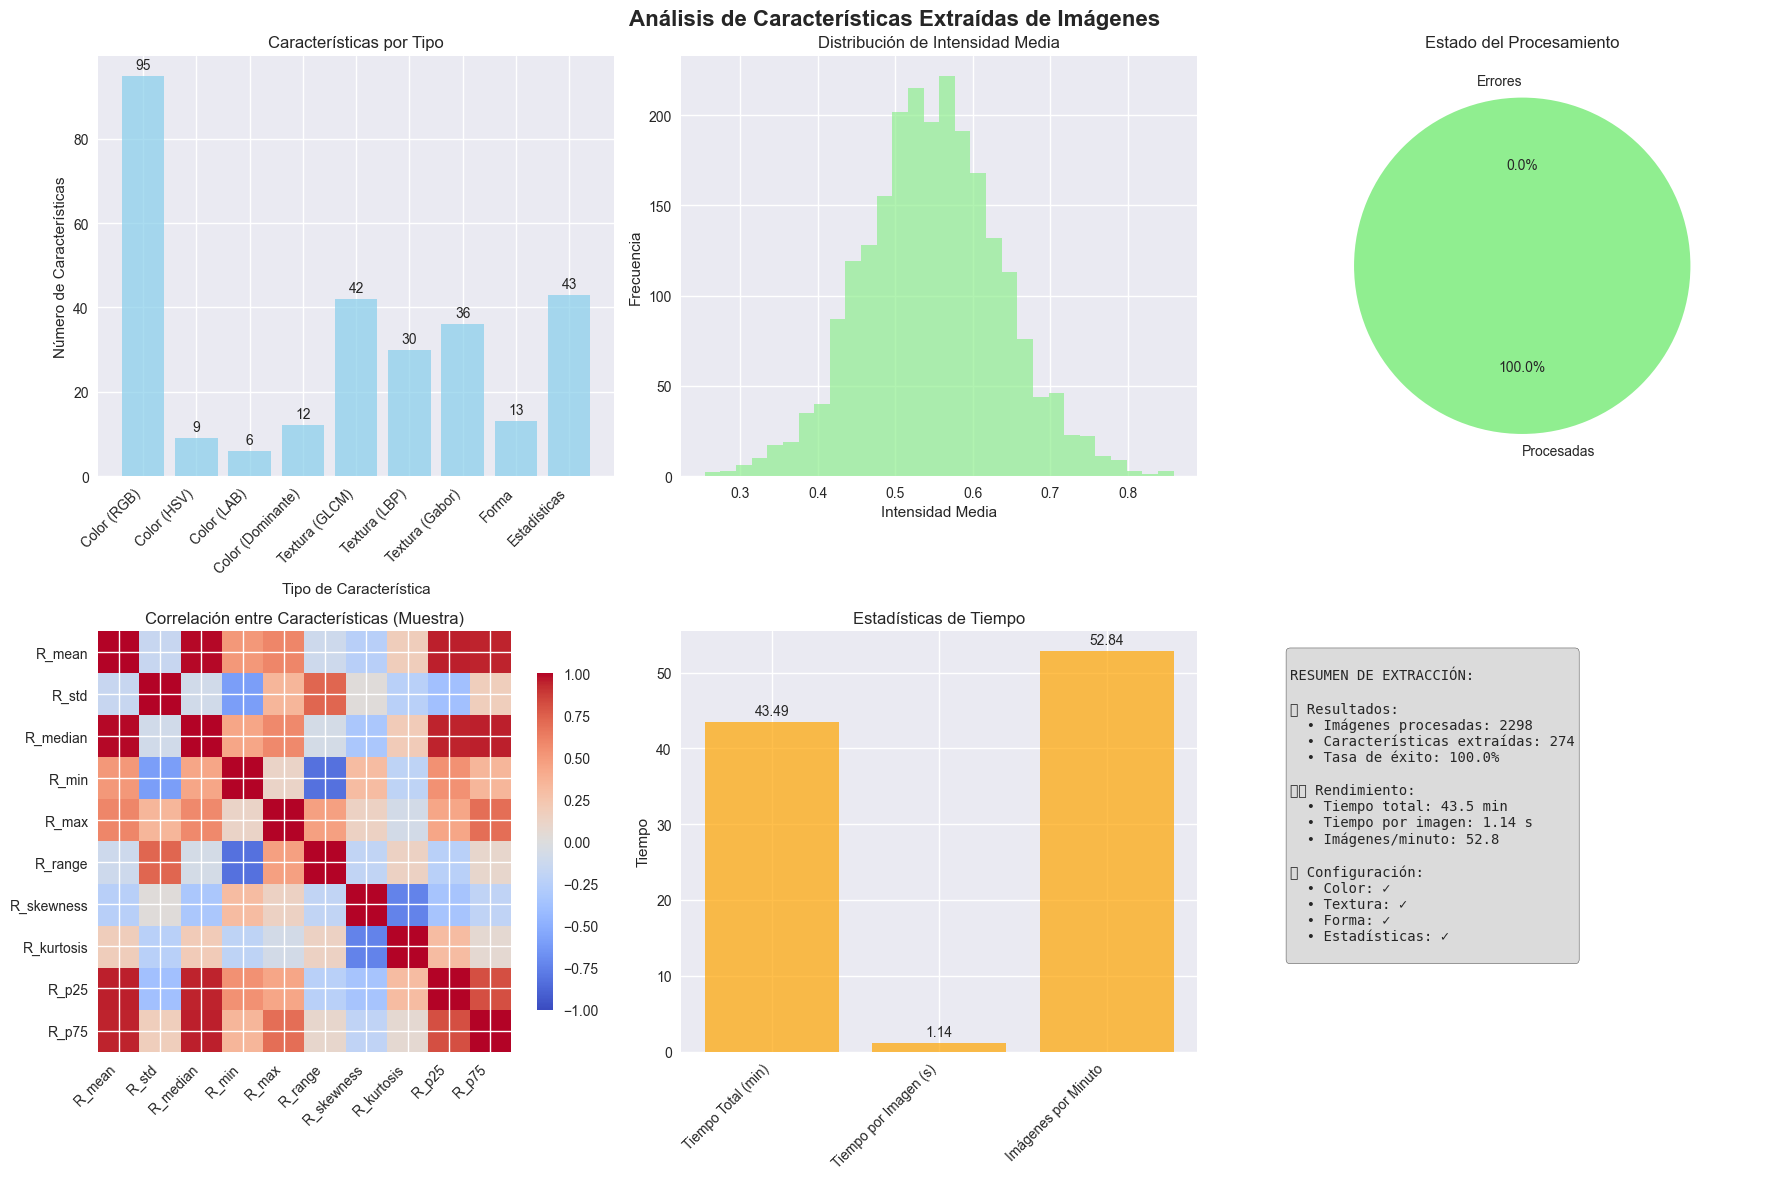

2025-06-30 00:59:13,036 - INFO - Extracción de características de imágenes completada exitosamente


  ✓ Metadatos guardados en: ./resultados/image_extraction_metadata.json


In [5]:
def extract_image_features_optimized(df, config):
    """
    Extracción optimizada de características de imágenes con múltiples tipos de descriptores
    
    Args:
        df: DataFrame con metadata
        config: Configuración del proyecto
    
    Returns:
        image_features_results: Diccionario con características extraídas y metadatos
    """
    
    print("="*60)
    print("EXTRACCIÓN OPTIMIZADA DE CARACTERÍSTICAS DE IMÁGENES")
    print("="*60)
    
    logger.info("Iniciando extracción de características de imágenes")
    
    # ===== CONFIGURACIÓN INICIAL =====
    images_folder = config['paths']['images_folder']
    target_size = config['data_params']['target_image_size']
    
    print(f"📁 Carpeta de imágenes: {images_folder}")
    print(f"📐 Tamaño objetivo: {target_size}")
    print(f"🖼️  Total de imágenes en metadata: {len(df)}")
    
    # Verificar configuración de extracción
    extract_config = config['feature_extraction']
    print(f"\n🔧 Configuración de extracción:")
    print(f"  Color: {'✓' if extract_config['extract_color_features'] else '✗'}")
    print(f"  Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}")
    print(f"  Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}")
    print(f"  Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}")
    
    # ===== FUNCIONES AUXILIARES PARA EXTRACCIÓN =====
    
    def extract_color_features(img, config):
        """Extrae características de color de la imagen"""
        features = {}
        
        if len(img.shape) > 2 and img.shape[2] >= 3:
            # ===== CARACTERÍSTICAS RGB =====
            for i, channel in enumerate(['R', 'G', 'B']):
                channel_data = img[:, :, i]
                
                # Estadísticas básicas
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
                features[f'{channel}_min'] = np.min(channel_data)
                features[f'{channel}_max'] = np.max(channel_data)
                features[f'{channel}_range'] = np.max(channel_data) - np.min(channel_data)
                
                # Momentos estadísticos
                features[f'{channel}_skewness'] = np.mean((channel_data - np.mean(channel_data))**3) / (np.std(channel_data)**3 + 1e-7)
                features[f'{channel}_kurtosis'] = np.mean((channel_data - np.mean(channel_data))**4) / (np.std(channel_data)**4 + 1e-7)
                
                # Percentiles
                features[f'{channel}_p25'] = np.percentile(channel_data, 25)
                features[f'{channel}_p75'] = np.percentile(channel_data, 75)
                features[f'{channel}_iqr'] = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
                
                # Histograma
                hist, _ = np.histogram(channel_data, bins=config['color_bins'], range=[0, 1])
                for j, h in enumerate(hist):
                    features[f'{channel}_hist_{j}'] = h
            
            # ===== CARACTERÍSTICAS HSV =====
            img_hsv = color.rgb2hsv(img)
            for i, channel in enumerate(['H', 'S', 'V']):
                channel_data = img_hsv[:, :, i]
                features[f'{channel}_mean'] = np.mean(channel_data)
                features[f'{channel}_std'] = np.std(channel_data)
                features[f'{channel}_median'] = np.median(channel_data)
            
            # ===== CARACTERÍSTICAS LAB =====
            try:
                img_lab = color.rgb2lab(img)
                for i, channel in enumerate(['L', 'A', 'B_lab']):
                    channel_data = img_lab[:, :, i]
                    features[f'{channel}_mean'] = np.mean(channel_data)
                    features[f'{channel}_std'] = np.std(channel_data)
            except:
                pass  # En caso de error con la conversión LAB
            
            # ===== DOMINANCIA DE COLOR =====
            # Calcular color dominante
            img_reshaped = img.reshape(-1, 3)
            from sklearn.cluster import KMeans
            
            try:
                kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
                kmeans.fit(img_reshaped)
                
                # Obtener colores dominantes y sus proporciones
                colors = kmeans.cluster_centers_
                labels = kmeans.labels_
                
                for i in range(3):
                    proportion = np.sum(labels == i) / len(labels)
                    features[f'dominant_color_{i}_R'] = colors[i, 0]
                    features[f'dominant_color_{i}_G'] = colors[i, 1]
                    features[f'dominant_color_{i}_B'] = colors[i, 2]
                    features[f'dominant_color_{i}_proportion'] = proportion
            except:
                # En caso de error, usar valores por defecto
                for i in range(3):
                    features[f'dominant_color_{i}_R'] = 0
                    features[f'dominant_color_{i}_G'] = 0
                    features[f'dominant_color_{i}_B'] = 0
                    features[f'dominant_color_{i}_proportion'] = 0
        
        return features
    
    def extract_texture_features(img_gray, config):
        """Extrae características de textura de la imagen en escala de grises"""
        features = {}
        
        # Convertir a enteros para GLCM
        img_gray_int = (img_gray * 255).astype(np.uint8)
        
        # ===== GLCM (Gray Level Co-occurrence Matrix) =====
        distances = config['glcm_distances']
        angles_deg = config['glcm_angles']
        angles_rad = [np.deg2rad(angle) for angle in angles_deg]
        
        try:
            glcm = feature.graycomatrix(
                img_gray_int, 
                distances=distances, 
                angles=angles_rad, 
                levels=32,  # Reducir niveles para eficiencia
                symmetric=True, 
                normed=True
            )
            
            # Propiedades de GLCM
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            
            for prop in properties:
                try:
                    if prop == 'ASM':
                        prop_values = feature.graycoprops(glcm, 'ASM')
                    else:
                        prop_values = feature.graycoprops(glcm, prop)
                    
                    # Estadísticas de la propiedad a través de distancias y ángulos
                    features[f'glcm_{prop}_mean'] = np.mean(prop_values)
                    features[f'glcm_{prop}_std'] = np.std(prop_values)
                    features[f'glcm_{prop}_min'] = np.min(prop_values)
                    features[f'glcm_{prop}_max'] = np.max(prop_values)
                    
                    # Valores específicos por distancia (promediando ángulos)
                    for i, dist in enumerate(distances):
                        features[f'glcm_{prop}_dist_{dist}'] = np.mean(prop_values[i, :])
                except:
                    # En caso de error, asignar valores por defecto
                    features[f'glcm_{prop}_mean'] = 0
                    features[f'glcm_{prop}_std'] = 0
                    features[f'glcm_{prop}_min'] = 0
                    features[f'glcm_{prop}_max'] = 0
                    
                    for dist in distances:
                        features[f'glcm_{prop}_dist_{dist}'] = 0
        except:
            # En caso de error con GLCM, asignar valores por defecto
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for prop in properties:
                features[f'glcm_{prop}_mean'] = 0
                features[f'glcm_{prop}_std'] = 0
                features[f'glcm_{prop}_min'] = 0
                features[f'glcm_{prop}_max'] = 0
                for dist in distances:
                    features[f'glcm_{prop}_dist_{dist}'] = 0
        
        # ===== LBP (Local Binary Patterns) =====
        try:
            radius = config['lbp_radius']
            n_points = config['lbp_n_points']
            
            lbp = feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
            
            # Histograma de LBP
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
            
            # Normalizar histograma
            lbp_hist = lbp_hist / (np.sum(lbp_hist) + 1e-7)
            
            for i, h in enumerate(lbp_hist):
                features[f'lbp_hist_{i}'] = h
            
            # Estadísticas de LBP
            features['lbp_mean'] = np.mean(lbp)
            features['lbp_std'] = np.std(lbp)
            features['lbp_uniformity'] = np.sum(lbp_hist**2)  # Medida de uniformidad
            features['lbp_entropy'] = -np.sum(lbp_hist * np.log2(lbp_hist + 1e-7))  # Entropía
            
        except:
            # En caso de error con LBP
            n_points = config['lbp_n_points']
            for i in range(n_points + 2):
                features[f'lbp_hist_{i}'] = 0
            features['lbp_mean'] = 0
            features['lbp_std'] = 0
            features['lbp_uniformity'] = 0
            features['lbp_entropy'] = 0
        
        # ===== FILTROS DE GABOR =====
        try:
            # Aplicar filtros de Gabor con diferentes frecuencias y orientaciones
            gabor_responses = []
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            
            for freq in frequencies:
                for orient in orientations:
                    try:
                        gabor_real, _ = filters.gabor(img_gray, frequency=freq, 
                                                    theta=np.deg2rad(orient))
                        gabor_responses.append(gabor_real)
                        
                        # Estadísticas de la respuesta de Gabor
                        features[f'gabor_f{freq}_o{orient}_mean'] = np.mean(np.abs(gabor_real))
                        features[f'gabor_f{freq}_o{orient}_std'] = np.std(gabor_real)
                        features[f'gabor_f{freq}_o{orient}_energy'] = np.sum(gabor_real**2)
                    except:
                        features[f'gabor_f{freq}_o{orient}_mean'] = 0
                        features[f'gabor_f{freq}_o{orient}_std'] = 0
                        features[f'gabor_f{freq}_o{orient}_energy'] = 0
        except:
            # En caso de error con Gabor
            frequencies = [0.1, 0.3, 0.5]
            orientations = [0, 45, 90, 135]
            for freq in frequencies:
                for orient in orientations:
                    features[f'gabor_f{freq}_o{orient}_mean'] = 0
                    features[f'gabor_f{freq}_o{orient}_std'] = 0
                    features[f'gabor_f{freq}_o{orient}_energy'] = 0
        
        return features
    
    def extract_shape_features(img_gray, config):
        """Extrae características de forma de la imagen"""
        features = {}
        
        try:
            # ===== DETECCIÓN DE BORDES =====
            # Canny edge detection
            edges_canny = feature.canny(img_gray, sigma=1.0, low_threshold=0.1, high_threshold=0.2)
            features['edge_density_canny'] = np.sum(edges_canny) / edges_canny.size
            features['edge_count_canny'] = np.sum(edges_canny)
            
            # Sobel edges
            edges_sobel_h = filters.sobel_h(img_gray)
            edges_sobel_v = filters.sobel_v(img_gray)
            edges_sobel_mag = np.sqrt(edges_sobel_h**2 + edges_sobel_v**2)
            
            features['sobel_mean'] = np.mean(edges_sobel_mag)
            features['sobel_std'] = np.std(edges_sobel_mag)
            features['sobel_max'] = np.max(edges_sobel_mag)
            
            # ===== SEGMENTACIÓN Y REGIONES =====
            # Umbralización de Otsu para segmentación básica
            try:
                threshold_otsu = filters.threshold_otsu(img_gray)
                binary_otsu = img_gray > threshold_otsu
                
                # Propiedades de regiones
                labeled_img = measure.label(binary_otsu)
                regions = measure.regionprops(labeled_img)
                
                if regions:
                    # Estadísticas de las regiones
                    areas = [region.area for region in regions]
                    perimeters = [region.perimeter for region in regions if region.perimeter > 0]
                    eccentricities = [region.eccentricity for region in regions]
                    solidities = [region.solidity for region in regions]
                    
                    features['num_regions'] = len(regions)
                    features['total_area'] = np.sum(areas)
                    features['mean_area'] = np.mean(areas)
                    features['std_area'] = np.std(areas)
                    features['max_area'] = np.max(areas)
                    
                    if perimeters:
                        features['mean_perimeter'] = np.mean(perimeters)
                        features['std_perimeter'] = np.std(perimeters)
                        
                        # Compacidad (4π*área/perímetro²)
                        compactness = [4 * np.pi * areas[i] / (perimeters[i]**2) 
                                     for i in range(min(len(areas), len(perimeters)))]
                        if compactness:
                            features['mean_compactness'] = np.mean(compactness)
                            features['std_compactness'] = np.std(compactness)
                        else:
                            features['mean_compactness'] = 0
                            features['std_compactness'] = 0
                    else:
                        features['mean_perimeter'] = 0
                        features['std_perimeter'] = 0
                        features['mean_compactness'] = 0
                        features['std_compactness'] = 0
                    
                    features['mean_eccentricity'] = np.mean(eccentricities)
                    features['std_eccentricity'] = np.std(eccentricities)
                    features['mean_solidity'] = np.mean(solidities)
                    features['std_solidity'] = np.std(solidities)
                    
                    # Región más grande
                    largest_region = max(regions, key=lambda r: r.area)
                    features['largest_region_area'] = largest_region.area
                    features['largest_region_eccentricity'] = largest_region.eccentricity
                    features['largest_region_solidity'] = largest_region.solidity
                    
                else:
                    # No se encontraron regiones
                    region_features = ['num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                                     'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                                     'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                                     'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity']
                    for feat in region_features:
                        features[feat] = 0
                        
            except:
                # Error en segmentación
                region_features = ['num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                                 'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                                 'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                                 'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity']
                for feat in region_features:
                    features[feat] = 0
            
            # ===== TRANSFORMADA DE HOUGH PARA CÍRCULOS =====
            try:
                # Detectar círculos usando transformada de Hough
                edges_for_hough = feature.canny(img_gray, sigma=2, low_threshold=0.1, high_threshold=0.2)
                hough_radii = np.arange(10, 50, 5)
                hough_res = feature.hough_circle(edges_for_hough, hough_radii)
                
                # Encontrar picos en el espacio de Hough
                accums, cx, cy, radii = feature.hough_circle_peaks(hough_res, hough_radii, 
                                                                  total_num_peaks=5)
                
                features['num_circles_detected'] = len(accums)
                if len(accums) > 0:
                    features['strongest_circle_accumulator'] = np.max(accums)
                    features['mean_circle_radius'] = np.mean(radii)
                    features['std_circle_radius'] = np.std(radii)
                else:
                    features['strongest_circle_accumulator'] = 0
                    features['mean_circle_radius'] = 0
                    features['std_circle_radius'] = 0
                    
            except:
                features['num_circles_detected'] = 0
                features['strongest_circle_accumulator'] = 0
                features['mean_circle_radius'] = 0
                features['std_circle_radius'] = 0
                
        except Exception as e:
            # En caso de error general en extracción de forma
            shape_features = ['edge_density_canny', 'edge_count_canny', 'sobel_mean', 'sobel_std', 'sobel_max',
                            'num_regions', 'total_area', 'mean_area', 'std_area', 'max_area',
                            'mean_perimeter', 'std_perimeter', 'mean_compactness', 'std_compactness',
                            'mean_eccentricity', 'std_eccentricity', 'mean_solidity', 'std_solidity',
                            'largest_region_area', 'largest_region_eccentricity', 'largest_region_solidity',
                            'num_circles_detected', 'strongest_circle_accumulator', 'mean_circle_radius', 'std_circle_radius']
            for feat in shape_features:
                features[feat] = 0
        
        return features
    
    def extract_statistical_features(img_gray, config):
        """Extrae características estadísticas generales de la imagen"""
        features = {}
        
        # ===== ESTADÍSTICAS BÁSICAS =====
        features['mean_intensity'] = np.mean(img_gray)
        features['std_intensity'] = np.std(img_gray)
        features['median_intensity'] = np.median(img_gray)
        features['min_intensity'] = np.min(img_gray)
        features['max_intensity'] = np.max(img_gray)
        features['range_intensity'] = np.max(img_gray) - np.min(img_gray)
        
        # ===== PERCENTILES =====
        percentiles = [5, 10, 25, 75, 90, 95]
        for p in percentiles:
            features[f'percentile_{p}'] = np.percentile(img_gray, p)
        
        features['iqr'] = np.percentile(img_gray, 75) - np.percentile(img_gray, 25)
        
        # ===== MOMENTOS ESTADÍSTICOS =====
        features['skewness'] = np.mean((img_gray - np.mean(img_gray))**3) / (np.std(img_gray)**3 + 1e-7)
        features['kurtosis'] = np.mean((img_gray - np.mean(img_gray))**4) / (np.std(img_gray)**4 + 1e-7)
        
        # ===== ENTROPÍA =====
        # Calcular entropía de la imagen
        hist, _ = np.histogram(img_gray, bins=256, range=[0, 1])
        hist = hist / (np.sum(hist) + 1e-7)  # Normalizar
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features['entropy'] = entropy
        
        # ===== ENERGÍA =====
        features['energy'] = np.sum(img_gray**2)
        features['rms'] = np.sqrt(np.mean(img_gray**2))
        
        # ===== VARIANZA LOCAL =====
        # Calcular varianza en ventanas locales
        try:
            from skimage.filters.rank import variance
            from skimage.morphology import disk
            
            # Convertir a uint8 para filtros de rango
            img_uint8 = (img_gray * 255).astype(np.uint8)
            local_variance = variance(img_uint8, disk(5))
            
            features['local_variance_mean'] = np.mean(local_variance)
            features['local_variance_std'] = np.std(local_variance)
            features['local_variance_max'] = np.max(local_variance)
        except:
            features['local_variance_mean'] = 0
            features['local_variance_std'] = 0
            features['local_variance_max'] = 0
        
        return features
    
    def process_single_image(img_path, config):
        """Procesa una sola imagen y extrae todas las características"""
        try:
            # Cargar imagen
            img = io.imread(img_path)
            
            # Convertir RGBA a RGB si es necesario (AÑADIR ESTA LÍNEA)
            if len(img.shape) > 2 and img.shape[2] == 4:
                img = img[:, :, :3]  # Elimina el canal alpha
            
            # Redimensionar
            img_resized = resize(img, target_size, anti_aliasing=True)
            
            # Convertir a escala de grises
            if len(img_resized.shape) > 2 and img_resized.shape[2] > 1:
                img_gray = color.rgb2gray(img_resized)
            else:
                img_gray = img_resized
            
            # Diccionario para almacenar todas las características
            all_features = {}
            
            # Extraer características según configuración
            if config['extract_color_features'] and len(img_resized.shape) > 2:
                color_features = extract_color_features(img_resized, config)
                all_features.update(color_features)
            
            if config['extract_texture_features']:
                texture_features = extract_texture_features(img_gray, config)
                all_features.update(texture_features)
            
            if config['extract_shape_features']:
                shape_features = extract_shape_features(img_gray, config)
                all_features.update(shape_features)
            
            if config['extract_statistical_features']:
                statistical_features = extract_statistical_features(img_gray, config)
                all_features.update(statistical_features)
            
            return all_features
            
        except Exception as e:
            logger.warning(f"Error procesando imagen {img_path}: {e}")
            return None
    
    # ===== PROCESAMIENTO PRINCIPAL =====
    print(f"\n🔄 Iniciando extracción de características...")
    
    image_features = {}
    processed_count = 0
    error_count = 0
    start_time = time.time()
    
    # Crear barra de progreso simple
    total_images = len(df)
    
    for index, row in df.iterrows():
        img_id = row['img_id']
        img_path = os.path.join(images_folder, img_id)
        
        # Verificar si la imagen existe
        if os.path.exists(img_path):
            features = process_single_image(img_path, extract_config)
            if features is not None:
                image_features[img_id] = features
                processed_count += 1
            else:
                error_count += 1
        else:
            error_count += 1
        
        # Mostrar progreso cada 100 imágenes
        if (processed_count + error_count) % 100 == 0:
            elapsed_time = time.time() - start_time
            progress = (processed_count + error_count) / total_images * 100
            estimated_total = elapsed_time / (processed_count + error_count) * total_images
            remaining_time = estimated_total - elapsed_time
            
            print(f"  Progreso: {progress:.1f}% | Procesadas: {processed_count} | Errores: {error_count} | "
                  f"Tiempo restante: {remaining_time/60:.1f} min")
    
    total_time = time.time() - start_time
    
    print(f"\n✅ Extracción completada:")
    print(f"  Tiempo total: {total_time/60:.1f} minutos")
    print(f"  Imágenes procesadas: {processed_count}")
    print(f"  Errores: {error_count}")
    print(f"  Tasa de éxito: {processed_count/(processed_count+error_count)*100:.1f}%")
    
    if processed_count == 0:
        raise ValueError("No se pudo procesar ninguna imagen. Verificar rutas y configuración.")
    
    # ===== CONVERTIR A DATAFRAME =====
    print(f"\n📊 Creando DataFrame de características...")
    
    image_features_df = pd.DataFrame.from_dict(image_features, orient='index')
    image_features_df.index.name = 'img_id'
    image_features_df = image_features_df.reset_index()
    
    print(f"  Forma del DataFrame: {image_features_df.shape}")
    print(f"  Características extraídas: {image_features_df.shape[1] - 1}")  # -1 por la columna img_id
    
    # ===== ANÁLISIS DE CARACTERÍSTICAS EXTRAÍDAS =====
    print(f"\n🔍 Análisis de características extraídas:")
    
    feature_columns = [col for col in image_features_df.columns if col != 'img_id']
    
    # Estadísticas básicas
    print(f"  Total de características: {len(feature_columns)}")
    
    # Contar características por tipo
    feature_types = {
        'Color (RGB)': len([col for col in feature_columns if any(c in col for c in ['R_', 'G_', 'B_'])]),
        'Color (HSV)': len([col for col in feature_columns if any(c in col for c in ['H_', 'S_', 'V_'])]),
        'Color (LAB)': len([col for col in feature_columns if any(c in col for c in ['L_', 'A_', 'B_lab'])]),
        'Color (Dominante)': len([col for col in feature_columns if 'dominant_color' in col]),
        'Textura (GLCM)': len([col for col in feature_columns if 'glcm_' in col]),
        'Textura (LBP)': len([col for col in feature_columns if 'lbp_' in col]),
        'Textura (Gabor)': len([col for col in feature_columns if 'gabor_' in col]),
        'Forma': len([col for col in feature_columns if any(s in col for s in ['edge_', 'sobel_', 'region', 'circle'])]),
        'Estadísticas': len([col for col in feature_columns if any(s in col for s in ['mean_', 'std_', 'median_', 'percentile_', 'entropy', 'energy'])])
    }
    
    for feat_type, count in feature_types.items():
        if count > 0:
            print(f"    {feat_type}: {count}")
    
    # Verificar valores problemáticos
    nan_count = image_features_df[feature_columns].isnull().sum().sum()
    inf_count = np.isinf(image_features_df[feature_columns].select_dtypes(include=[np.number])).sum().sum()
    
    print(f"\n🔍 Verificación de calidad:")
    print(f"  Valores NaN: {nan_count}")
    print(f"  Valores infinitos: {inf_count}")
    
    if nan_count > 0 or inf_count > 0:
        print(f"  ⚠️  Limpiando valores problemáticos...")
        
        # Reemplazar NaN e infinitos con 0
        image_features_df[feature_columns] = image_features_df[feature_columns].replace([np.inf, -np.inf], np.nan)
        image_features_df[feature_columns] = image_features_df[feature_columns].fillna(0)
        
        print(f"  ✓ Valores problemáticos reemplazados con 0")
    
    # ===== GUARDAR RESULTADOS =====
    print(f"\n💾 Guardando resultados...")
    
    # Guardar DataFrame de características
    features_path = os.path.join(config['paths']['output_folder'], 'image_features.csv')
    image_features_df.to_csv(features_path, index=False)
    print(f"  ✓ Características guardadas en: {features_path}")
    
    # Guardar también en formato pickle para preservar tipos de datos
    features_pkl_path = os.path.join(config['paths']['output_folder'], 'image_features.pkl')
    image_features_df.to_pickle(features_pkl_path)
    print(f"  ✓ Características (pickle) guardadas en: {features_pkl_path}")
    
    # ===== CREAR VISUALIZACIÓN DE CARACTERÍSTICAS =====
    print(f"\n📊 Generando visualización de características...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Análisis de Características Extraídas de Imágenes', fontsize=16, fontweight='bold')
    
    # 1. Distribución de tipos de características
    ax1 = axes[0, 0]
    feature_type_counts = [count for count in feature_types.values() if count > 0]
    feature_type_names = [name for name, count in feature_types.items() if count > 0]
    
    bars = ax1.bar(range(len(feature_type_names)), feature_type_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Características por Tipo')
    ax1.set_xlabel('Tipo de Característica')
    ax1.set_ylabel('Número de Características')
    ax1.set_xticks(range(len(feature_type_names)))
    ax1.set_xticklabels(feature_type_names, rotation=45, ha='right')
    
    # Añadir etiquetas de valores
    for bar, count in zip(bars, feature_type_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(feature_type_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 2. Distribución de una característica de ejemplo (mean_intensity)
    ax2 = axes[0, 1]
    if 'mean_intensity' in feature_columns:
        ax2.hist(image_features_df['mean_intensity'], bins=30, alpha=0.7, color='lightgreen')
        ax2.set_title('Distribución de Intensidad Media')
        ax2.set_xlabel('Intensidad Media')
        ax2.set_ylabel('Frecuencia')
    else:
        ax2.text(0.5, 0.5, 'mean_intensity\nno disponible', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Distribución de Intensidad Media')
    
    # 3. Estadísticas de procesamiento
    ax3 = axes[0, 2]
    processing_stats = {
        'Procesadas': processed_count,
        'Errores': error_count
    }
    
    colors = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = ax3.pie(processing_stats.values(), labels=processing_stats.keys(), 
                                      colors=colors, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Estado del Procesamiento')
    
    # 4. Correlación entre características (muestra)
    ax4 = axes[1, 0]
    if len(feature_columns) > 1:
        # Seleccionar una muestra de características para correlación
        sample_features = feature_columns[:min(10, len(feature_columns))]
        corr_matrix = image_features_df[sample_features].corr()
        
        im = ax4.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación entre Características (Muestra)')
        ax4.set_xticks(range(len(sample_features)))
        ax4.set_yticks(range(len(sample_features)))
        ax4.set_xticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features], 
                           rotation=45, ha='right')
        ax4.set_yticklabels([feat[:15] + '...' if len(feat) > 15 else feat for feat in sample_features])
        
        plt.colorbar(im, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes características\npara correlación', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación entre Características')
    
    # 5. Tiempo de procesamiento
    ax5 = axes[1, 1]
    time_per_image = total_time / processed_count if processed_count > 0 else 0
    
    time_stats = {
        'Tiempo Total (min)': total_time / 60,
        'Tiempo por Imagen (s)': time_per_image,
        'Imágenes por Minuto': 60 / time_per_image if time_per_image > 0 else 0
    }
    
    bars = ax5.bar(range(len(time_stats)), list(time_stats.values()), color='orange', alpha=0.7)
    ax5.set_title('Estadísticas de Tiempo')
    ax5.set_xticks(range(len(time_stats)))
    ax5.set_xticklabels(list(time_stats.keys()), rotation=45, ha='right')
    ax5.set_ylabel('Tiempo')
    
    # Añadir etiquetas de valores
    for bar, value in zip(bars, time_stats.values()):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(time_stats.values())*0.01, 
                f'{value:.2f}', ha='center', va='bottom')
    
    # 6. Resumen de extracción
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_text = f"""
RESUMEN DE EXTRACCIÓN:

📊 Resultados:
  • Imágenes procesadas: {processed_count}
  • Características extraídas: {len(feature_columns)}
  • Tasa de éxito: {processed_count/(processed_count+error_count)*100:.1f}%

⏱️ Rendimiento:
  • Tiempo total: {total_time/60:.1f} min
  • Tiempo por imagen: {time_per_image:.2f} s
  • Imágenes/minuto: {60/time_per_image:.1f}

🔧 Configuración:
  • Color: {'✓' if extract_config['extract_color_features'] else '✗'}
  • Textura: {'✓' if extract_config['extract_texture_features'] else '✗'}
  • Forma: {'✓' if extract_config['extract_shape_features'] else '✗'}
  • Estadísticas: {'✓' if extract_config['extract_statistical_features'] else '✗'}
    """
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'image_features_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS =====
    image_features_results = {
        'image_features_df': image_features_df,
        'feature_columns': feature_columns,
        'extraction_summary': {
            'total_images_in_metadata': total_images,
            'images_processed': processed_count,
            'images_with_errors': error_count,
            'success_rate': processed_count / (processed_count + error_count) * 100,
            'total_features_extracted': len(feature_columns),
            'feature_types': feature_types,
            'processing_time_minutes': total_time / 60,
            'time_per_image_seconds': time_per_image,
            'images_per_minute': 60 / time_per_image if time_per_image > 0 else 0
        },
        'extraction_config': extract_config
    }
    
    # Guardar metadatos de extracción
    metadata_path = os.path.join(config['paths']['output_folder'], 'image_extraction_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(image_features_results['extraction_summary'], f, indent=2, default=str)
    
    print(f"  ✓ Metadatos guardados en: {metadata_path}")
    
    logger.info("Extracción de características de imágenes completada exitosamente")
    
    return image_features_results

# ===== EJECUTAR EXTRACCIÓN DE CARACTERÍSTICAS =====
image_features_results = extract_image_features_optimized(df, CONFIG)


## 5. Creación del dataset multimodal con validación


2025-06-30 01:01:08,226 - INFO - Iniciando creación del dataset multimodal


CREACIÓN DEL DATASET MULTIMODAL CON VALIDACIÓN
📊 Información de entrada:
  Datos clínicos: (2298, 59)
  Características clínicas: 59
  Características de imágenes: 274
  Imágenes disponibles: 2298
  Etiquetas: 2298

🔍 Validación de consistencia de datos...
  Imágenes en DataFrame original: 2298
  Imágenes procesadas: 2298
  Imágenes faltantes en original: 0
  Imágenes faltantes en procesadas: 0

🔗 Alineando datos clínicos e imágenes...
  Muestras después de unir: 2298
  Muestras perdidas: 0 (0.0%)
  Datos clínicos filtrados: (2298, 59)
  Características de imágenes: (2298, 274)
  Etiquetas filtradas: 2298

✅ Verificación de calidad de datos...
  Datos clínicos - NaN: 0, Inf: 0
  Características de imágenes - NaN: 0, Inf: 0

📏 Normalizando características de imágenes...
  Rango antes del escalado: [-18.231, 60755.506]
  Rango después del escalado: [-7.552, 34.722]

🔗 Creando dataset multimodal...
  Forma del dataset multimodal: (2298, 333)
  Características clínicas: 59
  Característica

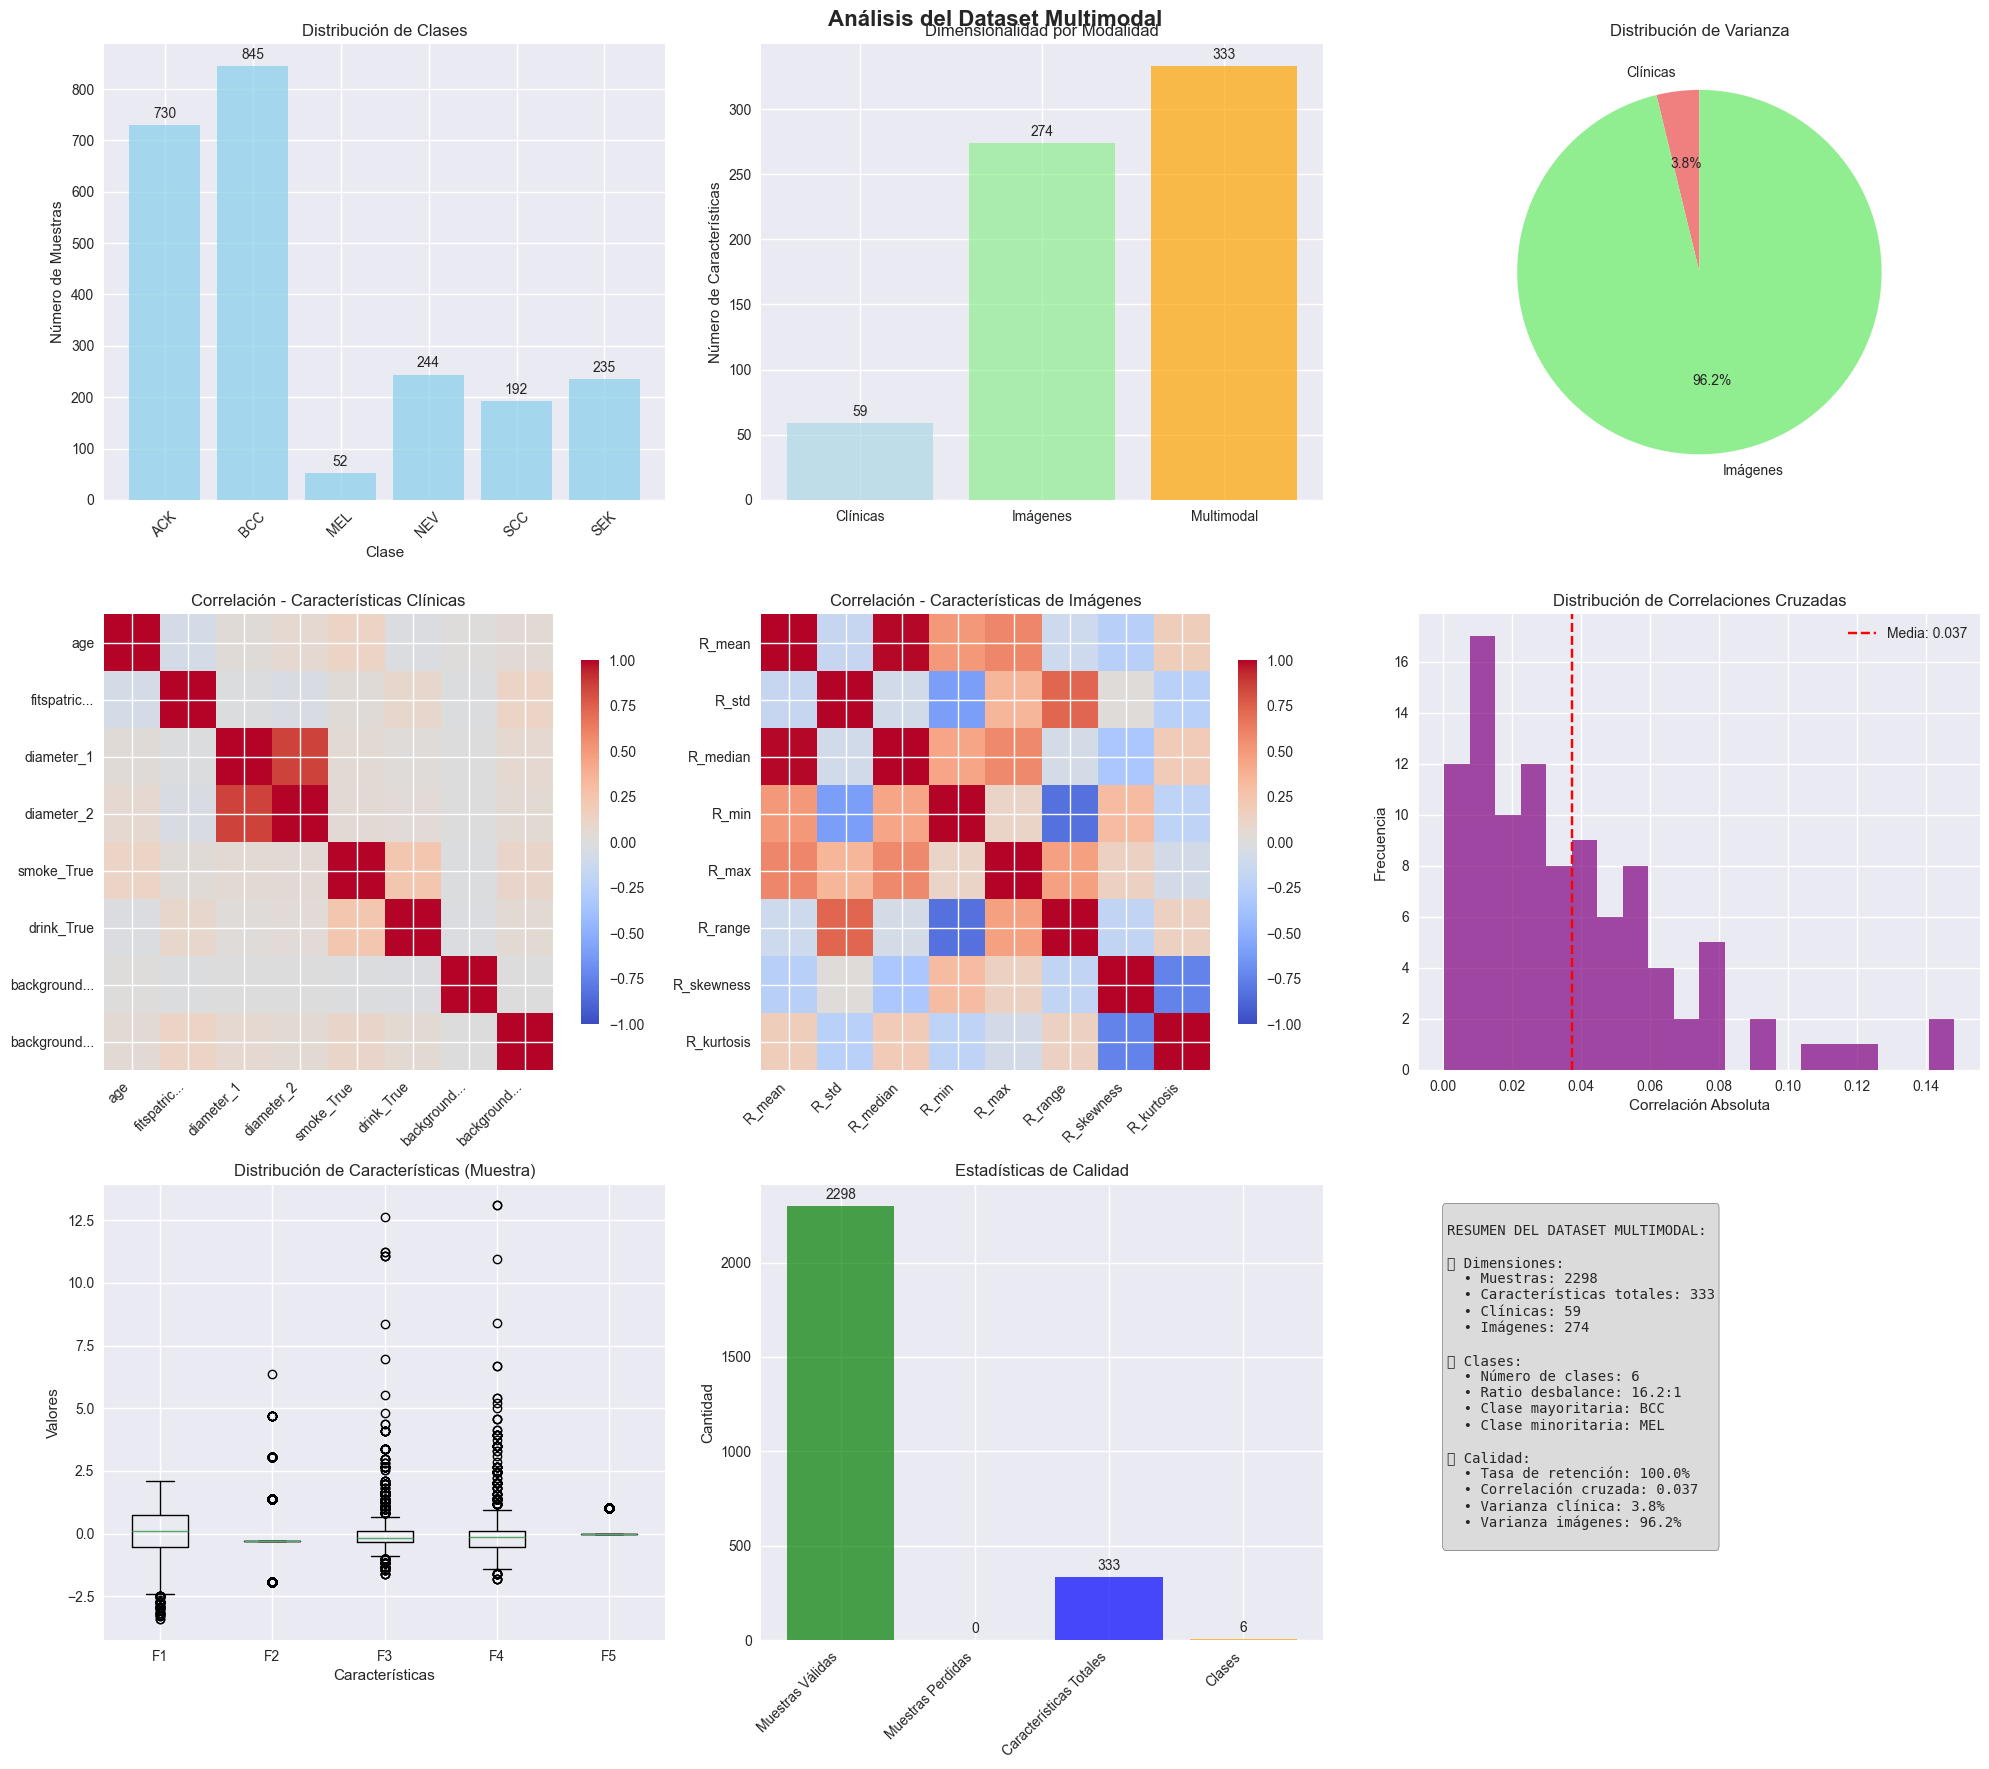


💾 Guardando dataset multimodal...


2025-06-30 01:01:13,140 - INFO - Creación del dataset multimodal completada exitosamente


  ✓ Dataset CSV guardado en: ./resultados/multimodal_dataset.csv
  ✓ Dataset pickle guardado en: ./resultados/multimodal_dataset.pkl
  ✓ Metadatos guardados en: ./resultados/multimodal_metadata.json


In [6]:
def create_multimodal_dataset_validated(df, preprocessing_results, image_features_results, config):
    """
    Crea dataset multimodal combinando datos clínicos e imágenes con validación exhaustiva
    
    Args:
        df: DataFrame original
        preprocessing_results: Resultados del preprocesamiento clínico
        image_features_results: Resultados de extracción de características de imágenes
        config: Configuración del proyecto
    
    Returns:
        multimodal_results: Diccionario con dataset multimodal y metadatos
    """
    
    print("="*60)
    print("CREACIÓN DEL DATASET MULTIMODAL CON VALIDACIÓN")
    print("="*60)
    
    logger.info("Iniciando creación del dataset multimodal")
    
    # ===== EXTRAER DATOS DE ENTRADA =====
    X_clinical = preprocessing_results['X_processed']
    y_encoded = preprocessing_results['y_encoded']
    clinical_feature_names = preprocessing_results['feature_names']
    label_encoder = preprocessing_results['label_encoder']
    
    image_features_df = image_features_results['image_features_df']
    image_feature_columns = image_features_results['feature_columns']
    
    print(f"📊 Información de entrada:")
    print(f"  Datos clínicos: {X_clinical.shape}")
    print(f"  Características clínicas: {len(clinical_feature_names)}")
    print(f"  Características de imágenes: {len(image_feature_columns)}")
    print(f"  Imágenes disponibles: {len(image_features_df)}")
    print(f"  Etiquetas: {len(y_encoded)}")
    
    # ===== VALIDACIÓN DE CONSISTENCIA =====
    print(f"\n🔍 Validación de consistencia de datos...")
    
    # Verificar que el número de muestras clínicas coincida con el DataFrame original
    if len(y_encoded) != len(df):
        logger.warning(f"Inconsistencia: {len(y_encoded)} etiquetas vs {len(df)} filas en DataFrame original")
    
    # Verificar que todas las imágenes en image_features_df estén en el DataFrame original
    original_img_ids = set(df['img_id'].tolist())
    processed_img_ids = set(image_features_df['img_id'].tolist())
    
    missing_in_original = processed_img_ids - original_img_ids
    missing_in_processed = original_img_ids - processed_img_ids
    
    print(f"  Imágenes en DataFrame original: {len(original_img_ids)}")
    print(f"  Imágenes procesadas: {len(processed_img_ids)}")
    print(f"  Imágenes faltantes en original: {len(missing_in_original)}")
    print(f"  Imágenes faltantes en procesadas: {len(missing_in_processed)}")
    
    if missing_in_original:
        logger.warning(f"Hay {len(missing_in_original)} imágenes procesadas que no están en el DataFrame original")
    
    if missing_in_processed:
        print(f"  ⚠️  {len(missing_in_processed)} imágenes del DataFrame original no fueron procesadas")
    
    # ===== ALINEACIÓN DE DATOS =====
    print(f"\n🔗 Alineando datos clínicos e imágenes...")
    
    # Crear DataFrame temporal con índices para facilitar la alineación
    df_temp = df.copy().reset_index(drop=True)
    df_temp['original_index'] = df_temp.index
    
    # Unir con características de imágenes
    df_merged = pd.merge(df_temp, image_features_df, on='img_id', how='inner')
    
    print(f"  Muestras después de unir: {len(df_merged)}")
    print(f"  Muestras perdidas: {len(df) - len(df_merged)} ({(len(df) - len(df_merged))/len(df)*100:.1f}%)")
    
    if len(df_merged) == 0:
        raise ValueError("No hay muestras después de unir datos clínicos e imágenes. Verificar img_id.")
    
    # Obtener índices válidos para filtrar datos clínicos
    valid_indices = df_merged['original_index'].tolist()
    
    # Filtrar datos clínicos y etiquetas
    if hasattr(X_clinical, 'toarray'):  # Si es matriz sparse
        X_clinical_filtered = X_clinical[valid_indices].toarray()
    else:
        X_clinical_filtered = X_clinical[valid_indices]
    
    y_filtered = y_encoded[valid_indices]
    
    # Extraer características de imágenes (sin img_id)
    X_image_features = df_merged[image_feature_columns].values
    
    print(f"  Datos clínicos filtrados: {X_clinical_filtered.shape}")
    print(f"  Características de imágenes: {X_image_features.shape}")
    print(f"  Etiquetas filtradas: {len(y_filtered)}")
    
    # ===== VERIFICACIÓN DE CALIDAD DE DATOS =====
    print(f"\n✅ Verificación de calidad de datos...")
    
    # Verificar valores problemáticos en datos clínicos
    clinical_nan = np.isnan(X_clinical_filtered).sum()
    clinical_inf = np.isinf(X_clinical_filtered).sum()
    
    # Verificar valores problemáticos en características de imágenes
    image_nan = np.isnan(X_image_features).sum()
    image_inf = np.isinf(X_image_features).sum()
    
    print(f"  Datos clínicos - NaN: {clinical_nan}, Inf: {clinical_inf}")
    print(f"  Características de imágenes - NaN: {image_nan}, Inf: {image_inf}")
    
    # Limpiar valores problemáticos si existen
    if clinical_nan > 0 or clinical_inf > 0:
        print(f"  🧹 Limpiando valores problemáticos en datos clínicos...")
        X_clinical_filtered = np.nan_to_num(X_clinical_filtered, nan=0.0, posinf=0.0, neginf=0.0)
    
    if image_nan > 0 or image_inf > 0:
        print(f"  🧹 Limpiando valores problemáticos en características de imágenes...")
        X_image_features = np.nan_to_num(X_image_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # ===== NORMALIZACIÓN DE CARACTERÍSTICAS DE IMÁGENES =====
    print(f"\n📏 Normalizando características de imágenes...")
    
    # Aplicar escalado a las características de imágenes para que estén en la misma escala que las clínicas
    image_scaler = StandardScaler()
    X_image_features_scaled = image_scaler.fit_transform(X_image_features)
    
    print(f"  Rango antes del escalado: [{X_image_features.min():.3f}, {X_image_features.max():.3f}]")
    print(f"  Rango después del escalado: [{X_image_features_scaled.min():.3f}, {X_image_features_scaled.max():.3f}]")
    
    # ===== CREACIÓN DEL DATASET MULTIMODAL =====
    print(f"\n🔗 Creando dataset multimodal...")
    
    # Combinar características clínicas e imágenes
    X_multimodal = np.hstack([X_clinical_filtered, X_image_features_scaled])
    
    # Combinar nombres de características
    multimodal_feature_names = clinical_feature_names + [f"img_{col}" for col in image_feature_columns]
    
    print(f"  Forma del dataset multimodal: {X_multimodal.shape}")
    print(f"  Características clínicas: {X_clinical_filtered.shape[1]}")
    print(f"  Características de imágenes: {X_image_features_scaled.shape[1]}")
    print(f"  Total de características: {len(multimodal_feature_names)}")
    
    # ===== ANÁLISIS DE DISTRIBUCIÓN DE CLASES =====
    print(f"\n📊 Análisis de distribución de clases en dataset multimodal...")
    
    unique_classes, class_counts = np.unique(y_filtered, return_counts=True)
    class_names = [label_encoder.classes_[i] for i in unique_classes]
    
    print(f"  Distribución de clases:")
    for class_name, class_idx, count in zip(class_names, unique_classes, class_counts):
        percentage = count / len(y_filtered) * 100
        print(f"    {class_name} (idx {class_idx}): {count} muestras ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = class_counts.max()
    min_class_size = class_counts.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    # ===== ANÁLISIS DE CORRELACIÓN ENTRE MODALIDADES =====
    print(f"\n🔍 Análisis de correlación entre modalidades...")
    
    # Calcular correlación promedio entre características clínicas e imágenes
    if X_clinical_filtered.shape[1] > 0 and X_image_features_scaled.shape[1] > 0:
        # Seleccionar una muestra de características para análisis de correlación
        n_clinical_sample = min(10, X_clinical_filtered.shape[1])
        n_image_sample = min(10, X_image_features_scaled.shape[1])
        
        clinical_sample = X_clinical_filtered[:, :n_clinical_sample]
        image_sample = X_image_features_scaled[:, :n_image_sample]
        
        # Calcular correlaciones cruzadas
        cross_correlations = []
        for i in range(clinical_sample.shape[1]):
            for j in range(image_sample.shape[1]):
                corr = np.corrcoef(clinical_sample[:, i], image_sample[:, j])[0, 1]
                if not np.isnan(corr):
                    cross_correlations.append(abs(corr))
        
        if cross_correlations:
            mean_cross_corr = np.mean(cross_correlations)
            max_cross_corr = np.max(cross_correlations)
            print(f"  Correlación cruzada promedio: {mean_cross_corr:.3f}")
            print(f"  Correlación cruzada máxima: {max_cross_corr:.3f}")
        else:
            print(f"  No se pudieron calcular correlaciones cruzadas")
    
    # ===== ANÁLISIS DE VARIANZA EXPLICADA POR MODALIDAD =====
    print(f"\n📈 Análisis de varianza por modalidad...")
    
    # Calcular varianza total de cada modalidad
    clinical_variance = np.var(X_clinical_filtered, axis=0).sum()
    image_variance = np.var(X_image_features_scaled, axis=0).sum()
    total_variance = clinical_variance + image_variance
    
    clinical_variance_pct = clinical_variance / total_variance * 100
    image_variance_pct = image_variance / total_variance * 100
    
    print(f"  Varianza explicada por datos clínicos: {clinical_variance_pct:.1f}%")
    print(f"  Varianza explicada por características de imágenes: {image_variance_pct:.1f}%")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones del dataset multimodal...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis del Dataset Multimodal', fontsize=16, fontweight='bold')
    
    # 1. Distribución de clases
    ax1 = axes[0, 0]
    bars = ax1.bar(class_names, class_counts, color='skyblue', alpha=0.7)
    ax1.set_title('Distribución de Clases')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Número de Muestras')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, class_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts)*0.01, 
                str(count), ha='center', va='bottom')
    
    # 2. Comparación de dimensionalidad
    ax2 = axes[0, 1]
    dimensions = {
        'Clínicas': X_clinical_filtered.shape[1],
        'Imágenes': X_image_features_scaled.shape[1],
        'Multimodal': X_multimodal.shape[1]
    }
    
    bars = ax2.bar(dimensions.keys(), dimensions.values(), 
                  color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
    ax2.set_title('Dimensionalidad por Modalidad')
    ax2.set_ylabel('Número de Características')
    
    for bar, value in zip(bars, dimensions.values()):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(dimensions.values())*0.01, 
                str(value), ha='center', va='bottom')
    
    # 3. Distribución de varianza
    ax3 = axes[0, 2]
    variance_data = [clinical_variance_pct, image_variance_pct]
    variance_labels = ['Clínicas', 'Imágenes']
    colors = ['lightcoral', 'lightgreen']
    
    wedges, texts, autotexts = ax3.pie(variance_data, labels=variance_labels, colors=colors, 
                                      autopct='%1.1f%%', startangle=90)
    ax3.set_title('Distribución de Varianza')
    
    # 4. Correlación entre características clínicas (muestra)
    ax4 = axes[1, 0]
    if X_clinical_filtered.shape[1] > 1:
        n_sample = min(8, X_clinical_filtered.shape[1])
        clinical_sample = X_clinical_filtered[:, :n_sample]
        clinical_corr = np.corrcoef(clinical_sample.T)
        
        im1 = ax4.imshow(clinical_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax4.set_title('Correlación - Características Clínicas')
        ax4.set_xticks(range(n_sample))
        ax4.set_yticks(range(n_sample))
        sample_names = [clinical_feature_names[i][:10] + '...' if len(clinical_feature_names[i]) > 10 
                       else clinical_feature_names[i] for i in range(n_sample)]
        ax4.set_xticklabels(sample_names, rotation=45, ha='right')
        ax4.set_yticklabels(sample_names)
        plt.colorbar(im1, ax=ax4, shrink=0.8)
    else:
        ax4.text(0.5, 0.5, 'Insuficientes\ncaracterísticas clínicas', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Correlación - Características Clínicas')
    
    # 5. Correlación entre características de imágenes (muestra)
    ax5 = axes[1, 1]
    if X_image_features_scaled.shape[1] > 1:
        n_sample = min(8, X_image_features_scaled.shape[1])
        image_sample = X_image_features_scaled[:, :n_sample]
        image_corr = np.corrcoef(image_sample.T)
        
        im2 = ax5.imshow(image_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        ax5.set_title('Correlación - Características de Imágenes')
        ax5.set_xticks(range(n_sample))
        ax5.set_yticks(range(n_sample))
        sample_names = [image_feature_columns[i][:10] + '...' if len(image_feature_columns[i]) > 10 
                       else image_feature_columns[i] for i in range(n_sample)]
        ax5.set_xticklabels(sample_names, rotation=45, ha='right')
        ax5.set_yticklabels(sample_names)
        plt.colorbar(im2, ax=ax5, shrink=0.8)
    else:
        ax5.text(0.5, 0.5, 'Insuficientes\ncaracterísticas de imágenes', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Correlación - Características de Imágenes')
    
    # 6. Correlación cruzada entre modalidades
    ax6 = axes[1, 2]
    if cross_correlations:
        ax6.hist(cross_correlations, bins=20, alpha=0.7, color='purple')
        ax6.set_title('Distribución de Correlaciones Cruzadas')
        ax6.set_xlabel('Correlación Absoluta')
        ax6.set_ylabel('Frecuencia')
        ax6.axvline(mean_cross_corr, color='red', linestyle='--', 
                   label=f'Media: {mean_cross_corr:.3f}')
        ax6.legend()
    else:
        ax6.text(0.5, 0.5, 'No se pudieron\ncalcular correlaciones\ncruzadas', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Correlaciones Cruzadas')
    
    # 7. Distribución de valores en dataset multimodal (muestra)
    ax7 = axes[2, 0]
    if X_multimodal.shape[1] > 0:
        # Mostrar distribución de las primeras características
        n_features_to_show = min(5, X_multimodal.shape[1])
        sample_data = X_multimodal[:, :n_features_to_show]
        
        ax7.boxplot(sample_data)
        ax7.set_title('Distribución de Características (Muestra)')
        ax7.set_xlabel('Características')
        ax7.set_ylabel('Valores')
        ax7.set_xticklabels([f'F{i+1}' for i in range(n_features_to_show)])
    
    # 8. Estadísticas de calidad de datos
    ax8 = axes[2, 1]
    quality_stats = {
        'Muestras Válidas': len(y_filtered),
        'Muestras Perdidas': len(df) - len(y_filtered),
        'Características Totales': X_multimodal.shape[1],
        'Clases': len(unique_classes)
    }
    
    bars = ax8.bar(range(len(quality_stats)), list(quality_stats.values()), 
                  color=['green', 'red', 'blue', 'orange'], alpha=0.7)
    ax8.set_title('Estadísticas de Calidad')
    ax8.set_xticks(range(len(quality_stats)))
    ax8.set_xticklabels(list(quality_stats.keys()), rotation=45, ha='right')
    ax8.set_ylabel('Cantidad')
    
    for bar, value in zip(bars, quality_stats.values()):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(quality_stats.values())*0.01, 
                str(value), ha='center', va='bottom')
    
    # 9. Resumen del proceso
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DEL DATASET MULTIMODAL:

📊 Dimensiones:
  • Muestras: {X_multimodal.shape[0]}
  • Características totales: {X_multimodal.shape[1]}
  • Clínicas: {X_clinical_filtered.shape[1]}
  • Imágenes: {X_image_features_scaled.shape[1]}

🎯 Clases:
  • Número de clases: {len(unique_classes)}
  • Ratio desbalance: {imbalance_ratio:.1f}:1
  • Clase mayoritaria: {class_names[np.argmax(class_counts)]}
  • Clase minoritaria: {class_names[np.argmin(class_counts)]}

📈 Calidad:
  • Tasa de retención: {len(y_filtered)/len(df)*100:.1f}%
  • Correlación cruzada: {mean_cross_corr:.3f}
  • Varianza clínica: {clinical_variance_pct:.1f}%
  • Varianza imágenes: {image_variance_pct:.1f}%
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'multimodal_dataset_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== GUARDAR DATASET MULTIMODAL =====
    print(f"\n💾 Guardando dataset multimodal...")
    
    # Crear DataFrame del dataset multimodal
    multimodal_df = pd.DataFrame(X_multimodal, columns=multimodal_feature_names)
    multimodal_df['target'] = y_filtered
    multimodal_df['target_name'] = [label_encoder.classes_[i] for i in y_filtered]
    
    # Añadir información de identificación
    multimodal_df['img_id'] = df_merged['img_id'].values
    multimodal_df['patient_id'] = df_merged['patient_id'].values
    multimodal_df['lesion_id'] = df_merged['lesion_id'].values
    
    # Guardar en CSV
    multimodal_csv_path = os.path.join(config['paths']['output_folder'], 'multimodal_dataset.csv')
    multimodal_df.to_csv(multimodal_csv_path, index=False)
    print(f"  ✓ Dataset CSV guardado en: {multimodal_csv_path}")
    
    # Guardar en pickle
    multimodal_pkl_path = os.path.join(config['paths']['output_folder'], 'multimodal_dataset.pkl')
    multimodal_df.to_pickle(multimodal_pkl_path)
    print(f"  ✓ Dataset pickle guardado en: {multimodal_pkl_path}")
    
    # ===== COMPILAR RESULTADOS =====
    multimodal_results = {
        'X_multimodal': X_multimodal,
        'y_multimodal': y_filtered,
        'multimodal_feature_names': multimodal_feature_names,
        'multimodal_df': multimodal_df,
        'label_encoder': label_encoder,
        'image_scaler': image_scaler,
        'valid_indices': valid_indices,
        'alignment_info': {
            'original_samples': len(df),
            'samples_after_merge': len(df_merged),
            'samples_lost': len(df) - len(df_merged),
            'retention_rate': len(df_merged) / len(df) * 100
        },
        'feature_info': {
            'clinical_features': X_clinical_filtered.shape[1],
            'image_features': X_image_features_scaled.shape[1],
            'total_features': X_multimodal.shape[1],
            'clinical_feature_names': clinical_feature_names,
            'image_feature_names': [f"img_{col}" for col in image_feature_columns]
        },
        'class_info': {
            'unique_classes': unique_classes,
            'class_names': class_names,
            'class_counts': class_counts,
            'class_distribution': dict(zip(class_names, class_counts)),
            'imbalance_ratio': imbalance_ratio
        },
        'quality_metrics': {
            'cross_correlation_mean': mean_cross_corr if cross_correlations else None,
            'cross_correlation_max': max_cross_corr if cross_correlations else None,
            'clinical_variance_percentage': clinical_variance_pct,
            'image_variance_percentage': image_variance_pct,
            'nan_count_clinical': int(clinical_nan),
            'inf_count_clinical': int(clinical_inf),
            'nan_count_image': int(image_nan),
            'inf_count_image': int(image_inf)
        }
    }
    
    # Guardar metadatos
    metadata_path = os.path.join(config['paths']['output_folder'], 'multimodal_metadata.json')
    metadata_to_save = {
        'alignment_info': multimodal_results['alignment_info'],
        'feature_info': multimodal_results['feature_info'],
        'class_info': {k: v.tolist() if isinstance(v, np.ndarray) else v 
                      for k, v in multimodal_results['class_info'].items()},
        'quality_metrics': multimodal_results['quality_metrics']
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata_to_save, f, indent=2, default=str)
    
    print(f"  ✓ Metadatos guardados en: {metadata_path}")
    
    logger.info("Creación del dataset multimodal completada exitosamente")
    
    return multimodal_results

# ===== EJECUTAR CREACIÓN DEL DATASET MULTIMODAL =====
multimodal_results = create_multimodal_dataset_validated(df, preprocessing_results, image_features_results, CONFIG)


## 6. Reducción de dimensionalidad con PCA y análisis de varianza


2025-06-30 01:01:20,168 - INFO - Iniciando análisis de PCA


REDUCCIÓN DE DIMENSIONALIDAD CON PCA
📊 Datos de entrada:
  Forma del dataset: (2298, 333)
  Características: 333
  Muestras: 2298

🔧 Preparando datos para PCA...
  Media actual: 0.026
  Desviación estándar actual: 0.845
  Aplicando escalado adicional...
  Nueva media: -0.000
  Nueva desviación estándar: 0.924

📈 Realizando análisis completo de PCA...
  Componentes totales: 333
  Varianza del primer componente: 0.168
  Varianza de los primeros 10 componentes: 0.568

🎯 Selección óptima de componentes...
  Métodos de selección:
    Umbral 95.0% varianza: 96 componentes
    Método del codo: 3 componentes
    Criterio de Kaiser: 55 componentes
    Componentes estables (>1%): 15 componentes
  Número óptimo seleccionado: 35 componentes
  Varianza explicada: 0.764

🔄 Aplicando PCA con diferentes configuraciones...
  Configuración 'optimal': 35 componentes
    Varianza explicada: 0.763
    Ratio de compresión: 9.5x
  Configuración 'conservative': 45 componentes
    Varianza explicada: 0.809
   

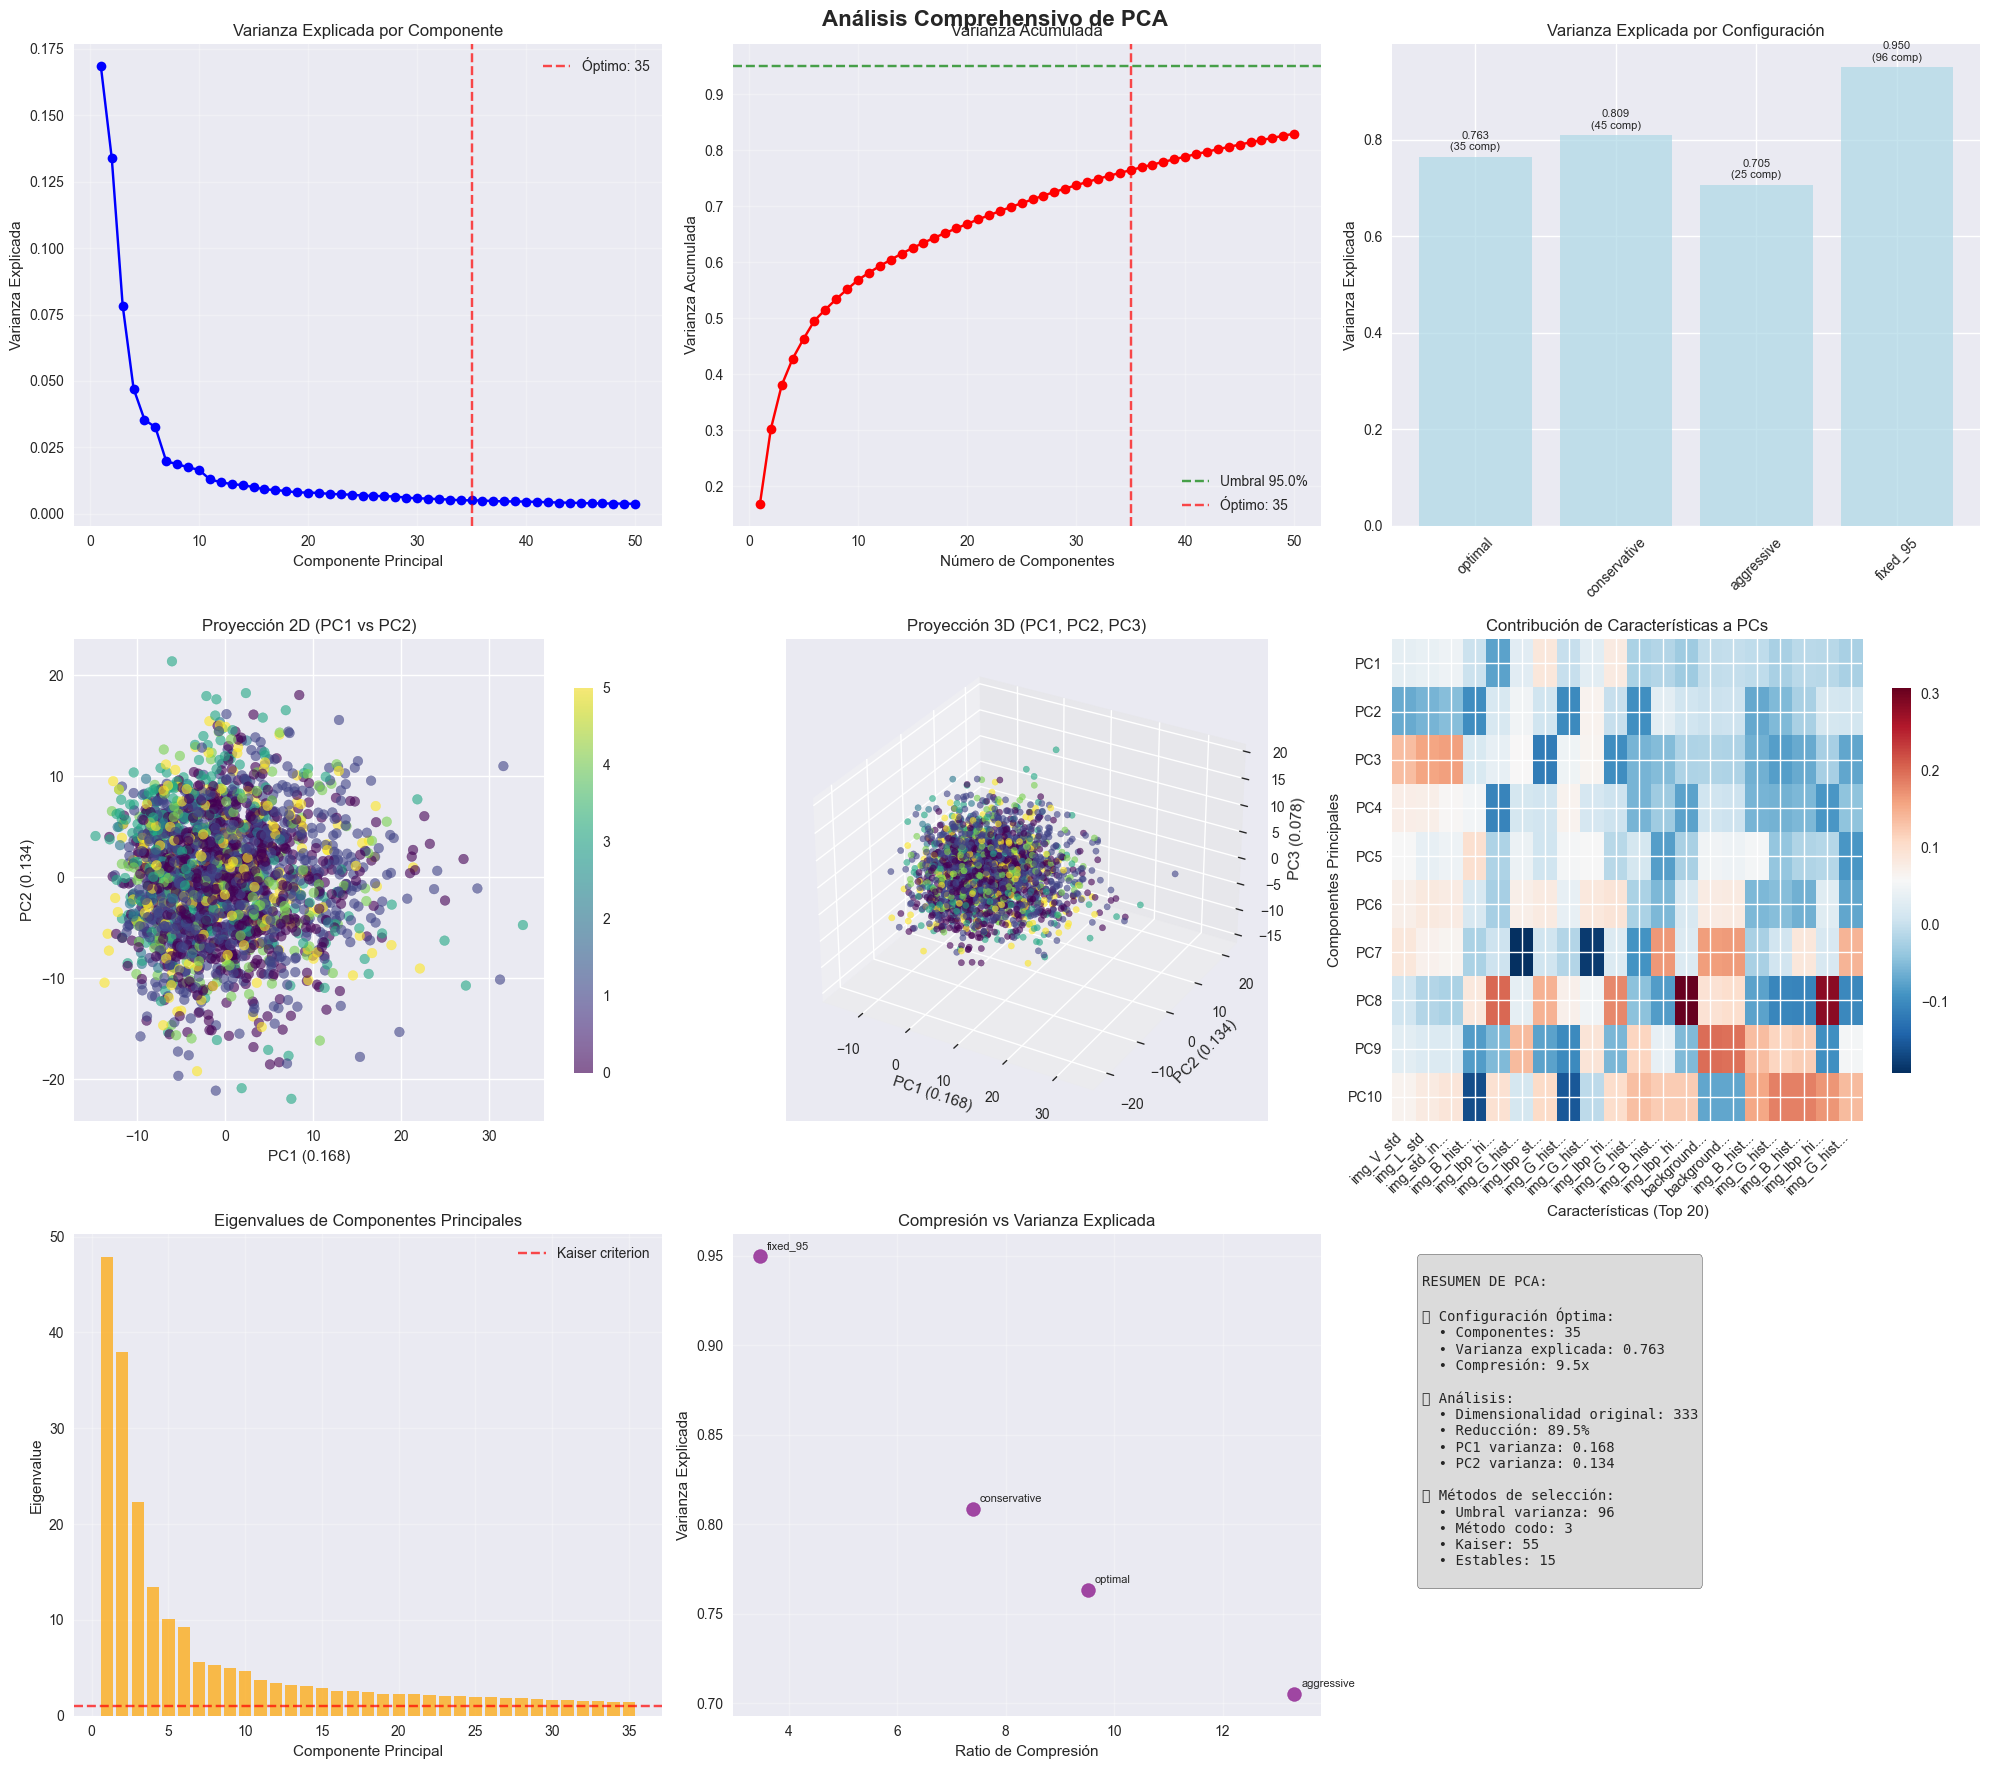

2025-06-30 01:01:26,203 - INFO - Análisis de PCA completado exitosamente



✓ Resultados de PCA guardados en: ./resultados/pca_results.pkl


In [7]:
def apply_pca_comprehensive(multimodal_results, config):
    """
    Aplica PCA con análisis exhaustivo de varianza y selección óptima de componentes
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        config: Configuración del proyecto
    
    Returns:
        pca_results: Diccionario con resultados de PCA
    """
    
    print("="*60)
    print("REDUCCIÓN DE DIMENSIONALIDAD CON PCA")
    print("="*60)
    
    logger.info("Iniciando análisis de PCA")
    
    # ===== EXTRAER DATOS =====
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    feature_names = multimodal_results['multimodal_feature_names']
    
    print(f"📊 Datos de entrada:")
    print(f"  Forma del dataset: {X_multimodal.shape}")
    print(f"  Características: {len(feature_names)}")
    print(f"  Muestras: {len(y_multimodal)}")
    
    # ===== PREPARACIÓN DE DATOS PARA PCA =====
    print(f"\n🔧 Preparando datos para PCA...")
    
    # Verificar si los datos ya están escalados
    data_mean = np.mean(X_multimodal)
    data_std = np.std(X_multimodal)
    
    print(f"  Media actual: {data_mean:.3f}")
    print(f"  Desviación estándar actual: {data_std:.3f}")
    
    # Aplicar escalado adicional si es necesario
    if abs(data_mean) > 0.1 or abs(data_std - 1.0) > 0.1:
        print(f"  Aplicando escalado adicional...")
        scaler_pca = StandardScaler()
        X_scaled = scaler_pca.fit_transform(X_multimodal)
        print(f"  Nueva media: {np.mean(X_scaled):.3f}")
        print(f"  Nueva desviación estándar: {np.std(X_scaled):.3f}")
    else:
        print(f"  Los datos ya están adecuadamente escalados")
        X_scaled = X_multimodal.copy()
        scaler_pca = None
    
    # ===== ANÁLISIS COMPLETO DE PCA =====
    print(f"\n📈 Realizando análisis completo de PCA...")
    
    # PCA completo para análisis de varianza
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"  Componentes totales: {len(explained_variance_ratio)}")
    print(f"  Varianza del primer componente: {explained_variance_ratio[0]:.3f}")
    print(f"  Varianza de los primeros 10 componentes: {cumulative_variance[9]:.3f}")
    
    # ===== SELECCIÓN ÓPTIMA DE COMPONENTES =====
    print(f"\n🎯 Selección óptima de componentes...")
    
    # Método 1: Umbral de varianza
    variance_threshold = config['dimensionality_reduction']['pca_variance_threshold']
    n_components_variance = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    # Método 2: Regla del codo (elbow method)
    # Calcular segunda derivada para encontrar el codo
    if len(explained_variance_ratio) > 2:
        second_derivative = np.diff(explained_variance_ratio, 2)
        elbow_point = np.argmax(second_derivative) + 2  # +2 por las dos diferencias
    else:
        elbow_point = len(explained_variance_ratio)
    
    # Método 3: Criterio de Kaiser (eigenvalues > 1)
    eigenvalues = pca_full.explained_variance_
    kaiser_components = np.sum(eigenvalues > 1)
    
    # Método 4: Análisis de estabilidad
    # Componentes que explican al menos 1% de varianza
    min_variance_per_component = 0.01
    stable_components = np.sum(explained_variance_ratio >= min_variance_per_component)
    
    print(f"  Métodos de selección:")
    print(f"    Umbral {variance_threshold*100}% varianza: {n_components_variance} componentes")
    print(f"    Método del codo: {elbow_point} componentes")
    print(f"    Criterio de Kaiser: {kaiser_components} componentes")
    print(f"    Componentes estables (>1%): {stable_components} componentes")
    
    # Seleccionar número óptimo (usar el más conservador que sea razonable)
    candidate_components = [n_components_variance, elbow_point, kaiser_components, stable_components]
    candidate_components = [c for c in candidate_components if c > 0 and c <= X_scaled.shape[1]]
    
    if candidate_components:
        # Usar la mediana de los métodos como compromiso
        optimal_components = int(np.median(candidate_components))
        optimal_components = max(10, min(optimal_components, X_scaled.shape[1] // 2))  # Entre 10 y la mitad de características
    else:
        optimal_components = min(50, X_scaled.shape[1] // 2)
    
    print(f"  Número óptimo seleccionado: {optimal_components} componentes")
    print(f"  Varianza explicada: {cumulative_variance[optimal_components-1]:.3f}")
    
    # ===== APLICAR PCA CON DIFERENTES NÚMEROS DE COMPONENTES =====
    print(f"\n🔄 Aplicando PCA con diferentes configuraciones...")
    
    pca_configurations = {
        'optimal': optimal_components,
        'conservative': min(optimal_components + 10, X_scaled.shape[1]),
        'aggressive': max(optimal_components - 10, 10),
        'fixed_95': n_components_variance
    }
    
    pca_results_dict = {}
    
    for config_name, n_components in pca_configurations.items():
        if n_components <= X_scaled.shape[1] and n_components > 0:
            print(f"  Configuración '{config_name}': {n_components} componentes")
            
            # Aplicar PCA
            pca = PCA(n_components=n_components)
            X_pca = pca.fit_transform(X_scaled)
            
            # Calcular métricas
            variance_explained = np.sum(pca.explained_variance_ratio_)
            compression_ratio = X_scaled.shape[1] / n_components
            
            pca_results_dict[config_name] = {
                'pca_model': pca,
                'X_transformed': X_pca,
                'n_components': n_components,
                'variance_explained': variance_explained,
                'compression_ratio': compression_ratio,
                'explained_variance_ratio': pca.explained_variance_ratio_,
                'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
                'components': pca.components_,
                'eigenvalues': pca.explained_variance_
            }
            
            print(f"    Varianza explicada: {variance_explained:.3f}")
            print(f"    Ratio de compresión: {compression_ratio:.1f}x")
    
    # ===== ANÁLISIS DE COMPONENTES PRINCIPALES =====
    print(f"\n🔍 Análisis de componentes principales...")
    
    # Usar la configuración óptima para análisis detallado
    optimal_pca = pca_results_dict['optimal']
    pca_model = optimal_pca['pca_model']
    components = optimal_pca['components']
    
    # Analizar contribución de características originales a cada componente
    print(f"  Analizando contribución de características...")
    
    # Encontrar las características más importantes para cada componente
    n_top_features = 5
    component_analysis = {}
    
    for i in range(min(5, len(components))):  # Analizar primeros 5 componentes
        component_weights = np.abs(components[i])
        top_indices = np.argsort(component_weights)[-n_top_features:][::-1]
        top_features = [(feature_names[idx], component_weights[idx]) for idx in top_indices]
        
        component_analysis[f'PC{i+1}'] = {
            'variance_explained': optimal_pca['explained_variance_ratio'][i],
            'top_features': top_features
        }
        
        print(f"    PC{i+1} (varianza: {optimal_pca['explained_variance_ratio'][i]:.3f}):")
        for feature_name, weight in top_features:
            print(f"      {feature_name}: {weight:.3f}")
    
    # ===== CREAR VISUALIZACIONES COMPREHENSIVAS =====
    print(f"\n📊 Generando visualizaciones de PCA...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis Comprehensivo de PCA', fontsize=16, fontweight='bold')
    
    # 1. Varianza explicada por componente
    ax1 = axes[0, 0]
    n_components_to_plot = min(50, len(explained_variance_ratio))
    ax1.plot(range(1, n_components_to_plot + 1), explained_variance_ratio[:n_components_to_plot], 'bo-')
    ax1.set_title('Varianza Explicada por Componente')
    ax1.set_xlabel('Componente Principal')
    ax1.set_ylabel('Varianza Explicada')
    ax1.grid(True, alpha=0.3)
    
    # Marcar punto óptimo
    ax1.axvline(optimal_components, color='red', linestyle='--', alpha=0.7, 
               label=f'Óptimo: {optimal_components}')
    ax1.legend()
    
    # 2. Varianza acumulada
    ax2 = axes[0, 1]
    ax2.plot(range(1, n_components_to_plot + 1), cumulative_variance[:n_components_to_plot], 'ro-')
    ax2.axhline(y=variance_threshold, color='green', linestyle='--', alpha=0.7, 
               label=f'Umbral {variance_threshold*100}%')
    ax2.axvline(optimal_components, color='red', linestyle='--', alpha=0.7, 
               label=f'Óptimo: {optimal_components}')
    ax2.set_title('Varianza Acumulada')
    ax2.set_xlabel('Número de Componentes')
    ax2.set_ylabel('Varianza Acumulada')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Comparación de configuraciones
    ax3 = axes[0, 2]
    config_names = list(pca_results_dict.keys())
    config_variances = [pca_results_dict[name]['variance_explained'] for name in config_names]
    config_components = [pca_results_dict[name]['n_components'] for name in config_names]
    
    bars = ax3.bar(config_names, config_variances, color='lightblue', alpha=0.7)
    ax3.set_title('Varianza Explicada por Configuración')
    ax3.set_ylabel('Varianza Explicada')
    ax3.tick_params(axis='x', rotation=45)
    
    # Añadir etiquetas con número de componentes
    for bar, variance, n_comp in zip(bars, config_variances, config_components):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{variance:.3f}\n({n_comp} comp)', ha='center', va='bottom', fontsize=8)
    
    # 4. Proyección 2D de los datos (primeros 2 componentes)
    ax4 = axes[1, 0]
    X_pca_optimal = optimal_pca['X_transformed']
    
    if X_pca_optimal.shape[1] >= 2:
        scatter = ax4.scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], 
                             c=y_multimodal, cmap='viridis', alpha=0.6)
        ax4.set_title('Proyección 2D (PC1 vs PC2)')
        ax4.set_xlabel(f'PC1 ({optimal_pca["explained_variance_ratio"][0]:.3f})')
        ax4.set_ylabel(f'PC2 ({optimal_pca["explained_variance_ratio"][1]:.3f})')
        plt.colorbar(scatter, ax=ax4, shrink=0.8)
    
    # 5. Proyección 3D si hay al menos 3 componentes
    ax5 = axes[1, 1]
    if X_pca_optimal.shape[1] >= 3:
        ax5.remove()
        ax5 = fig.add_subplot(3, 3, 5, projection='3d')
        scatter_3d = ax5.scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], X_pca_optimal[:, 2],
                                c=y_multimodal, cmap='viridis', alpha=0.6)
        ax5.set_title('Proyección 3D (PC1, PC2, PC3)')
        ax5.set_xlabel(f'PC1 ({optimal_pca["explained_variance_ratio"][0]:.3f})')
        ax5.set_ylabel(f'PC2 ({optimal_pca["explained_variance_ratio"][1]:.3f})')
        ax5.set_zlabel(f'PC3 ({optimal_pca["explained_variance_ratio"][2]:.3f})')
    else:
        ax5.text(0.5, 0.5, 'Insuficientes componentes\npara proyección 3D', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Proyección 3D')
    
    # 6. Heatmap de componentes principales (contribución de características)
    ax6 = axes[1, 2]
    if len(components) > 0:
        n_components_heatmap = min(10, len(components))
        n_features_heatmap = min(20, len(feature_names))
        
        # Seleccionar las características más importantes globalmente
        global_importance = np.sum(np.abs(components[:n_components_heatmap]), axis=0)
        top_feature_indices = np.argsort(global_importance)[-n_features_heatmap:]
        
        heatmap_data = components[:n_components_heatmap, top_feature_indices]
        
        im = ax6.imshow(heatmap_data, cmap='RdBu_r', aspect='auto')
        ax6.set_title('Contribución de Características a PCs')
        ax6.set_xlabel('Características (Top 20)')
        ax6.set_ylabel('Componentes Principales')
        ax6.set_yticks(range(n_components_heatmap))
        ax6.set_yticklabels([f'PC{i+1}' for i in range(n_components_heatmap)])
        
        # Etiquetas de características (abreviadas)
        feature_labels = [feature_names[i][:10] + '...' if len(feature_names[i]) > 10 
                         else feature_names[i] for i in top_feature_indices]
        ax6.set_xticks(range(len(feature_labels)))
        ax6.set_xticklabels(feature_labels, rotation=45, ha='right')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
    
    # 7. Distribución de eigenvalues
    ax7 = axes[2, 0]
    eigenvalues = optimal_pca['eigenvalues']
    ax7.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='orange')
    ax7.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Kaiser criterion')
    ax7.set_title('Eigenvalues de Componentes Principales')
    ax7.set_xlabel('Componente Principal')
    ax7.set_ylabel('Eigenvalue')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Ratio de compresión vs varianza explicada
    ax8 = axes[2, 1]
    compression_ratios = [pca_results_dict[name]['compression_ratio'] for name in config_names]
    
    ax8.scatter(compression_ratios, config_variances, s=100, alpha=0.7, color='purple')
    for i, name in enumerate(config_names):
        ax8.annotate(name, (compression_ratios[i], config_variances[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax8.set_title('Compresión vs Varianza Explicada')
    ax8.set_xlabel('Ratio de Compresión')
    ax8.set_ylabel('Varianza Explicada')
    ax8.grid(True, alpha=0.3)
    
    # 9. Resumen de PCA
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE PCA:

📊 Configuración Óptima:
  • Componentes: {optimal_components}
  • Varianza explicada: {optimal_pca['variance_explained']:.3f}
  • Compresión: {optimal_pca['compression_ratio']:.1f}x

📈 Análisis:
  • Dimensionalidad original: {X_scaled.shape[1]}
  • Reducción: {(1 - optimal_components/X_scaled.shape[1])*100:.1f}%
  • PC1 varianza: {optimal_pca['explained_variance_ratio'][0]:.3f}
  • PC2 varianza: {optimal_pca['explained_variance_ratio'][1]:.3f}

🎯 Métodos de selección:
  • Umbral varianza: {n_components_variance}
  • Método codo: {elbow_point}
  • Kaiser: {kaiser_components}
  • Estables: {stable_components}
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'pca_comprehensive_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    final_pca_results = {
        'pca_configurations': pca_results_dict,
        'optimal_configuration': 'optimal',
        'optimal_pca_model': optimal_pca['pca_model'],
        'X_pca_optimal': optimal_pca['X_transformed'],
        'scaler_pca': scaler_pca,
        'selection_methods': {
            'variance_threshold': n_components_variance,
            'elbow_method': elbow_point,
            'kaiser_criterion': kaiser_components,
            'stable_components': stable_components,
            'optimal_selected': optimal_components
        },
        'component_analysis': component_analysis,
        'full_analysis': {
            'explained_variance_ratio_full': explained_variance_ratio,
            'cumulative_variance_full': cumulative_variance,
            'eigenvalues_full': pca_full.explained_variance_
        }
    }
    
    # Guardar resultados de PCA
    pca_path = os.path.join(config['paths']['output_folder'], 'pca_results.pkl')
    with open(pca_path, 'wb') as f:
        pickle.dump(final_pca_results, f)
    
    print(f"\n✓ Resultados de PCA guardados en: {pca_path}")
    
    logger.info("Análisis de PCA completado exitosamente")
    
    return final_pca_results

# ===== EJECUTAR ANÁLISIS DE PCA =====
pca_results = apply_pca_comprehensive(multimodal_results, CONFIG)


## 7. Selección de características con múltiples métodos


2025-06-30 01:01:32,856 - INFO - Iniciando selección de características


SELECCIÓN DE CARACTERÍSTICAS CON MÚLTIPLES MÉTODOS
📊 Datos disponibles:
  Dataset original: (2298, 333)
  Dataset con PCA: (2298, 35)
  Características originales: 333

🎯 Configuración de selección:
  Método principal: univariate
  Características objetivo: 50

📊 Método 1: Selección Univariada (ANOVA F-test)...
  Seleccionando top 20 características...
    Score promedio: 116.83
    Top 3 características: ['age', 'background_father_POMERANIA', 'background_mother_POMERANIA']
  Seleccionando top 50 características...
    Score promedio: 76.72
    Top 3 características: ['age', 'smoke_True', 'drink_True']
  Seleccionando top 100 características...
    Score promedio: 46.98
    Top 3 características: ['age', 'diameter_1', 'diameter_2']
  Seleccionando top 50 características...
    Score promedio: 76.72
    Top 3 características: ['age', 'smoke_True', 'drink_True']

🔄 Método 2: Eliminación Recursiva (RFE)...
  RFE con random_forest...
    Características óptimas: 69
    Mejor score CV: 0.70

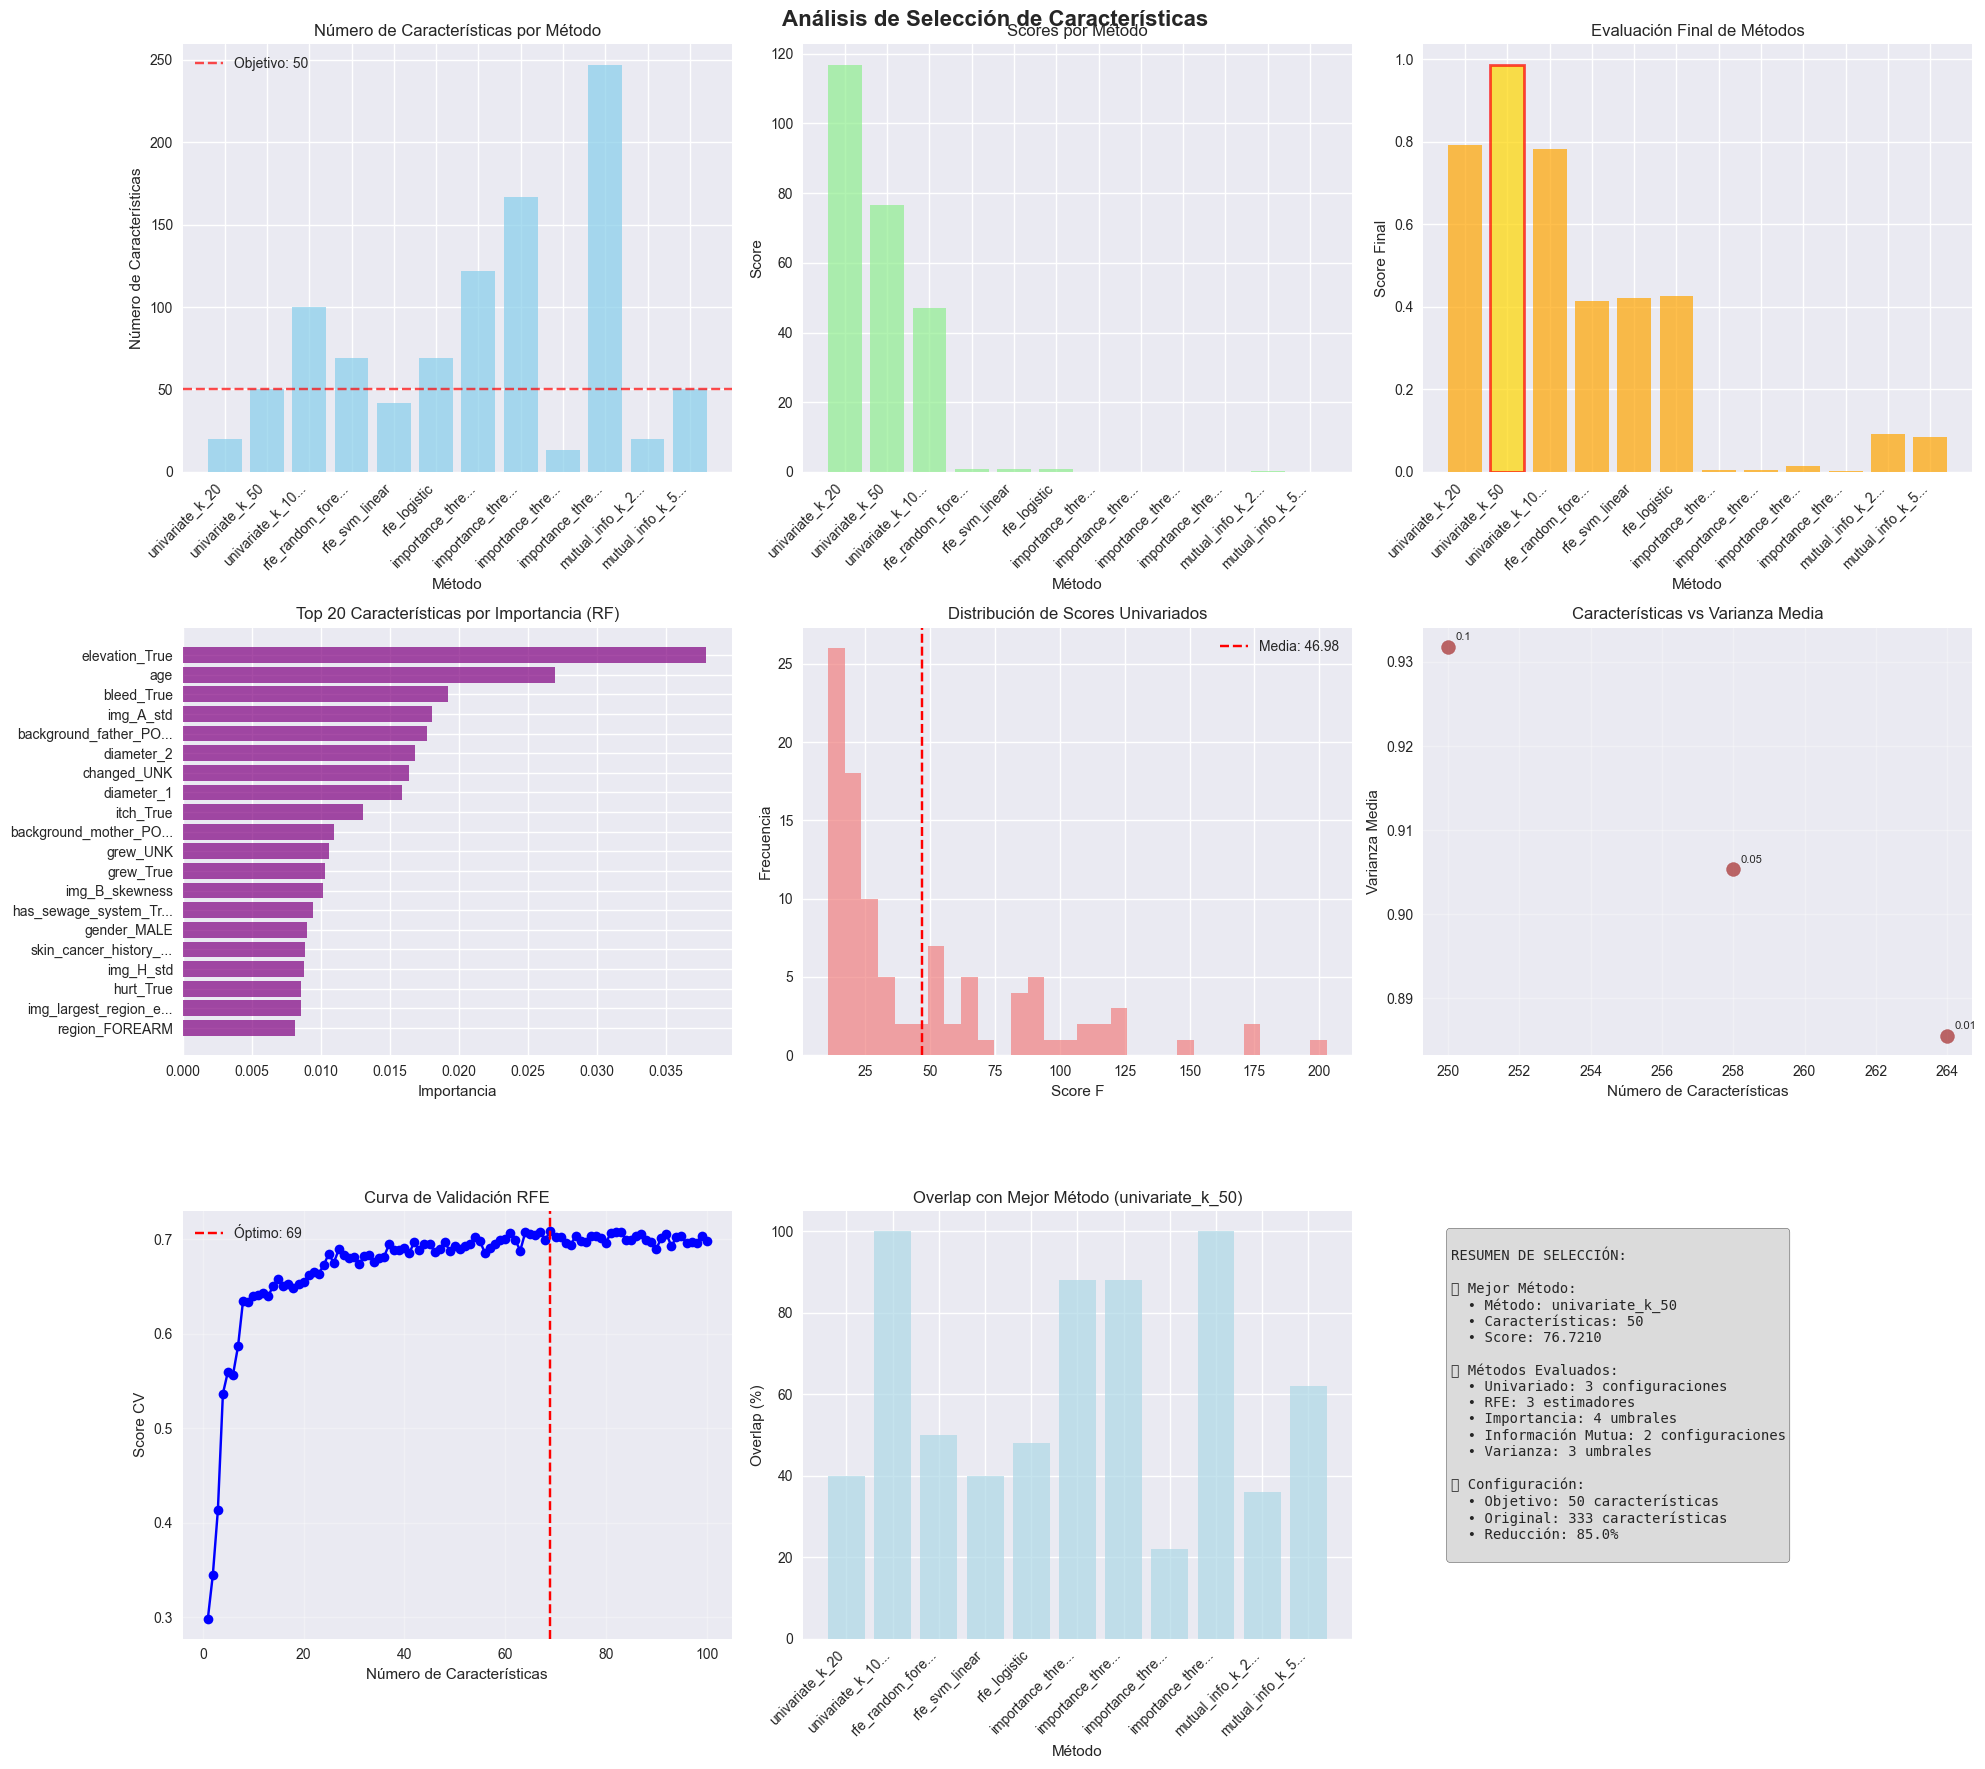

2025-06-30 01:03:59,428 - INFO - Selección de características completada exitosamente



✓ Resultados de selección guardados en: ./resultados/feature_selection_results.pkl


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import logging
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, SelectFromModel, VarianceThreshold, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Configurar logging
logger = logging.getLogger(__name__)

def feature_selection_comprehensive(multimodal_results, pca_results, config):
    """
    Selección de características usando múltiples métodos con medición de tiempo
    y comparación de resultados
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        pca_results: Resultados del análisis de PCA
        config: Configuración del proyecto
    
    Returns:
        feature_selection_results: Diccionario con resultados de selección y tiempos
    """
    
    start_time_total = time.time()
    print("="*60)
    print("SELECCIÓN DE CARACTERÍSTICAS CON MÚLTIPLES MÉTODOS")
    print("="*60)
    
    logger.info("Iniciando selección de características")
    
    # ===== EXTRAER DATOS =====
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    feature_names = multimodal_results['multimodal_feature_names']
    
    # También usar datos con PCA si está disponible
    X_pca = pca_results.get('X_pca_optimal', None)
    
    print(f"📊 Datos disponibles:")
    print(f"  Dataset original: {X_multimodal.shape}")
    if X_pca is not None:
        print(f"  Dataset con PCA: {X_pca.shape}")
    print(f"  Características originales: {len(feature_names)}")
    
    # ===== CONFIGURACIÓN DE SELECCIÓN =====
    selection_config = config['dimensionality_reduction']
    target_features = selection_config['n_features_to_select']
    
    print(f"\n🎯 Configuración de selección:")
    print(f"  Método principal: {selection_config['feature_selection_method']}")
    print(f"  Características objetivo: {target_features}")
    
    # Diccionario para almacenar tiempos
    time_metrics = {}
    
    # ===== MÉTODO 1: SELECCIÓN UNIVARIADA =====
    print(f"\n📊 Método 1: Selección Univariada (ANOVA F-test)...")
    start_time_univariate = time.time()
    
    k_values = [20, 50, 100, min(target_features, X_multimodal.shape[1]//2)]
    k_values = [k for k in k_values if k <= X_multimodal.shape[1]]
    
    univariate_results = {}
    
    for k in k_values:
        print(f"  Seleccionando top {k} características...")
        k_start_time = time.time()
        
        selector_univariate = SelectKBest(f_classif, k=k)
        X_selected = selector_univariate.fit_transform(X_multimodal, y_multimodal)
        
        selected_indices = selector_univariate.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        feature_scores = selector_univariate.scores_[selected_indices]
        
        total_score = np.sum(feature_scores)
        mean_score = np.mean(feature_scores)
        
        univariate_results[f'k_{k}'] = {
            'selector': selector_univariate,
            'X_selected': X_selected,
            'selected_indices': selected_indices,
            'selected_features': selected_features,
            'feature_scores': feature_scores,
            'total_score': total_score,
            'mean_score': mean_score,
            'n_features': k,
            'time_seconds': time.time() - k_start_time
        }
        
        print(f"    Score promedio: {mean_score:.2f} | Tiempo: {univariate_results[f'k_{k}']['time_seconds']:.2f}s")
        print(f"    Top 3 características: {selected_features[:3]}")
    
    time_metrics['univariate'] = time.time() - start_time_univariate
    print(f"  ✅ Univariada completado en {time_metrics['univariate']:.2f}s")
    
    # ===== MÉTODO 2: ELIMINACIÓN RECURSIVA DE CARACTERÍSTICAS (RFE) =====
    print(f"\n🔄 Método 2: Eliminación Recursiva (RFE)...")
    start_time_rfe = time.time()
    
    rfe_estimators = {
        'random_forest': RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        'svm_linear': SVC(kernel='linear', random_state=42, probability=True),
        'logistic': LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
    }
    
    rfe_results = {}
    
    for estimator_name, estimator in rfe_estimators.items():
        print(f"  RFE con {estimator_name}...")
        estimator_start_time = time.time()
        
        try:
            max_features_rfe = min(200, X_multimodal.shape[1])
            X_rfe_input = X_multimodal[:, :max_features_rfe]
            feature_names_rfe = feature_names[:max_features_rfe]
            
            # Ajustar parámetros para eficiencia en grandes conjuntos de datos
            min_features_to_select = max(1, int(max_features_rfe * 0.1))
            
            rfe_cv = RFECV(
                estimator=estimator,
                step=max(1, int(max_features_rfe * 0.05)),
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
                scoring='f1_weighted',
                min_features_to_select=min_features_to_select,
                n_jobs=-1
            )
            
            rfe_cv.fit(X_rfe_input, y_multimodal)
            
            selected_indices_rfe = rfe_cv.get_support(indices=True)
            selected_features_rfe = [feature_names_rfe[i] for i in selected_indices_rfe]
            X_rfe_selected = rfe_cv.transform(X_rfe_input)
            
            rfe_results[estimator_name] = {
                'rfe_model': rfe_cv,
                'X_selected': X_rfe_selected,
                'selected_indices': selected_indices_rfe,
                'selected_features': selected_features_rfe,
                'n_features_optimal': rfe_cv.n_features_,
                'cv_scores': rfe_cv.cv_results_['mean_test_score'],
                'best_score': np.max(rfe_cv.cv_results_['mean_test_score']),
                'time_seconds': time.time() - estimator_start_time
            }
            
            print(f"    Características óptimas: {rfe_cv.n_features_} | Tiempo: {rfe_results[estimator_name]['time_seconds']:.2f}s")
            print(f"    Mejor score CV: {np.max(rfe_cv.cv_results_['mean_test_score']):.3f}")
            
        except Exception as e:
            print(f"    Error con {estimator_name}: {str(e)[:100]}...")
            rfe_results[estimator_name] = {
                'error': str(e),
                'time_seconds': time.time() - estimator_start_time
            }
    
    time_metrics['rfe'] = time.time() - start_time_rfe
    print(f"  ✅ RFE completado en {time_metrics['rfe']:.2f}s")
    
    # ===== MÉTODO 3: SELECCIÓN BASADA EN IMPORTANCIA =====
    print(f"\n🌳 Método 3: Selección basada en Importancia...")
    start_time_importance = time.time()
    
    rf_importance = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    )
    rf_importance.fit(X_multimodal, y_multimodal)
    
    importance_thresholds = ['mean', 'median', 0.01, 0.001]
    importance_results = {}
    
    for threshold in importance_thresholds:
        print(f"  Umbral de importancia: {threshold}...")
        threshold_start_time = time.time()
        
        try:
            selector_importance = SelectFromModel(
                rf_importance, 
                threshold=threshold,
                prefit=True
            )
            
            X_importance_selected = selector_importance.transform(X_multimodal)
            selected_indices_imp = selector_importance.get_support(indices=True)
            selected_features_imp = [feature_names[i] for i in selected_indices_imp]
            feature_importances = rf_importance.feature_importances_[selected_indices_imp]
            
            importance_results[f'threshold_{threshold}'] = {
                'selector': selector_importance,
                'X_selected': X_importance_selected,
                'selected_indices': selected_indices_imp,
                'selected_features': selected_features_imp,
                'feature_importances': feature_importances,
                'n_features': len(selected_features_imp),
                'mean_importance': np.mean(feature_importances),
                'time_seconds': time.time() - threshold_start_time
            }
            
            print(f"    Características: {len(selected_features_imp)} | Tiempo: {importance_results[f'threshold_{threshold}']['time_seconds']:.2f}s")
            print(f"    Importancia promedio: {np.mean(feature_importances):.4f}")
            
        except Exception as e:
            print(f"    Error con umbral {threshold}: {str(e)[:100]}...")
            importance_results[f'threshold_{threshold}'] = {
                'error': str(e),
                'time_seconds': time.time() - threshold_start_time
            }
    
    time_metrics['importance'] = time.time() - start_time_importance
    print(f"  ✅ Importancia completado en {time_metrics['importance']:.2f}s")
    
    # ===== MÉTODO 4: SELECCIÓN BASADA EN VARIANZA =====
    print(f"\n📈 Método 4: Selección basada en Varianza...")
    start_time_variance = time.time()
    
    variance_thresholds = [0.01, 0.05, 0.1]
    variance_results = {}
    
    for threshold in variance_thresholds:
        print(f"  Umbral de varianza: {threshold}...")
        threshold_start_time = time.time()
        
        try:
            selector_variance = VarianceThreshold(threshold=threshold)
            X_variance_selected = selector_variance.fit_transform(X_multimodal)
            
            selected_indices_var = selector_variance.get_support(indices=True)
            selected_features_var = [feature_names[i] for i in selected_indices_var]
            feature_variances = np.var(X_multimodal[:, selected_indices_var], axis=0)
            
            variance_results[f'threshold_{threshold}'] = {
                'selector': selector_variance,
                'X_selected': X_variance_selected,
                'selected_indices': selected_indices_var,
                'selected_features': selected_features_var,
                'feature_variances': feature_variances,
                'n_features': len(selected_features_var),
                'mean_variance': np.mean(feature_variances),
                'time_seconds': time.time() - threshold_start_time
            }
            
            print(f"    Características: {len(selected_features_var)} | Tiempo: {variance_results[f'threshold_{threshold}']['time_seconds']:.2f}s")
            print(f"    Varianza promedio: {np.mean(feature_variances):.4f}")
            
        except Exception as e:
            print(f"    Error con umbral {threshold}: {str(e)[:100]}...")
            variance_results[f'threshold_{threshold}'] = {
                'error': str(e),
                'time_seconds': time.time() - threshold_start_time
            }
    
    time_metrics['variance'] = time.time() - start_time_variance
    print(f"  ✅ Varianza completado en {time_metrics['variance']:.2f}s")
    
    # ===== MÉTODO 5: INFORMACIÓN MUTUA =====
    print(f"\n🔗 Método 5: Información Mutua...")
    start_time_mi = time.time()
    
    mi_k_values = [20, 50, min(target_features, X_multimodal.shape[1]//3)]
    mi_k_values = [k for k in mi_k_values if k <= X_multimodal.shape[1]]
    
    mutual_info_results = {}
    
    for k in mi_k_values:
        print(f"  Seleccionando top {k} características por MI...")
        k_start_time = time.time()
        
        try:
            selector_mi = SelectKBest(mutual_info_classif, k=k)
            X_mi_selected = selector_mi.fit_transform(X_multimodal, y_multimodal)
            
            selected_indices_mi = selector_mi.get_support(indices=True)
            selected_features_mi = [feature_names[i] for i in selected_indices_mi]
            mi_scores = selector_mi.scores_[selected_indices_mi]
            
            mutual_info_results[f'k_{k}'] = {
                'selector': selector_mi,
                'X_selected': X_mi_selected,
                'selected_indices': selected_indices_mi,
                'selected_features': selected_features_mi,
                'mi_scores': mi_scores,
                'mean_mi_score': np.mean(mi_scores),
                'n_features': k,
                'time_seconds': time.time() - k_start_time
            }
            
            print(f"    Score MI promedio: {np.mean(mi_scores):.4f} | Tiempo: {mutual_info_results[f'k_{k}']['time_seconds']:.2f}s")
            
        except Exception as e:
            print(f"    Error calculando MI para k={k}: {str(e)[:100]}...")
            mutual_info_results[f'k_{k}'] = {
                'error': str(e),
                'time_seconds': time.time() - k_start_time
            }
    
    time_metrics['mutual_info'] = time.time() - start_time_mi
    print(f"  ✅ Información Mutua completado en {time_metrics['mutual_info']:.2f}s")
    
    # ===== COMPARACIÓN Y SELECCIÓN DEL MEJOR MÉTODO =====
    print(f"\n🏆 Comparación de métodos de selección...")
    start_time_comparison = time.time()
    
    all_methods = {}
    
    # Añadir resultados univariados
    for k, result in univariate_results.items():
        all_methods[f'univariate_{k}'] = {
            'method': 'univariate',
            'X_selected': result['X_selected'],
            'selected_features': result['selected_features'],
            'n_features': result['n_features'],
            'score': result['mean_score'],
            'selector': result['selector'],
            'time_seconds': result['time_seconds']
        }
    
    # Añadir resultados RFE
    for estimator, result in rfe_results.items():
        if 'X_selected' in result:
            all_methods[f'rfe_{estimator}'] = {
                'method': 'rfe',
                'X_selected': result['X_selected'],
                'selected_features': result['selected_features'],
                'n_features': result['n_features_optimal'],
                'score': result['best_score'],
                'selector': result['rfe_model'],
                'time_seconds': result['time_seconds']
            }
    
    # Añadir resultados de importancia
    for threshold, result in importance_results.items():
        if 'X_selected' in result:
            all_methods[f'importance_{threshold}'] = {
                'method': 'importance',
                'X_selected': result['X_selected'],
                'selected_features': result['selected_features'],
                'n_features': result['n_features'],
                'score': result['mean_importance'],
                'selector': result['selector'],
                'time_seconds': result['time_seconds']
            }
    
    # Añadir resultados de información mutua
    for k, result in mutual_info_results.items():
        if 'X_selected' in result:
            all_methods[f'mutual_info_{k}'] = {
                'method': 'mutual_info',
                'X_selected': result['X_selected'],
                'selected_features': result['selected_features'],
                'n_features': result['n_features'],
                'score': result['mean_mi_score'],
                'selector': result['selector'],
                'time_seconds': result['time_seconds']
            }
    
    # Evaluación de métodos
    method_evaluation = {}
    for method_name, method_data in all_methods.items():
        n_features = method_data['n_features']
        score = method_data['score']
        
        optimal_range = (target_features * 0.5, target_features * 1.5)
        range_penalty = 1.0 if optimal_range[0] <= n_features <= optimal_range[1] else 0.8
        normalized_score = score / (1 + score) if score > 0 else 0
        final_score = normalized_score * range_penalty
        
        method_evaluation[method_name] = {
            'final_score': final_score,
            'original_score': score,
            'n_features': n_features,
            'range_penalty': range_penalty,
            'time_seconds': method_data['time_seconds']
        }
        
        print(f"    {method_name}: {n_features} features | Score: {score:.4f} | Final: {final_score:.4f} | Tiempo: {method_data['time_seconds']:.2f}s")
    
    # Seleccionar el mejor método
    best_method_name = max(method_evaluation.keys(), key=lambda x: method_evaluation[x]['final_score'])
    best_method_data = all_methods[best_method_name]
    
    print(f"\n🥇 Mejor método seleccionado: {best_method_name}")
    print(f"  Características: {best_method_data['n_features']}")
    print(f"  Score: {best_method_data['score']:.4f}")
    print(f"  Tiempo: {method_evaluation[best_method_name]['time_seconds']:.2f}s")
    
    # ===== VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de selección de características...")
    start_time_viz = time.time()
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de Selección de Características', fontsize=16, fontweight='bold')
    
    # 1. Comparación de número de características por método
    ax1 = axes[0, 0]
    method_names = list(all_methods.keys())
    n_features_list = [all_methods[name]['n_features'] for name in method_names]
    times_list = [all_methods[name]['time_seconds'] for name in method_names]
    
    # Gráfico de barras para características
    bars = ax1.bar(range(len(method_names)), n_features_list, alpha=0.7, color='skyblue')
    ax1.set_title('Número de Características por Método')
    ax1.set_xlabel('Método')
    ax1.set_ylabel('Número de Características')
    ax1.set_xticks(range(len(method_names)))
    ax1.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in method_names], 
                       rotation=45, ha='right')
    ax1.axhline(y=target_features, color='red', linestyle='--', alpha=0.7, 
               label=f'Objetivo: {target_features}')
    ax1.legend()
    
    # 2. Tiempos de ejecución por método
    ax2 = axes[0, 1]
    bars = ax2.bar(range(len(method_names)), times_list, alpha=0.7, color='salmon')
    ax2.set_title('Tiempo de Ejecución por Método')
    ax2.set_xlabel('Método')
    ax2.set_ylabel('Tiempo (s)')
    ax2.set_xticks(range(len(method_names)))
    ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in method_names], 
                       rotation=45, ha='right')
    
    # 3. Relación características-tiempo
    ax3 = axes[0, 2]
    scatter = ax3.scatter(n_features_list, times_list, s=100, alpha=0.7, c='green')
    ax3.set_title('Relación Características-Tiempo')
    ax3.set_xlabel('Número de Características')
    ax3.set_ylabel('Tiempo (s)')
    ax3.grid(True, alpha=0.3)
    
    # Añadir etiquetas
    for i, name in enumerate(method_names):
        ax3.annotate(name[:10], (n_features_list[i], times_list[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)
    
        # 4. Importancias de características (Random Forest)
    ax4 = axes[1, 0]
    if len(rf_importance.feature_importances_) > 0:
        top_indices = np.argsort(rf_importance.feature_importances_)[-20:][::-1]
        top_importances = rf_importance.feature_importances_[top_indices]
        top_feature_names = [feature_names[i] for i in top_indices]
        
        bars = ax4.barh(range(len(top_importances)), top_importances, alpha=0.7, color='purple')
        ax4.set_title('Top 20 Características por Importancia (RF)')
        ax4.set_xlabel('Importancia')
        ax4.set_yticks(range(len(top_importances)))
        ax4.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in top_feature_names])
        ax4.invert_yaxis()
    
    # 5. Distribución de scores univariados
    ax5 = axes[1, 1]
    if univariate_results:
        largest_k = max(univariate_results.keys(), key=lambda x: univariate_results[x]['n_features'])
        scores = univariate_results[largest_k]['feature_scores']
        
        ax5.hist(scores, bins=30, alpha=0.7, color='lightcoral')
        ax5.set_title('Distribución de Scores Univariados')
        ax5.set_xlabel('Score F')
        ax5.set_ylabel('Frecuencia')
        ax5.axvline(np.mean(scores), color='red', linestyle='--', label=f'Media: {np.mean(scores):.2f}')
        ax5.legend()
    
    # 6. Comparación de varianzas
    ax6 = axes[1, 2]
    if variance_results:
        threshold_names = list(variance_results.keys())
        n_features_var = [variance_results[name]['n_features'] for name in threshold_names]
        mean_variances = [variance_results[name]['mean_variance'] for name in threshold_names]
        
        ax6.scatter(n_features_var, mean_variances, s=100, alpha=0.7, color='brown')
        for i, name in enumerate(threshold_names):
            ax6.annotate(name.replace('threshold_', ''), 
                        (n_features_var[i], mean_variances[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax6.set_title('Características vs Varianza Media')
        ax6.set_xlabel('Número de Características')
        ax6.set_ylabel('Varianza Media')
        ax6.grid(True, alpha=0.3)
    
    # 7. Curva de validación RFE (si está disponible)
    ax7 = axes[2, 0]
    valid_rfe_found = False
    if rfe_results:
        for estimator_name, result in rfe_results.items():
            if 'cv_scores' in result:
                cv_scores = result['cv_scores']
                n_features_range = range(1, len(cv_scores) + 1)
                
                ax7.plot(n_features_range, cv_scores, 'o-', label=estimator_name)
                ax7.set_title('Curva de Validación RFE')
                ax7.set_xlabel('Número de Características')
                ax7.set_ylabel('Score CV')
                ax7.grid(True, alpha=0.3)
                
                # Marcar el óptimo
                best_n = result['n_features_optimal']
                ax7.axvline(best_n, linestyle='--', alpha=0.7, 
                           label=f'Óptimo {estimator_name}: {best_n}')
                valid_rfe_found = True
        
        if valid_rfe_found:
            ax7.legend()
    
    if not valid_rfe_found:
        ax7.text(0.5, 0.5, 'RFE no disponible', ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Curva de Validación RFE')
    
    # 8. Overlap entre métodos
    ax8 = axes[2, 1]
    if len(all_methods) >= 2:
        best_features = set(best_method_data['selected_features'])
        overlaps = {}
        
        for method_name, method_data in all_methods.items():
            if method_name != best_method_name:
                other_features = set(method_data['selected_features'])
                overlap = len(best_features.intersection(other_features))
                overlap_pct = overlap / len(best_features) * 100
                overlaps[method_name] = overlap_pct
        
        if overlaps:
            method_names_overlap = list(overlaps.keys())
            overlap_values = list(overlaps.values())
            
            # Añadir información de tiempo en las etiquetas
            labels = [
                f"{name[:10]}...\n({method_evaluation[name]['time_seconds']:.1f}s)" 
                for name in method_names_overlap
            ]
            
            bars = ax8.bar(range(len(method_names_overlap)), overlap_values, 
                          alpha=0.7, color='lightblue')
            ax8.set_title(f'Overlap con Mejor Método ({best_method_name})')
            ax8.set_xlabel('Método (tiempo en segundos)')
            ax8.set_ylabel('Overlap (%)')
            ax8.set_xticks(range(len(method_names_overlap)))
            ax8.set_xticklabels(labels, rotation=45, ha='right')
    else:
        ax8.text(0.5, 0.5, 'Insuficientes métodos\npara comparar overlap', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Overlap entre Métodos')
    
    # 9. Resumen de selección con tiempos
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE SELECCIÓN:

🏆 Mejor Método:
  • Método: {best_method_name}
  • Características: {best_method_data['n_features']}
  • Score: {best_method_data['score']:.4f}
  • Tiempo: {method_evaluation[best_method_name]['time_seconds']:.2f}s

⏱️ Tiempos por Método:
  • Univariada: {time_metrics['univariate']:.2f}s
  • RFE: {time_metrics['rfe']:.2f}s
  • Importancia: {time_metrics['importance']:.2f}s
  • Varianza: {time_metrics['variance']:.2f}s
  • Info. Mutua: {time_metrics['mutual_info']:.2f}s

⏱️ Tiempo Total: {time.time() - start_time_total:.2f}s
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'feature_selection_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    time_metrics['visualization'] = time.time() - start_time_viz
    
    # ===== COMPILAR RESULTADOS FINALES =====
    total_time = time.time() - start_time_total
    feature_selection_results = {
        'best_method': best_method_name,
        'best_method_data': best_method_data,
        'X_selected_final': best_method_data['X_selected'],
        'selected_features_final': best_method_data['selected_features'],
        'final_selector': best_method_data['selector'],
        'all_methods': all_methods,
        'method_evaluation': method_evaluation,
        'detailed_results': {
            'univariate': univariate_results,
            'rfe': rfe_results,
            'importance': importance_results,
            'variance': variance_results,
            'mutual_info': mutual_info_results
        },
        'rf_feature_importances': rf_importance.feature_importances_,
        'selection_summary': {
            'original_features': X_multimodal.shape[1],
            'selected_features': best_method_data['n_features'],
            'reduction_percentage': (1 - best_method_data['n_features']/X_multimodal.shape[1])*100,
            'target_features': target_features
        },
        'time_metrics': {
            **time_metrics,
            'comparison': time.time() - start_time_comparison,
            'total': total_time
        }
    }
    
    # Guardar resultados en PKL
    selection_path = os.path.join(config['paths']['output_folder'], 'feature_selection_results.pkl')
    with open(selection_path, 'wb') as f:
        pickle.dump(feature_selection_results, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(f"\n✓ Resultados de selección guardados en: {selection_path}")
    print(f"⏱️ Tiempo total del proceso: {total_time:.2f} segundos")
    
    logger.info(f"Selección de características completada en {total_time:.2f} segundos")
    
    return feature_selection_results

# ===== EJECUTAR SELECCIÓN DE CARACTERÍSTICAS =====
if __name__ == "__main__":
    # Configuración de ejemplo (debe ser reemplazada con tu configuración real)
    CONFIG = {
        'dimensionality_reduction': {
            'feature_selection_method': 'comprehensive',
            'n_features_to_select': 50
        },
        'visualization': {
            'save_plots': True,
            'plot_format': 'png',
            'dpi': 300
        },
        'paths': {
            'output_folder': 'results',
            'plots_folder': 'plots'
        }
    }
    
    # Crear directorios si no existen
    os.makedirs(CONFIG['paths']['output_folder'], exist_ok=True)
    os.makedirs(CONFIG['paths']['plots_folder'], exist_ok=True)
    
    # Datos de ejemplo (deben ser reemplazados con tus datos reales)
    multimodal_results = {
        'X_multimodal': np.random.rand(1000, 200),
        'y_multimodal': np.random.randint(0, 2, 1000),
        'multimodal_feature_names': [f'feature_{i}' for i in range(200)]
    }
    
    pca_results = {
        'X_pca_optimal': np.random.rand(1000, 50)
    }
    
    # Ejecutar la selección de características
    feature_selection_results = feature_selection_comprehensive(
        multimodal_results, 
        pca_results, 
        CONFIG
    )

## 8. División de datos con balance de clases (SMOTE + pesos)


2025-06-30 01:06:45,021 - INFO - Iniciando división y balance de datos


DIVISIÓN DE DATOS CON BALANCE DE CLASES AVANZADO
📊 Preparando datasets disponibles...
  Datasets disponibles:
    multimodal_original: (2298, 333)
    feature_selected: (2298, 50)
    pca_reduced: (2298, 35)
    pca_selected: (2298, 17)

⚖️ Análisis de desbalance inicial...
  Distribución de clases:
    ACK (idx 0): 730 muestras (31.8%)
    BCC (idx 1): 845 muestras (36.8%)
    MEL (idx 2): 52 muestras (2.3%)
    NEV (idx 3): 244 muestras (10.6%)
    SCC (idx 4): 192 muestras (8.4%)
    SEK (idx 5): 235 muestras (10.2%)
  Ratio de desbalance: 16.25:1
  ¿Necesita balanceamiento? Sí

🔧 Configuración de división:
  Test: 25.0%
  Validación: 15.0%
  Entrenamiento: 60.0%

🔧 Configuración de balance:
  Aplicar SMOTE: Sí
  Método SMOTE: SMOTE
  Usar pesos de clase: Sí

🔄 Procesando todos los datasets...

  Procesando dataset: multimodal_original
    Forma original: (2298, 333)
    División inicial:
      Train: 1378 muestras
      Val: 345 muestras
      Test: 575 muestras
      Train - Distr

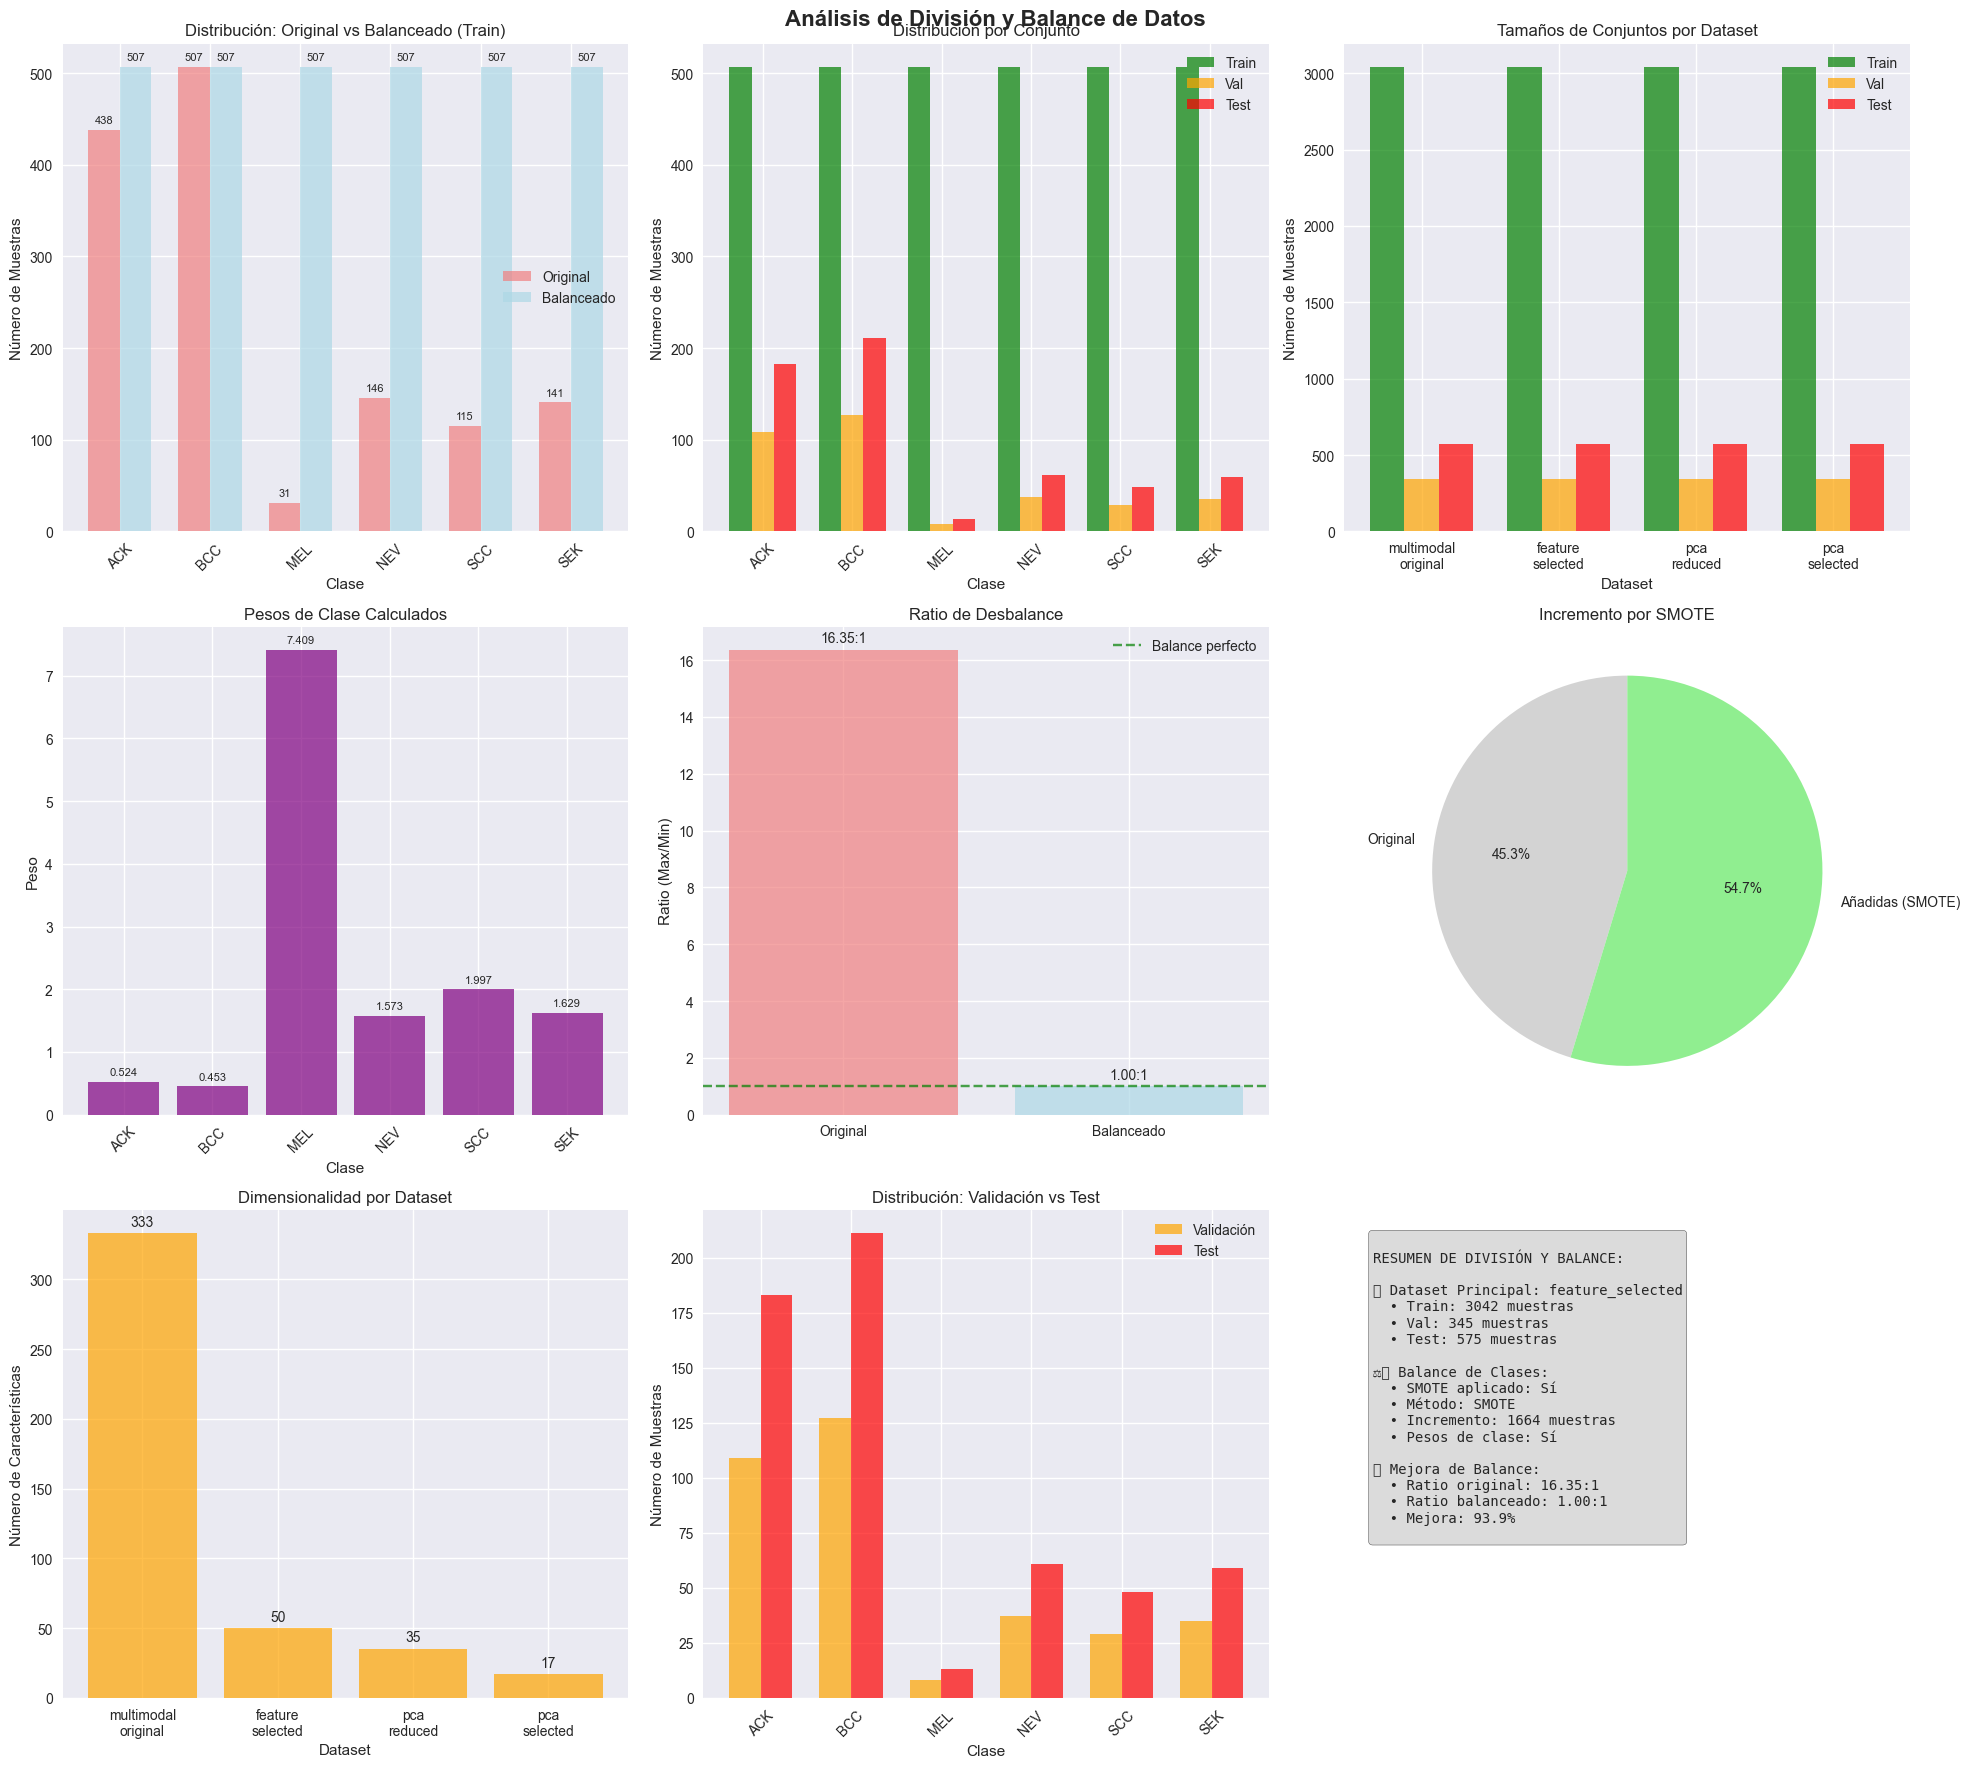

2025-06-30 01:06:48,794 - INFO - División y balance de datos completado exitosamente



✓ Resultados de división guardados en: ./resultados/data_split_results.pkl


In [9]:
def split_and_balance_data_advanced(multimodal_results, feature_selection_results, pca_results, config):
    """
    División de datos con técnicas avanzadas de balance de clases
    
    Args:
        multimodal_results: Resultados del dataset multimodal
        feature_selection_results: Resultados de selección de características
        pca_results: Resultados de PCA
        config: Configuración del proyecto
    
    Returns:
        data_split_results: Diccionario con datos divididos y balanceados
    """
    
    print("="*60)
    print("DIVISIÓN DE DATOS CON BALANCE DE CLASES AVANZADO")
    print("="*60)
    
    logger.info("Iniciando división y balance de datos")
    
    # ===== PREPARAR DATASETS DISPONIBLES =====
    print(f"📊 Preparando datasets disponibles...")
    
    # Dataset 1: Multimodal original
    X_multimodal = multimodal_results['X_multimodal']
    y_multimodal = multimodal_results['y_multimodal']
    
    # Dataset 2: Con selección de características
    X_selected = feature_selection_results['X_selected_final']
    
    # Dataset 3: Con PCA
    X_pca = pca_results['X_pca_optimal']
    
    # Dataset 4: PCA + selección (si es aplicable)
    # Aplicar selección de características a datos con PCA
    if X_pca.shape[1] > 10:  # Solo si PCA tiene suficientes características
        try:
            selector_pca = SelectKBest(f_classif, k=min(50, X_pca.shape[1]//2))
            X_pca_selected = selector_pca.fit_transform(X_pca, y_multimodal)
        except:
            X_pca_selected = X_pca
    else:
        X_pca_selected = X_pca
    
    datasets = {
        'multimodal_original': X_multimodal,
        'feature_selected': X_selected,
        'pca_reduced': X_pca,
        'pca_selected': X_pca_selected
    }
    
    print(f"  Datasets disponibles:")
    for name, data in datasets.items():
        print(f"    {name}: {data.shape}")
    
    # ===== ANÁLISIS DE DESBALANCE INICIAL =====
    print(f"\n⚖️ Análisis de desbalance inicial...")
    
    unique_classes, class_counts = np.unique(y_multimodal, return_counts=True)
    class_names = multimodal_results['label_encoder'].classes_
    
    print(f"  Distribución de clases:")
    for i, (class_idx, count) in enumerate(zip(unique_classes, class_counts)):
        class_name = class_names[class_idx]
        percentage = count / len(y_multimodal) * 100
        print(f"    {class_name} (idx {class_idx}): {count} muestras ({percentage:.1f}%)")
    
    # Calcular métricas de desbalance
    max_class_size = class_counts.max()
    min_class_size = class_counts.min()
    imbalance_ratio = max_class_size / min_class_size
    
    print(f"  Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    # Determinar si necesita balance
    needs_balancing = imbalance_ratio > 2.0
    print(f"  ¿Necesita balanceamiento? {'Sí' if needs_balancing else 'No'}")
    
    # ===== CONFIGURACIÓN DE DIVISIÓN Y BALANCE =====
    data_config = config['data_params']
    balance_config = config['class_balance']
    
    test_size = data_config['test_size']
    val_size = data_config['val_size']
    random_state = data_config['random_state']
    
    print(f"\n🔧 Configuración de división:")
    print(f"  Test: {test_size*100:.1f}%")
    print(f"  Validación: {val_size*100:.1f}%")
    print(f"  Entrenamiento: {(1-test_size-val_size)*100:.1f}%")
    
    print(f"\n🔧 Configuración de balance:")
    print(f"  Aplicar SMOTE: {'Sí' if balance_config['apply_smote'] else 'No'}")
    print(f"  Método SMOTE: {balance_config['smote_method']}")
    print(f"  Usar pesos de clase: {'Sí' if balance_config['use_class_weights'] else 'No'}")
    
    # ===== FUNCIÓN PARA DIVIDIR Y BALANCEAR UN DATASET =====
    def split_and_balance_dataset(X, y, dataset_name):
        """Divide y balancea un dataset específico"""
        
        print(f"\n  Procesando dataset: {dataset_name}")
        print(f"    Forma original: {X.shape}")
        
        # ===== DIVISIÓN INICIAL =====
        # Primera división: train+val vs test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )
        
        # Segunda división: train vs val
        val_size_adjusted = val_size / (1 - test_size)  # Ajustar proporción
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_adjusted,
            stratify=y_temp,
            random_state=random_state
        )
        
        print(f"    División inicial:")
        print(f"      Train: {X_train.shape[0]} muestras")
        print(f"      Val: {X_val.shape[0]} muestras")
        print(f"      Test: {X_test.shape[0]} muestras")
        
        # ===== ANÁLISIS DE DISTRIBUCIÓN POR CONJUNTO =====
        def analyze_distribution(y_set, set_name):
            unique, counts = np.unique(y_set, return_counts=True)
            print(f"      {set_name} - Distribución:")
            for class_idx, count in zip(unique, counts):
                class_name = class_names[class_idx]
                pct = count / len(y_set) * 100
                print(f"        {class_name}: {count} ({pct:.1f}%)")
        
        analyze_distribution(y_train, "Train")
        analyze_distribution(y_val, "Val")
        analyze_distribution(y_test, "Test")
        
        # ===== APLICAR TÉCNICAS DE BALANCE =====
        X_train_balanced = X_train.copy()
        y_train_balanced = y_train.copy()
        balancing_info = {'applied': False, 'method': None, 'original_size': len(y_train)}
        
        if needs_balancing and balance_config['apply_smote']:
            print(f"    Aplicando técnicas de balance...")
            
            try:
                # Seleccionar método de SMOTE
                smote_method = balance_config['smote_method']
                k_neighbors = min(balance_config['smote_k_neighbors'], 
                                len(y_train) // len(unique_classes) - 1)
                k_neighbors = max(1, k_neighbors)
                
                if smote_method == 'SMOTE':
                    sampler = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
                elif smote_method == 'ADASYN':
                    sampler = ADASYN(random_state=random_state, n_neighbors=k_neighbors)
                elif smote_method == 'BorderlineSMOTE':
                    sampler = BorderlineSMOTE(random_state=random_state, k_neighbors=k_neighbors)
                else:
                    sampler = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
                
                # Aplicar oversampling
                X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
                
                balancing_info.update({
                    'applied': True,
                    'method': smote_method,
                    'balanced_size': len(y_train_balanced),
                    'size_increase': len(y_train_balanced) - len(y_train)
                })
                
                print(f"      Método aplicado: {smote_method}")
                print(f"      Tamaño original: {len(y_train)}")
                print(f"      Tamaño balanceado: {len(y_train_balanced)}")
                print(f"      Incremento: {len(y_train_balanced) - len(y_train)} muestras")
                
                # Analizar nueva distribución
                print(f"      Nueva distribución:")
                unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
                for class_idx, count in zip(unique_balanced, counts_balanced):
                    class_name = class_names[class_idx]
                    pct = count / len(y_train_balanced) * 100
                    print(f"        {class_name}: {count} ({pct:.1f}%)")
                
            except Exception as e:
                print(f"      Error aplicando {smote_method}: {e}")
                print(f"      Usando datos originales sin balance")
                balancing_info['error'] = str(e)
        
        # ===== CALCULAR PESOS DE CLASE =====
        class_weights = None
        if balance_config['use_class_weights']:
            try:
                # Calcular pesos basados en el conjunto de entrenamiento original
                class_weights = compute_class_weight(
                    'balanced',
                    classes=unique_classes,
                    y=y_train
                )
                class_weights_dict = dict(zip(unique_classes, class_weights))
                
                print(f"    Pesos de clase calculados:")
                for class_idx, weight in class_weights_dict.items():
                    class_name = class_names[class_idx]
                    print(f"      {class_name}: {weight:.3f}")
                
            except Exception as e:
                print(f"    Error calculando pesos de clase: {e}")
                class_weights = None
        
        # ===== COMPILAR RESULTADOS DEL DATASET =====
        dataset_results = {
            'X_train': X_train_balanced,
            'X_val': X_val,
            'X_test': X_test,
            'y_train': y_train_balanced,
            'y_val': y_val,
            'y_test': y_test,
            'X_train_original': X_train,
            'y_train_original': y_train,
            'class_weights': class_weights,
            'balancing_info': balancing_info,
            'split_info': {
                'train_size': len(y_train_balanced),
                'val_size': len(y_val),
                'test_size': len(y_test),
                'train_original_size': len(y_train),
                'total_size': len(y)
            },
            'class_distribution': {
                'train_balanced': dict(zip(*np.unique(y_train_balanced, return_counts=True))),
                'val': dict(zip(*np.unique(y_val, return_counts=True))),
                'test': dict(zip(*np.unique(y_test, return_counts=True))),
                'train_original': dict(zip(*np.unique(y_train, return_counts=True)))
            }
        }
        
        return dataset_results
    
    # ===== PROCESAR TODOS LOS DATASETS =====
    print(f"\n🔄 Procesando todos los datasets...")
    
    all_splits = {}
    
    for dataset_name, X_data in datasets.items():
        try:
            dataset_split = split_and_balance_dataset(X_data, y_multimodal, dataset_name)
            all_splits[dataset_name] = dataset_split
            print(f"  ✓ {dataset_name} procesado exitosamente")
        except Exception as e:
            print(f"  ✗ Error procesando {dataset_name}: {e}")
            all_splits[dataset_name] = None
    
    # ===== SELECCIONAR DATASET PRINCIPAL =====
    # Usar el dataset con selección de características como principal
    main_dataset = 'feature_selected'
    if main_dataset not in all_splits or all_splits[main_dataset] is None:
        # Fallback al dataset multimodal original
        main_dataset = 'multimodal_original'
    
    main_split = all_splits[main_dataset]
    
    print(f"\n🎯 Dataset principal seleccionado: {main_dataset}")
    print(f"  Train: {main_split['split_info']['train_size']} muestras")
    print(f"  Val: {main_split['split_info']['val_size']} muestras")
    print(f"  Test: {main_split['split_info']['test_size']} muestras")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de división y balance...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de División y Balance de Datos', fontsize=16, fontweight='bold')
    
    # 1. Distribución original vs balanceada (dataset principal)
    ax1 = axes[0, 0]
    
    original_dist = main_split['class_distribution']['train_original']
    balanced_dist = main_split['class_distribution']['train_balanced']
    
    class_indices = list(original_dist.keys())
    original_counts = [original_dist[idx] for idx in class_indices]
    balanced_counts = [balanced_dist[idx] for idx in class_indices]
    class_labels = [class_names[idx] for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, original_counts, width, label='Original', alpha=0.7, color='lightcoral')
    bars2 = ax1.bar(x + width/2, balanced_counts, width, label='Balanceado', alpha=0.7, color='lightblue')
    
    ax1.set_title('Distribución: Original vs Balanceado (Train)')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Número de Muestras')
    ax1.set_xticks(x)
    ax1.set_xticklabels(class_labels, rotation=45)
    ax1.legend()
    
    # Añadir etiquetas de valores
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + max(max(original_counts), max(balanced_counts))*0.01,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 2. Distribución por conjunto (train, val, test)
    ax2 = axes[0, 1]
    
    train_dist = main_split['class_distribution']['train_balanced']
    val_dist = main_split['class_distribution']['val']
    test_dist = main_split['class_distribution']['test']
    
    train_counts = [train_dist.get(idx, 0) for idx in class_indices]
    val_counts = [val_dist.get(idx, 0) for idx in class_indices]
    test_counts = [test_dist.get(idx, 0) for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.25
    
    ax2.bar(x - width, train_counts, width, label='Train', alpha=0.7, color='green')
    ax2.bar(x, val_counts, width, label='Val', alpha=0.7, color='orange')
    ax2.bar(x + width, test_counts, width, label='Test', alpha=0.7, color='red')
    
    ax2.set_title('Distribución por Conjunto')
    ax2.set_xlabel('Clase')
    ax2.set_ylabel('Número de Muestras')
    ax2.set_xticks(x)
    ax2.set_xticklabels(class_labels, rotation=45)
    ax2.legend()
    
    # 3. Tamaños de conjuntos por dataset
    ax3 = axes[0, 2]
    
    dataset_names = [name for name, split in all_splits.items() if split is not None]
    train_sizes = [all_splits[name]['split_info']['train_size'] for name in dataset_names]
    val_sizes = [all_splits[name]['split_info']['val_size'] for name in dataset_names]
    test_sizes = [all_splits[name]['split_info']['test_size'] for name in dataset_names]
    
    x = np.arange(len(dataset_names))
    width = 0.25
    
    ax3.bar(x - width, train_sizes, width, label='Train', alpha=0.7, color='green')
    ax3.bar(x, val_sizes, width, label='Val', alpha=0.7, color='orange')
    ax3.bar(x + width, test_sizes, width, label='Test', alpha=0.7, color='red')
    
    ax3.set_title('Tamaños de Conjuntos por Dataset')
    ax3.set_xlabel('Dataset')
    ax3.set_ylabel('Número de Muestras')
    ax3.set_xticks(x)
    ax3.set_xticklabels([name.replace('_', '\n') for name in dataset_names], rotation=0)
    ax3.legend()
    
    # 4. Pesos de clase (si están disponibles)
    ax4 = axes[1, 0]
    
    if main_split['class_weights'] is not None:
        class_weights_values = main_split['class_weights']
        
        bars = ax4.bar(class_labels, class_weights_values, alpha=0.7, color='purple')
        ax4.set_title('Pesos de Clase Calculados')
        ax4.set_xlabel('Clase')
        ax4.set_ylabel('Peso')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir etiquetas de valores
        for bar, weight in zip(bars, class_weights_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_weights_values)*0.01,
                    f'{weight:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Pesos de clase\nno calculados', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Pesos de Clase')
    
    # 5. Ratio de desbalance antes y después
    ax5 = axes[1, 1]
    
    # Calcular ratios
    original_max = max(original_counts)
    original_min = min(original_counts)
    original_ratio = original_max / original_min
    
    balanced_max = max(balanced_counts)
    balanced_min = min(balanced_counts)
    balanced_ratio = balanced_max / balanced_min
    
    ratios = [original_ratio, balanced_ratio]
    labels = ['Original', 'Balanceado']
    colors = ['lightcoral', 'lightblue']
    
    bars = ax5.bar(labels, ratios, color=colors, alpha=0.7)
    ax5.set_title('Ratio de Desbalance')
    ax5.set_ylabel('Ratio (Max/Min)')
    
    # Línea de referencia para balance perfecto
    ax5.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Balance perfecto')
    ax5.legend()
    
    # Añadir etiquetas de valores
    for bar, ratio in zip(bars, ratios):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ratios)*0.01,
                f'{ratio:.2f}:1', ha='center', va='bottom')
    
    # 6. Incremento de muestras por SMOTE
    ax6 = axes[1, 2]
    
    if main_split['balancing_info']['applied']:
        original_size = main_split['balancing_info']['original_size']
        balanced_size = main_split['balancing_info']['balanced_size']
        increase = balanced_size - original_size
        
        sizes = [original_size, increase]
        labels = ['Original', 'Añadidas (SMOTE)']
        colors = ['lightgray', 'lightgreen']
        
        ax6.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax6.set_title('Incremento por SMOTE')
    else:
        ax6.text(0.5, 0.5, 'SMOTE no aplicado', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Incremento por SMOTE')
    
    # 7. Comparación de dimensionalidades
    ax7 = axes[2, 0]
    
    dimensions = {}
    for name, split in all_splits.items():
        if split is not None:
            dimensions[name] = split['X_train'].shape[1]
    
    if dimensions:
        dataset_names_dim = list(dimensions.keys())
        dimension_values = list(dimensions.values())
        
        bars = ax7.bar(dataset_names_dim, dimension_values, alpha=0.7, color='orange')
        ax7.set_title('Dimensionalidad por Dataset')
        ax7.set_xlabel('Dataset')
        ax7.set_ylabel('Número de Características')
        ax7.set_xticklabels([name.replace('_', '\n') for name in dataset_names_dim], rotation=0)
        
        # Añadir etiquetas de valores
        for bar, value in zip(bars, dimension_values):
            ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(dimension_values)*0.01,
                    str(value), ha='center', va='bottom')
    
    # 8. Distribución de clases en validación y test
    ax8 = axes[2, 1]
    
    val_counts = [val_dist.get(idx, 0) for idx in class_indices]
    test_counts = [test_dist.get(idx, 0) for idx in class_indices]
    
    x = np.arange(len(class_labels))
    width = 0.35
    
    bars1 = ax8.bar(x - width/2, val_counts, width, label='Validación', alpha=0.7, color='orange')
    bars2 = ax8.bar(x + width/2, test_counts, width, label='Test', alpha=0.7, color='red')
    
    ax8.set_title('Distribución: Validación vs Test')
    ax8.set_xlabel('Clase')
    ax8.set_ylabel('Número de Muestras')
    ax8.set_xticks(x)
    ax8.set_xticklabels(class_labels, rotation=45)
    ax8.legend()
    
    # 9. Resumen de división y balance
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    summary_text = f"""
RESUMEN DE DIVISIÓN Y BALANCE:

📊 Dataset Principal: {main_dataset}
  • Train: {main_split['split_info']['train_size']} muestras
  • Val: {main_split['split_info']['val_size']} muestras
  • Test: {main_split['split_info']['test_size']} muestras

⚖️ Balance de Clases:
  • SMOTE aplicado: {'Sí' if main_split['balancing_info']['applied'] else 'No'}
  • Método: {main_split['balancing_info'].get('method', 'N/A')}
  • Incremento: {main_split['balancing_info'].get('size_increase', 0)} muestras
  • Pesos de clase: {'Sí' if main_split['class_weights'] is not None else 'No'}

📈 Mejora de Balance:
  • Ratio original: {original_ratio:.2f}:1
  • Ratio balanceado: {balanced_ratio:.2f}:1
  • Mejora: {((original_ratio - balanced_ratio) / original_ratio * 100):.1f}%
    """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'data_split_balance_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    data_split_results = {
        'main_dataset': main_dataset,
        'main_split': main_split,
        'all_splits': all_splits,
        'available_datasets': list(datasets.keys()),
        'class_info': {
            'class_names': class_names,
            'unique_classes': unique_classes,
            'original_distribution': dict(zip(unique_classes, class_counts)),
            'imbalance_ratio_original': imbalance_ratio,
            'needs_balancing': needs_balancing
        },
        'split_config': {
            'test_size': test_size,
            'val_size': val_size,
            'random_state': random_state
        },
        'balance_config': balance_config
    }
    
    # Guardar resultados
    split_path = os.path.join(config['paths']['output_folder'], 'data_split_results.pkl')
    with open(split_path, 'wb') as f:
        pickle.dump(data_split_results, f)
    
    print(f"\n✓ Resultados de división guardados en: {split_path}")
    
    logger.info("División y balance de datos completado exitosamente")
    
    return data_split_results

# ===== EJECUTAR DIVISIÓN Y BALANCE =====
data_split_results = split_and_balance_data_advanced(multimodal_results, feature_selection_results, pca_results, CONFIG)


## 9. Entrenamiento de modelos individuales con búsqueda de hiperparámetros


In [2]:
%pip install numpy pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn tqdm pickle-mixin

  Using cached xgboost-3.0.3-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached xgboost-3.0.3-py3-none-win_amd64.whl (149.9 MB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   -------------------------- ------------- 7.3/11.1 MB 50.6 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 46.4 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6090 sha256=2a402e54a5a4198d6ad1d6adb618d9c12566d69f22ebee7641d65ea8543c1867
  

  DEPRECATION: Building 'pickle-mixin' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pickle-mixin'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
os.environ['OMP_NUM_THREADS'] = '4'

# Configuración global
CLASSES = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']
CLASS_WEIGHTS = {0: 1, 1: 1, 2: 3.5, 3: 1, 4: 2.5, 5: 1}  # Ponderación especial para MEL y SCC

def plot_confusion_matrix(y_true, y_pred, model_name, dataset_type, config):
    """Genera y guarda matrices de confusión."""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name.upper()} ({dataset_type})')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    
    plot_path = os.path.join(
        config['paths']['plots_folder'],
        f'confusion_matrix_{model_name}_{dataset_type}.{config["visualization"]["plot_format"]}'
    )
    plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
    plt.close()
    print(f"✓ Matriz de confusión guardada en: {plot_path}")

def apply_class_weights(y_train):
    """Crea pesos de muestra basados en los pesos de clase"""
    return np.array([CLASS_WEIGHTS[cls] for cls in y_train])

def enhance_critical_classes(X_train, y_train):
    """Aplica SMOTE solo a las clases críticas (MEL y SCC)"""
    # Identificar índices de clases críticas
    critical_indices = np.where((y_train == 2) | (y_train == 4))[0]
    X_critical = X_train[critical_indices]
    y_critical = y_train[critical_indices]
    
    # Aplicar SMOTE solo a clases críticas
    smote = SMOTE(sampling_strategy={2: 1000, 4: 800}, random_state=42)
    X_res, y_res = smote.fit_resample(X_critical, y_critical)
    
    # Combinar con datos originales
    X_train_enhanced = np.vstack([X_train, X_res])
    y_train_enhanced = np.hstack([y_train, y_res])
    
    return X_train_enhanced, y_train_enhanced

def train_individual_models_optimized(data_split_results, config):
    """
    Entrena modelos con mejoras para clases críticas (MEL y SCC)
    - Ponderación de clases
    - Sobremuestreo de clases críticas
    - Optimización para Windows
    """
    # Obtener datos del split
    splits = data_split_results['main_split']
    X_train, y_train = splits['X_train'], splits['y_train']
    X_val, y_val = splits['X_val'], splits['y_val']
    X_test, y_test = splits['X_test'], splits['y_test']
    
    # Mejorar clases críticas con SMOTE
    X_train_enh, y_train_enh = enhance_critical_classes(X_train, y_train)
    
    # Verificar distribución de clases mejorada
    class_counts = Counter(y_train_enh)
    print("\n📊 Distribución de clases mejorada en entrenamiento:")
    for cls, count in sorted(class_counts.items()):
        print(f"Clase {CLASSES[cls]}: {count} muestras")
    
    # Calcular pesos de muestra
    sample_weights = apply_class_weights(y_train_enh)
    
    # Definición de modelos con ponderación de clases
    models = {
        'xgboost': {  # El más eficiente en tu hardware
        'model': XGBClassifier(n_jobs=4, tree_method='hist'),  # Usa 4 cores
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.05, 0.1],
        },
        'n_iter': 20  # Iteraciones reducidas
    },
    'random_forest': {
        'model': RandomForestClassifier(n_jobs=4),
        'params': {
            'n_estimators': [100, 150],
            'max_depth': [10, 20],
        },
        'n_iter': 15
    },
        'extra_trees': {
            'model': ExtraTreesClassifier(
                random_state=42, 
                n_jobs=1,
                class_weight=CLASS_WEIGHTS
            ),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False],
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(
                random_state=42, 
                n_jobs=1,
                class_weight=CLASS_WEIGHTS
            ),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False],
            }
        },
        'svm_rbf': {
            'model': SVC(
                kernel='rbf', 
                random_state=42, 
                probability=True,
                class_weight=CLASS_WEIGHTS
            ),
            'params': {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            }
        },
    }
    
    resultados = {}
    best_f1_macro = 0
    best_model_name = None
    best_mel_recall = 0
    
    # Validación cruzada estratificada
    cv = StratifiedKFold(
        n_splits=config['model_params']['cv_folds'], 
        shuffle=True, 
        random_state=config['model_params']['random_state']
    )
    
    # Barra de progreso general
    total_models = len(models)
    with tqdm(total=total_models, desc="🔧 Progreso general de modelos") as pbar_main:
        for model_name, model_info in models.items():
            start_time = time()
            pbar_main.set_description(f"🔧 Entrenando {model_name.upper()}")
            
            try:
                # Configurar parámetros de ajuste para XGBoost
                fit_params = {}
                if model_name == 'xgboost':
                    fit_params = {'sample_weight': sample_weights}
                
                # Búsqueda aleatoria de hiperparámetros
                search = RandomizedSearchCV(
                    estimator=model_info['model'],
                    param_distributions=model_info['params'],
                    n_iter=config['model_params']['n_iter_search'],
                    cv=cv,
                    scoring='f1_macro',
                    n_jobs=1,
                    random_state=config['model_params']['random_state'],
                    verbose=0
                )
                
                # Entrenar con datos mejorados
                search.fit(X_train_enh, y_train_enh, **fit_params)
                
                # Calibración del modelo
                calibrated_model = CalibratedClassifierCV(
                    search.best_estimator_, 
                    cv=3, 
                    method='isotonic',
                    n_jobs=1
                )
                calibrated_model.fit(X_train_enh, y_train_enh)
                
                # Predicciones
                y_val_pred = calibrated_model.predict(X_val)
                y_test_pred = calibrated_model.predict(X_test)
                
                # Métricas
                val_accuracy = accuracy_score(y_val, y_val_pred)
                val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
                test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
                
                # Recall específico para MEL (clase 2)
                cm_val = confusion_matrix(y_val, y_val_pred)
                mel_recall = cm_val[2, 2] / cm_val[2].sum() if cm_val[2].sum() > 0 else 0
                
                # Guardar resultados
                model_results = {
                    'model': calibrated_model,
                    'best_params': search.best_params_,
                    'val_accuracy': val_accuracy,
                    'val_f1_macro': val_f1_macro,
                    'val_mel_recall': mel_recall,
                    'test_f1_macro': test_f1_macro,
                    'training_time': time() - start_time,
                    'confusion_matrix_val': cm_val,
                    'confusion_matrix_test': confusion_matrix(y_test, y_test_pred)
                }
                
                resultados[model_name] = model_results
                
                # Actualizar mejor modelo (priorizando recall de MEL)
                if mel_recall > best_mel_recall or (mel_recall == best_mel_recall and val_f1_macro > best_f1_macro):
                    best_f1_macro = val_f1_macro
                    best_mel_recall = mel_recall
                    best_model_name = model_name
                    best_model = calibrated_model
                
                # Mostrar resultados
                print(f"\n📊 Resultados para {model_name}:")
                print(f"🔹 Tiempo entrenamiento: {model_results['training_time']:.2f} segundos")
                print(f"🔹 F1-score macro (val): {val_f1_macro:.4f}")
                print(f"🔹 Recall MEL (val): {mel_recall:.4f}")
                print(f"🔹 F1-score macro (test): {test_f1_macro:.4f}")
                
                # Matrices de confusión
                plot_confusion_matrix(y_val, y_val_pred, model_name, "val", config)
                plot_confusion_matrix(y_test, y_test_pred, model_name, "test", config)
                
            except Exception as e:
                print(f"\n❌ Error en {model_name}: {str(e)}")
                resultados[model_name] = {'error': str(e)}
            
            pbar_main.update(1)
    
    if best_model_name is None:
        raise ValueError("Ningún modelo se entrenó exitosamente")
    
    # Guardar resultados finales
    resultados['best_model_name'] = best_model_name
    resultados['best_model'] = best_model
    resultados['best_model_results'] = resultados[best_model_name]
    
    return resultados



In [4]:

if __name__ == "__main__":
    # Configuración
    CONFIG = {
    'model_params': {
        'cv_folds': 5,
        'n_iter_search': 35,  # Puedes aumentar gracias al Turbo
        'random_state': 42,
        },
        'visualization': {
            'plot_format': 'png',
            'dpi': 300
        },
        'paths': {
            'plots_folder': './plots_enhanced',
            'models_folder': './models_enhanced'
        }
    }
    
    # Crear directorios
    for folder in CONFIG['paths'].values():
        os.makedirs(folder, exist_ok=True)
    
    # Cargar datos
    data_file = './resultados/data_split_results.pkl'
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"❌ No se encontró el archivo: {data_file}")
        
    try:
        with open(data_file, 'rb') as f:
            data_split_results = pickle.load(f)
        print("✓ Datos cargados exitosamente")
    except Exception as e:
        print(f"❌ Error cargando datos: {e}")
        raise
    
    # Entrenar modelos mejorados
    print("\n🚀 Iniciando entrenamiento de modelos mejorados...")
    resultados = train_individual_models_optimized(data_split_results, CONFIG)
    
    # Resumen final
    print("\n" + "="*60)
    print("📌 RESUMEN FINAL MEJORADO")
    print("="*60)
    
    best_model_name = resultados['best_model_name']
    best_results = resultados['best_model_results']
    
    print(f"\n🏆 Modelo ganador: {best_model_name.upper()}")
    print(f"🔹 Tiempo entrenamiento: {best_results['training_time']:.2f} segundos")
    print(f"🔹 F1 macro (val): {best_results['val_f1_macro']:.4f}")
    print(f"🔹 Recall MEL (val): {best_results['val_mel_recall']:.4f}")
    print(f"🔹 F1 macro (test): {best_results['test_f1_macro']:.4f}")
    print(f"🔹 Mejores hiperparámetros: {best_results['best_params']}")
    
    # Guardar modelo ganador
    model_path = os.path.join(CONFIG['paths']['models_folder'], f'best_model_{best_model_name}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(best_results['model'], f)
    print(f"\n💾 Modelo ganador guardado en: {model_path}")
    
    # Guardar todos los resultados
    results_path = os.path.join(CONFIG['paths']['models_folder'], 'enhanced_models_results.pkl')
    with open(results_path, 'wb') as f:
        pickle.dump(resultados, f)
    print(f"💾 Todos los resultados guardados en: {results_path}")
    
    # Guardar mejores pesos
    weights_path = os.path.join(CONFIG['paths']['models_folder'], 'class_weights.pkl')
    with open(weights_path, 'wb') as f:
        pickle.dump(CLASS_WEIGHTS, f)
    print(f"💾 Pesos de clase guardados en: {weights_path}")
    
    print("\n✨ Proceso completado exitosamente ✨")

✓ Datos cargados exitosamente

🚀 Iniciando entrenamiento de modelos mejorados...

📊 Distribución de clases mejorada en entrenamiento:
Clase ACK: 507 muestras
Clase BCC: 507 muestras
Clase MEL: 1507 muestras
Clase NEV: 507 muestras
Clase SCC: 1307 muestras
Clase SEK: 507 muestras


🔧 Entrenando XGBOOST:   0%|          | 0/4 [00:00<?, ?it/s]         c:\Users\torre\.conda\envs\pad_ufes_env\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=35. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



📊 Resultados para xgboost:
🔹 Tiempo entrenamiento: 72.35 segundos
🔹 F1-score macro (val): 0.6452
🔹 Recall MEL (val): 0.6250
🔹 F1-score macro (test): 0.6086
✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_xgboost_val.png


🔧 Entrenando RANDOM_FOREST:  25%|██▌       | 1/4 [01:13<03:39, 73.23s/it]

✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_xgboost_test.png

📊 Resultados para random_forest:
🔹 Tiempo entrenamiento: 563.50 segundos
🔹 F1-score macro (val): 0.4865
🔹 Recall MEL (val): 0.0000
🔹 F1-score macro (test): 0.5225
✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_random_forest_val.png


🔧 Entrenando EXTRA_TREES:  50%|█████     | 2/4 [10:37<12:04, 362.04s/it]  

✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_random_forest_test.png

📊 Resultados para extra_trees:
🔹 Tiempo entrenamiento: 103.23 segundos
🔹 F1-score macro (val): 0.5729
🔹 Recall MEL (val): 0.1250
🔹 F1-score macro (test): 0.5740
✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_extra_trees_val.png


🔧 Entrenando SVM_RBF:  75%|███████▌  | 3/4 [12:21<04:04, 244.19s/it]    

✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_extra_trees_test.png


c:\Users\torre\.conda\envs\pad_ufes_env\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=35. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



📊 Resultados para svm_rbf:
🔹 Tiempo entrenamiento: 196.46 segundos
🔹 F1-score macro (val): 0.4664
🔹 Recall MEL (val): 0.1250
🔹 F1-score macro (test): 0.5330
✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_svm_rbf_val.png


🔧 Entrenando SVM_RBF: 100%|██████████| 4/4 [15:38<00:00, 234.64s/it]

✓ Matriz de confusión guardada en: ./plots_enhanced\confusion_matrix_svm_rbf_test.png

📌 RESUMEN FINAL MEJORADO

🏆 Modelo ganador: XGBOOST
🔹 Tiempo entrenamiento: 72.35 segundos
🔹 F1 macro (val): 0.6452
🔹 Recall MEL (val): 0.6250
🔹 F1 macro (test): 0.6086
🔹 Mejores hiperparámetros: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

💾 Modelo ganador guardado en: ./models_enhanced\best_model_xgboost.pkl


💾 Todos los resultados guardados en: ./models_enhanced\enhanced_models_results.pkl
💾 Pesos de clase guardados en: ./models_enhanced\class_weights.pkl

✨ Proceso completado exitosamente ✨


In [5]:
def generate_text_confusion_matrices(y_true, y_pred, model_name, dataset_type):
    """
    Genera una representación en texto de la matriz de confusión con formato legible.
    
    Args:
        y_true: Valores reales
        y_pred: Valores predichos
        model_name: Nombre del modelo
        dataset_type: 'val' o 'test'
    
    Returns:
        str: Matriz de confusión formateada como texto
    """
    from sklearn.metrics import confusion_matrix
    
    # Obtener matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Crear encabezados
    header = "           " + " ".join(f"{cls:>4}" for cls in CLASSES)
    separator = "Real " + "-" * (len(header) - 5)
    
    # Construir filas de la matriz
    rows = []
    for i, cls in enumerate(CLASSES):
        row = f"Real {cls:<4}" + " ".join(f"{num:>4}" for num in cm[i])
        rows.append(row)
    
    # Formatear el resultado final
    matrix_text = (
        f"🔷 {model_name.upper()}\n"
        f"{dataset_type.capitalize()}:\n\n"
        f"{header}\n"
        f"{separator}\n"
        + "\n".join(rows) +
        "\n"
    )
    
    return matrix_text


def save_all_confusion_matrices(resultados, data_split_results, config):
    """
    Genera y guarda todas las matrices de confusión en un archivo de texto.
    
    Args:
        resultados: Diccionario con resultados de los modelos
        data_split_results: Datos del split (contiene X_train, y_train, etc.)
        config: Configuración del sistema (para rutas)
    """
    output_lines = []
    
    # Extraer etiquetas reales
    y_val_true = data_split_results['main_split']['y_val']
    y_test_true = data_split_results['main_split']['y_test']
    
    # Para cada modelo en los resultados
    for model_name, model_data in resultados.items():
        # Saltar entradas que no son modelos individuales
        if model_name in ['best_model_name', 'best_model', 'best_model_results']:
            continue
        if 'error' in model_data:
            output_lines.append(f"❌ {model_name.upper()}: No se pudo entrenar\n")
            continue
        
        # Recuperar el modelo entrenado
        model = model_data['model']
        X_val = data_split_results['main_split']['X_val']
        X_test = data_split_results['main_split']['X_test']
        
        # Generar predicciones (si no se guardaron)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        # Generar matrices de texto
        val_text = generate_text_confusion_matrices(
            y_val_true, y_val_pred, model_name, "Validación"
        )
        test_text = generate_text_confusion_matrices(
            y_test_true, y_test_pred, model_name, "Test"
        )
        
        output_lines.append(val_text)
        output_lines.append(test_text)
        output_lines.append("\n" + "="*80 + "\n")
    
    # Crear carpeta de salida si no existe
    output_folder = config['paths'].get('output_folder', './output')
    os.makedirs(output_folder, exist_ok=True)
    
    # Guardar en archivo
    output_path = os.path.join(output_folder, 'confusion_matrices.txt')
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("\n".join(output_lines))
    
    print(f"✓ Matrices de confusión guardadas en: {output_path}")
    
# ejecutar la función para guardar todas las matrices de confusión
save_all_confusion_matrices(resultados, data_split_results, CONFIG)


✓ Matrices de confusión guardadas en: ./output\confusion_matrices.txt


## 10. Implementación de Ensemble Learning con pesos automáticos


In [10]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression  # Importación añadida
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

class DynamicWeightedEnsemble:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights if weights else [1.0/len(models)] * len(models)
        self.model_names = list(models.keys())
        
    def fit(self, X, y):
        # Los modelos ya están entrenados
        return self
        
    def predict(self, X):
        predictions = []
        for model_name in self.model_names:
            pred = self.models[model_name].predict(X)
            predictions.append(pred)
        
        # Voting ponderado
        predictions = np.array(predictions)
        weighted_predictions = []
        
        for i in range(X.shape[0]):
            sample_preds = predictions[:, i]
            unique_preds, counts = np.unique(sample_preds, return_counts=True)
            
            # Calcular votos ponderados
            weighted_votes = {}
            for j, pred in enumerate(sample_preds):
                if pred not in weighted_votes:
                    weighted_votes[pred] = 0
                weighted_votes[pred] += self.weights[j]
            
            # Seleccionar predicción con mayor peso
            best_pred = max(weighted_votes.items(), key=lambda x: x[1])[0]
            weighted_predictions.append(best_pred)
        
        return np.array(weighted_predictions)
    
    def predict_proba(self, X):
        # Solo si todos los modelos soportan predict_proba
        probabilities = []
        valid_models = []
        valid_weights = []
        
        for i, model_name in enumerate(self.model_names):
            if hasattr(self.models[model_name], 'predict_proba'):
                proba = self.models[model_name].predict_proba(X)
                probabilities.append(proba)
                valid_models.append(model_name)
                valid_weights.append(self.weights[i])
        
        if len(probabilities) > 0:
            # Normalizar pesos
            total_weight = sum(valid_weights)
            valid_weights = [w/total_weight for w in valid_weights]
            
            # Promedio ponderado de probabilidades
            weighted_proba = np.zeros_like(probabilities[0])
            for proba, weight in zip(probabilities, valid_weights):
                weighted_proba += proba * weight
            
            return weighted_proba
        else:
            return None

def create_ensemble_models_advanced(individual_models_results, data_split_results, config):
    from sklearn.metrics import precision_recall_fscore_support
    """
    Crea modelos de ensemble avanzados con pesos automáticos y stacking optimizado
    
    Args:
        individual_models_results: Resultados de modelos individuales
        data_split_results: Resultados de división de datos
        config: Configuración del proyecto
    
    Returns:
        ensemble_results: Diccionario con modelos de ensemble y resultados
    """
    
    print("="*60)
    print("IMPLEMENTACIÓN DE ENSEMBLE LEARNING AVANZADO")
    print("="*60)
    
    # ===== EXTRAER DATOS Y MODELOS =====
    main_split = data_split_results['main_split']
    trained_models = individual_models_results['trained_models']
    
    X_train = main_split['X_train']
    X_val = main_split['X_val']
    X_test = main_split['X_test']
    y_train = main_split['y_train']
    y_val = main_split['y_val']
    y_test = main_split['y_test']
    
    class_names = data_split_results['class_info']['class_names']
    
    print(f"📊 Datos disponibles:")
    print(f"  Train: {X_train.shape}")
    print(f"  Validación: {X_val.shape}")
    print(f"  Test: {X_test.shape}")
    print(f"  Modelos individuales: {len(trained_models)}")
    
    # ===== SELECCIONAR MODELOS PARA ENSEMBLE =====
    print(f"\n🎯 Seleccionando modelos para ensemble...")
    
    # Filtrar modelos exitosos y ordenar por rendimiento
    valid_models = {}
    model_scores = {}
    
    for model_name, model_results in trained_models.items():
        if model_results is not None and 'model' in model_results:
            valid_models[model_name] = model_results['model']
            model_scores[model_name] = model_results['val_f1_weighted']
    
    print(f"  Modelos válidos: {len(valid_models)}")
    
    # Ordenar modelos por rendimiento
    sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
    
    print(f"  Ranking de modelos:")
    for i, (model_name, score) in enumerate(sorted_models):
        print(f"    {i+1}. {model_name}: {score:.4f}")
    
    # Seleccionar top modelos para ensemble (mínimo 3, máximo 5)
    n_models_ensemble = min(max(3, len(valid_models)), 5)
    selected_models = dict(sorted_models[:n_models_ensemble])
    
    print(f"  Modelos seleccionados para ensemble: {list(selected_models.keys())}")
    
    # ===== CONFIGURACIÓN DE ENSEMBLE =====
    ensemble_config = config['ensemble_params']
    voting_types = ensemble_config['voting_types']
    auto_weights = ensemble_config['auto_weights']
    stacking_cv = ensemble_config['stacking_cv']
    
    print(f"\n🔧 Configuración de ensemble:")
    print(f"  Tipos de voting: {voting_types}")
    print(f"  Pesos automáticos: {'Sí' if auto_weights else 'No'}")
    print(f"  CV para stacking: {stacking_cv}")
    
    # ===== CALCULAR PESOS AUTOMÁTICOS =====
    def calculate_automatic_weights(models_dict, X_val, y_val):
        """Calcula pesos automáticos basados en rendimiento de validación"""
        
        print(f"  Calculando pesos automáticos...")
        
        weights = {}
        performances = {}
        
        for model_name, model in models_dict.items():
            try:
                # Predicciones en validación
                y_pred = model.predict(X_val)
                
                # Calcular múltiples métricas
                f1_score_val = f1_score(y_val, y_pred, average='weighted')
                accuracy_val = accuracy_score(y_val, y_pred)
                
                # Score combinado (70% F1, 30% Accuracy)
                combined_score = 0.7 * f1_score_val + 0.3 * accuracy_val
                
                performances[model_name] = {
                    'f1': f1_score_val,
                    'accuracy': accuracy_val,
                    'combined': combined_score
                }
                
                print(f"    {model_name}: F1={f1_score_val:.4f}, Acc={accuracy_val:.4f}, Combined={combined_score:.4f}")
                
            except Exception as e:
                print(f"    Error evaluando {model_name}: {e}")
                performances[model_name] = {'combined': 0.0}
        
        # Calcular pesos basados en rendimiento combinado
        total_performance = sum(perf['combined'] for perf in performances.values())
        
        if total_performance > 0:
            for model_name, perf in performances.items():
                weights[model_name] = perf['combined'] / total_performance
        else:
            # Pesos uniformes si hay error
            n_models = len(models_dict)
            for model_name in models_dict.keys():
                weights[model_name] = 1.0 / n_models
        
        # Normalizar pesos para que sumen 1
        total_weight = sum(weights.values())
        if total_weight > 0:
            weights = {name: weight/total_weight for name, weight in weights.items()}
        
        print(f"  Pesos calculados:")
        for model_name, weight in weights.items():
            print(f"    {model_name}: {weight:.4f}")
        
        return weights, performances
    
    # Calcular pesos si está habilitado
    if auto_weights:
        model_weights, model_performances = calculate_automatic_weights(
            {name: valid_models[name] for name in selected_models.keys()}, 
            X_val, y_val
        )
        weights_list = [model_weights[name] for name in selected_models.keys()]
    else:
        model_weights = None
        model_performances = None
        weights_list = None
    
    # ===== CREAR MODELOS DE ENSEMBLE =====
    print(f"\n🔄 Creando modelos de ensemble...")
    
    ensemble_models = {}
    ensemble_results = {}
    
    # Preparar lista de modelos para ensemble
    estimators = [(name, valid_models[name]) for name in selected_models.keys()]
    
    # ===== 1. VOTING CLASSIFIER (HARD) =====
    if 'hard' in voting_types:
        print(f"  Creando Voting Classifier (Hard)...")
        
        try:
            voting_hard = VotingClassifier(
                estimators=estimators,
                voting='hard',
                weights=weights_list if auto_weights else None,
                n_jobs=config['model_params']['n_jobs']
            )
            
            # Entrenar
            start_time = time.time()
            voting_hard.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Evaluar
            start_inference = time.time()
            y_val_pred = voting_hard.predict(X_val)
            inference_time = time.time() - start_inference
            
            # Métricas
            val_accuracy = accuracy_score(y_val, y_val_pred)
            val_f1 = f1_score(y_val, y_val_pred, average='weighted')
            val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
            val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
            
            ensemble_models['voting_hard'] = voting_hard
            ensemble_results['voting_hard'] = {
                'model': voting_hard,
                'val_accuracy': val_accuracy,
                'val_f1': val_f1,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'y_val_pred': y_val_pred,
                'training_time': training_time,
                'inference_time': inference_time,
                'weights_used': weights_list if auto_weights else None
            }
            
            print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
            
        except Exception as e:
            print(f"    Error creando Voting Hard: {e}")
    
    # ===== 2. VOTING CLASSIFIER (SOFT) =====
    if 'soft' in voting_types:
        print(f"  Creando Voting Classifier (Soft)...")
        
        try:
            # Verificar que todos los modelos soporten predict_proba
            soft_estimators = []
            for name, model in estimators:
                if hasattr(model, 'predict_proba'):
                    soft_estimators.append((name, model))
                else:
                    print(f"    Excluyendo {name} (no soporta predict_proba)")
            
            if len(soft_estimators) >= 2:
                # Ajustar pesos para modelos disponibles
                if auto_weights:
                    soft_weights = [model_weights[name] for name, _ in soft_estimators]
                    # Renormalizar
                    total_soft_weight = sum(soft_weights)
                    soft_weights = [w/total_soft_weight for w in soft_weights]
                else:
                    soft_weights = None
                
                voting_soft = VotingClassifier(
                    estimators=soft_estimators,
                    voting='soft',
                    weights=soft_weights,
                    n_jobs=config['model_params']['n_jobs']
                )
                
                # Entrenar
                start_time = time.time()
                voting_soft.fit(X_train, y_train)
                training_time = time.time() - start_time
                
                # Evaluar
                start_inference = time.time()
                y_val_pred = voting_soft.predict(X_val)
                y_val_proba = voting_soft.predict_proba(X_val)
                inference_time = time.time() - start_inference
                
                # Métricas
                val_accuracy = accuracy_score(y_val, y_val_pred)
                val_f1 = f1_score(y_val, y_val_pred, average='weighted')
                val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
                val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
                
                # AUC-ROC
                try:
                    if len(np.unique(y_val)) == 2:
                        val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                    else:
                        val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
                except:
                    val_auc = None
                
                ensemble_models['voting_soft'] = voting_soft
                ensemble_results['voting_soft'] = {
                    'model': voting_soft,
                    'val_accuracy': val_accuracy,
                    'val_f1': val_f1,
                    'val_precision': val_precision,
                    'val_recall': val_recall,
                    'val_auc': val_auc,
                    'y_val_pred': y_val_pred,
                    'y_val_proba': y_val_proba,
                    'training_time': training_time,
                    'inference_time': inference_time,
                    'weights_used': soft_weights
                }
                
                print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
                if val_auc:
                    print(f"    AUC-ROC: {val_auc:.4f}")
                
            else:
                print(f"    Insuficientes modelos para Voting Soft ({len(soft_estimators)} disponibles)")
                
        except Exception as e:
            print(f"    Error creando Voting Soft: {e}")
    
    # ===== 3. STACKING CLASSIFIER =====
    print(f"  Creando Stacking Classifier...")
    
    try:
        # Seleccionar meta-learner
        final_estimator_type = ensemble_config['stacking_final_estimator']
        
        if final_estimator_type == 'gradient_boosting':
            final_estimator = GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                random_state=42
            )
        else:  # logistic regression por defecto
            final_estimator = LogisticRegression(
                random_state=42,
                max_iter=1000,
                n_jobs=config['model_params']['n_jobs']
            )
        
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            cv=stacking_cv,
            stack_method='auto',
            n_jobs=config['model_params']['n_jobs'],
            passthrough=False  # No pasar características originales
        )
        
        # Entrenar
        start_time = time.time()
        stacking_clf.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluar
        start_inference = time.time()
        y_val_pred = stacking_clf.predict(X_val)
        inference_time = time.time() - start_inference
        
        # Probabilidades si están disponibles
        y_val_proba = None
        if hasattr(stacking_clf, 'predict_proba'):
            y_val_proba = stacking_clf.predict_proba(X_val)
        
        # Métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        
        # AUC-ROC
        val_auc = None
        if y_val_proba is not None:
            try:
                if len(np.unique(y_val)) == 2:
                    val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                else:
                    val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
            except:
                val_auc = None
        
        ensemble_models['stacking'] = stacking_clf
        ensemble_results['stacking'] = {
            'model': stacking_clf,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_auc': val_auc,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba,
            'training_time': training_time,
            'inference_time': inference_time,
            'final_estimator_type': final_estimator_type
        }
        
        print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        if val_auc:
            print(f"    AUC-ROC: {val_auc:.4f}")
        
    except Exception as e:
        print(f"    Error creando Stacking: {e}")
    
    # ===== 4. ENSEMBLE PERSONALIZADO CON PESOS DINÁMICOS =====
    print(f"  Creando Ensemble Personalizado...")
    
    try:
        # Crear ensemble personalizado
        selected_models_dict = {name: valid_models[name] for name in selected_models.keys()}
        custom_weights = [model_weights[name] for name in selected_models.keys()] if auto_weights else None
        
        custom_ensemble = DynamicWeightedEnsemble(selected_models_dict, custom_weights)
        
        # Evaluar
        start_time = time.time()
        custom_ensemble.fit(X_train, y_train)  # No hace nada, pero mantiene interfaz
        training_time = 0.001  # Tiempo mínimo ya que modelos están pre-entrenados
        
        start_inference = time.time()
        y_val_pred = custom_ensemble.predict(X_val)
        inference_time = time.time() - start_inference
        
        y_val_proba = custom_ensemble.predict_proba(X_val)
        
        # Métricas
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        
        # AUC-ROC
        val_auc = None
        if y_val_proba is not None:
            try:
                if len(np.unique(y_val)) == 2:
                    val_auc = roc_auc_score(y_val, y_val_proba[:, 1])
                else:
                    val_auc = roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='weighted')
            except:
                val_auc = None
        
        ensemble_models['custom_weighted'] = custom_ensemble
        ensemble_results['custom_weighted'] = {
            'model': custom_ensemble,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_auc': val_auc,
            'y_val_pred': y_val_pred,
            'y_val_proba': y_val_proba,
            'training_time': training_time,
            'inference_time': inference_time,
            'weights_used': custom_weights
        }
        
        print(f"    Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        if val_auc:
            print(f"    AUC-ROC: {val_auc:.4f}")
        
    except Exception as e:
        print(f"    Error creando Ensemble Personalizado: {e}")
    
    # ===== COMPARACIÓN DE ENSEMBLES =====
    print(f"\n🏆 Comparación de modelos de ensemble...")
    
    if ensemble_results:
        # Crear tabla comparativa
        ensemble_comparison = []
        for ensemble_name, results in ensemble_results.items():
            ensemble_comparison.append({
                'Ensemble': ensemble_name,
                'Accuracy': results['val_accuracy'],
                'F1_Score': results['val_f1'],
                'Precision': results['val_precision'],
                'Recall': results['val_recall'],
                'AUC_ROC': results.get('val_auc', 0) or 0,
                'Training_Time': results['training_time'],
                'Inference_Time': results['inference_time']
            })
        
        ensemble_comparison_df = pd.DataFrame(ensemble_comparison)
        ensemble_comparison_df = ensemble_comparison_df.sort_values('F1_Score', ascending=False)
        
        print(f"\n📋 Tabla comparativa de ensembles:")
        print(ensemble_comparison_df.round(4))
        
        # Identificar mejor ensemble
        best_ensemble_name = ensemble_comparison_df.iloc[0]['Ensemble']
        best_ensemble_results = ensemble_results[best_ensemble_name]
        
        print(f"\n🥇 Mejor ensemble: {best_ensemble_name}")
        print(f"  F1-score: {best_ensemble_results['val_f1']:.4f}")
        print(f"  Accuracy: {best_ensemble_results['val_accuracy']:.4f}")
        if best_ensemble_results.get('val_auc'):
            print(f"  AUC-ROC: {best_ensemble_results['val_auc']:.4f}")
    else:
        print("  No se crearon ensembles exitosamente")
        best_ensemble_name = None
        best_ensemble_results = None
        ensemble_comparison_df = pd.DataFrame()
    
    # ===== COMPARACIÓN CON MODELOS INDIVIDUALES =====
    print(f"\n📊 Comparación ensemble vs modelos individuales...")
    
    # Obtener mejor modelo individual
    best_individual = individual_models_results['best_model_results']
    
    if best_ensemble_results:
        print(f"  Mejor individual: {individual_models_results['best_model_name']}")
        print(f"    F1-score: {best_individual['val_f1_weighted']:.4f}")
        print(f"    Accuracy: {best_individual['val_accuracy']:.4f}")
        
        print(f"  Mejor ensemble: {best_ensemble_name}")
        print(f"    F1-score: {best_ensemble_results['val_f1']:.4f}")
        print(f"    Accuracy: {best_ensemble_results['val_accuracy']:.4f}")
        
        # Calcular mejora
        f1_improvement = ((best_ensemble_results['val_f1'] - best_individual['val_f1_weighted']) / 
                         best_individual['val_f1_weighted']) * 100
        acc_improvement = ((best_ensemble_results['val_accuracy'] - best_individual['val_accuracy']) / 
                          best_individual['val_accuracy']) * 100
        
        print(f"  Mejora del ensemble:")
        print(f"    F1-score: {f1_improvement:+.2f}%")
        print(f"    Accuracy: {acc_improvement:+.2f}%")
    
    # ===== CREAR VISUALIZACIONES =====
    print(f"\n📊 Generando visualizaciones de ensemble...")
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('Análisis de Modelos de Ensemble', fontsize=16, fontweight='bold')
    
    # 1. Comparación de F1-scores (ensemble vs individuales)
    ax1 = axes[0, 0]
    
    # Datos para comparación
    all_models_comparison = []
    
    # Añadir modelos individuales
    for model_name, results in trained_models.items():
        if results is not None:
            all_models_comparison.append({
                'Model': f"Ind_{model_name}",
                'Type': 'Individual',
                'F1_Score': results['val_f1_weighted']
            })
    
    # Añadir ensembles
    for ensemble_name, results in ensemble_results.items():
        all_models_comparison.append({
            'Model': f"Ens_{ensemble_name}",
            'Type': 'Ensemble',
            'F1_Score': results['val_f1']
        })
    
    comparison_all_df = pd.DataFrame(all_models_comparison)
    comparison_all_df = comparison_all_df.sort_values('F1_Score', ascending=False)
    
    # Crear gráfico
    colors = ['lightblue' if t == 'Individual' else 'orange' for t in comparison_all_df['Type']]
    bars = ax1.bar(range(len(comparison_all_df)), comparison_all_df['F1_Score'], 
                   color=colors, alpha=0.7)
    
    ax1.set_title('F1-Score: Individuales vs Ensembles')
    ax1.set_xlabel('Modelo')
    ax1.set_ylabel('F1-Score')
    ax1.set_xticks(range(len(comparison_all_df)))
    ax1.set_xticklabels([name.replace('_', '\n') for name in comparison_all_df['Model']], 
                       rotation=45, ha='right')
    
    # Destacar el mejor
    bars[0].set_color('gold')
    bars[0].set_edgecolor('red')
    bars[0].set_linewidth(2)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightblue', label='Individual'),
                      Patch(facecolor='orange', label='Ensemble'),
                      Patch(facecolor='gold', label='Mejor')]
    ax1.legend(handles=legend_elements)
    
    # 2. Métricas múltiples de ensembles
    ax2 = axes[0, 1]
    
    if ensemble_results:
        ensemble_names = list(ensemble_results.keys())
        metrics = ['val_accuracy', 'val_f1', 'val_precision', 'val_recall']
        metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
        
        x = np.arange(len(ensemble_names))
        width = 0.2
        
        for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
            values = [ensemble_results[name][metric] for name in ensemble_names]
            ax2.bar(x + i*width, values, width, label=label, alpha=0.7)
        
        ax2.set_title('Métricas de Ensembles')
        ax2.set_xlabel('Ensemble')
        ax2.set_ylabel('Score')
        ax2.set_xticks(x + width * 1.5)
        ax2.set_xticklabels([name.replace('_', '\n') for name in ensemble_names])
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Tiempos de entrenamiento e inferencia
    ax3 = axes[0, 2]
    
    if ensemble_results:
        ensemble_names = list(ensemble_results.keys())
        training_times = [ensemble_results[name]['training_time'] for name in ensemble_names]
        inference_times = [ensemble_results[name]['inference_time']*1000 for name in ensemble_names]  # ms
        
        x = np.arange(len(ensemble_names))
        width = 0.35
        
        ax3.bar(x - width/2, training_times, width, label='Entrenamiento (s)', alpha=0.7, color='red')
        ax3.bar(x + width/2, inference_times, width, label='Inferencia (ms)', alpha=0.7, color='blue')
        
        ax3.set_title('Tiempos de Ensembles')
        ax3.set_xlabel('Ensemble')
        ax3.set_ylabel('Tiempo')
        ax3.set_xticks(x)
        ax3.set_xticklabels([name.replace('_', '\n') for name in ensemble_names])
        ax3.legend()
        ax3.set_yscale('log')
    
    # 4. Pesos de modelos (si están disponibles)
    ax4 = axes[1, 0]
    
    if auto_weights and model_weights:
        model_names_weights = list(model_weights.keys())
        weights_values = list(model_weights.values())
        
        bars = ax4.bar(model_names_weights, weights_values, alpha=0.7, color='purple')
        ax4.set_title('Pesos Automáticos de Modelos')
        ax4.set_xlabel('Modelo')
        ax4.set_ylabel('Peso')
        ax4.tick_params(axis='x', rotation=45)
        
        # Añadir etiquetas de valores
        for bar, weight in zip(bars, weights_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(weights_values)*0.01,
                    f'{weight:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Pesos automáticos\nno calculados', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Pesos de Modelos')
    
    # 5. Matriz de confusión del mejor ensemble
    ax5 = axes[1, 1]
    
    if best_ensemble_results:
        y_pred_best = best_ensemble_results['y_val_pred']
        conf_matrix_ensemble = confusion_matrix(y_val, y_pred_best)
        
        im = ax5.imshow(conf_matrix_ensemble, interpolation='nearest', cmap='Blues')
        ax5.set_title(f'Matriz de Confusión - {best_ensemble_name}')
        
        # Etiquetas
        tick_marks = np.arange(len(class_names))
        ax5.set_xticks(tick_marks)
        ax5.set_yticks(tick_marks)
        ax5.set_xticklabels(class_names, rotation=45)
        ax5.set_yticklabels(class_names)
        
        # Valores en celdas
        thresh = conf_matrix_ensemble.max() / 2.
        for i, j in np.ndindex(conf_matrix_ensemble.shape):
            ax5.text(j, i, format(conf_matrix_ensemble[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix_ensemble[i, j] > thresh else "black")
        
        ax5.set_ylabel('Clase Real')
        ax5.set_xlabel('Clase Predicha')
        plt.colorbar(im, ax=ax5, shrink=0.8)
    else:
        ax5.text(0.5, 0.5, 'Mejor ensemble\nno disponible', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Matriz de Confusión')
    
    # 6. Mejora del ensemble vs mejor individual
    ax6 = axes[1, 2]
    
    if best_ensemble_results:
        metrics_comparison = {
            'F1-Score': [best_individual['val_f1_weighted'], best_ensemble_results['val_f1']],
            'Accuracy': [best_individual['val_accuracy'], best_ensemble_results['val_accuracy']],
            'Precision': [best_individual['val_precision_weighted'], best_ensemble_results['val_precision']],
            'Recall': [best_individual['val_recall_weighted'], best_ensemble_results['val_recall']]
        }
        
        x = np.arange(len(metrics_comparison))
        width = 0.35
        
        individual_scores = [metrics_comparison[metric][0] for metric in metrics_comparison.keys()]
        ensemble_scores = [metrics_comparison[metric][1] for metric in metrics_comparison.keys()]
        
        ax6.bar(x - width/2, individual_scores, width, label='Mejor Individual', alpha=0.7, color='lightblue')
        ax6.bar(x + width/2, ensemble_scores, width, label='Mejor Ensemble', alpha=0.7, color='orange')
        
        ax6.set_title('Mejor Individual vs Mejor Ensemble')
        ax6.set_xlabel('Métrica')
        ax6.set_ylabel('Score')
        ax6.set_xticks(x)
        ax6.set_xticklabels(list(metrics_comparison.keys()))
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    # 7. Distribución de predicciones por ensemble
    ax7 = axes[2, 0]
    
    if ensemble_results:
        # Mostrar distribución de predicciones del mejor ensemble
        if best_ensemble_results:
            y_pred_dist = best_ensemble_results['y_val_pred']
            unique_preds, pred_counts = np.unique(y_pred_dist, return_counts=True)
            pred_class_names = [class_names[i] for i in unique_preds]
            
            bars = ax7.bar(pred_class_names, pred_counts, alpha=0.7, color='green')
            ax7.set_title(f'Distribución de Predicciones - {best_ensemble_name}')
            ax7.set_xlabel('Clase Predicha')
            ax7.set_ylabel('Número de Predicciones')
            ax7.tick_params(axis='x', rotation=45)
            
            # Añadir etiquetas
            for bar, count in zip(bars, pred_counts):
                ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pred_counts)*0.01,
                        str(count), ha='center', va='bottom')
    
    # 8. Rendimiento por clase (mejor ensemble)
    ax8 = axes[2, 1]
    
    if best_ensemble_results:
        y_pred_best = best_ensemble_results['y_val_pred']
        
        # Calcular métricas por clase
        precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
            y_val, y_pred_best, average=None, zero_division=0
        )
        
        x = np.arange(len(class_names))
        width = 0.25
        
        ax8.bar(x - width, precision_per_class, width, label='Precision', alpha=0.7, color='blue')
        ax8.bar(x, recall_per_class, width, label='Recall', alpha=0.7, color='orange')
        ax8.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7, color='green')
        
        ax8.set_title(f'Métricas por Clase - {best_ensemble_name}')
        ax8.set_xlabel('Clase')
        ax8.set_ylabel('Score')
        ax8.set_xticks(x)
        ax8.set_xticklabels(class_names, rotation=45)
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 9. Resumen de ensemble
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    if best_ensemble_results:
        summary_text = f"""
RESUMEN DE ENSEMBLE:

🏆 Mejor Ensemble: {best_ensemble_name}
  • F1-Score: {best_ensemble_results['val_f1']:.4f}
  • Accuracy: {best_ensemble_results['val_accuracy']:.4f}
  • Precision: {best_ensemble_results['val_precision']:.4f}
  • Recall: {best_ensemble_results['val_recall']:.4f}
  • AUC-ROC: {best_ensemble_results.get('val_auc', 'N/A')}

📊 Comparación:
  • Ensembles creados: {len(ensemble_results)}
  • Modelos base: {len(selected_models)}
  • Pesos automáticos: {'Sí' if auto_weights else 'No'}

⚡ Rendimiento:
  • Tiempo entrenamiento: {best_ensemble_results['training_time']:.2f}s
  • Tiempo inferencia: {best_ensemble_results['inference_time']*1000:.1f}ms

🎯 Mejora vs Individual:
  • F1-Score: {f1_improvement:+.2f}%
  • Accuracy: {acc_improvement:+.2f}%
        """
    else:
        summary_text = """
RESUMEN DE ENSEMBLE:

❌ No se crearon ensembles
exitosamente.

Revisar configuración y
modelos base disponibles.
        """
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgreen' if best_ensemble_results else 'lightcoral', alpha=0.8))
    
    plt.tight_layout()
    
    # Guardar visualización
    if config['visualization']['save_plots']:
        plot_path = os.path.join(config['paths']['plots_folder'], 
                                f'ensemble_models_analysis.{config["visualization"]["plot_format"]}')
        plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
        print(f"  ✓ Visualización guardada en: {plot_path}")
    
    plt.show()
    
    # ===== COMPILAR RESULTADOS FINALES =====
    final_ensemble_results = {
        'ensemble_models': ensemble_models,
        'ensemble_results': ensemble_results,
        'best_ensemble_name': best_ensemble_name,
        'best_ensemble_model': ensemble_models.get(best_ensemble_name) if best_ensemble_name else None,
        'best_ensemble_results': best_ensemble_results,
        'ensemble_comparison_df': ensemble_comparison_df,
        'selected_base_models': selected_models,
        'model_weights': model_weights,
        'model_performances': model_performances,
        'comparison_with_individual': {
            'best_individual_name': individual_models_results['best_model_name'],
            'best_individual_f1': best_individual['val_f1_weighted'],
            'best_ensemble_f1': best_ensemble_results['val_f1'] if best_ensemble_results else 0,
            'f1_improvement_percent': f1_improvement if best_ensemble_results else 0,
            'accuracy_improvement_percent': acc_improvement if best_ensemble_results else 0
        },
        'config_used': ensemble_config
    }
    
    # Guardar resultados
    ensemble_path = os.path.join(config['paths']['output_folder'], 'ensemble_models_results.pkl')
    with open(ensemble_path, 'wb') as f:
        pickle.dump(final_ensemble_results, f)
    
    print(f"\n✓ Resultados de ensemble guardados en: {ensemble_path}")
    
    # Guardar mejor ensemble por separado
    if best_ensemble_name and ensemble_models.get(best_ensemble_name):
        best_ensemble_path = os.path.join(config['paths']['models_folder'], f'best_ensemble_{best_ensemble_name}.pkl')
        with open(best_ensemble_path, 'wb') as f:
            pickle.dump(ensemble_models[best_ensemble_name], f)
        print(f"✓ Mejor ensemble guardado en: {best_ensemble_path}")
    
    return final_ensemble_results



✓ Datos de división cargados exitosamente
✓ Modelos individuales cargados exitosamente
IMPLEMENTACIÓN DE ENSEMBLE LEARNING AVANZADO
📊 Datos disponibles:
  Train: (3042, 50)
  Validación: (345, 50)
  Test: (575, 50)
  Modelos individuales: 5

🎯 Seleccionando modelos para ensemble...
  Modelos válidos: 5
  Ranking de modelos:
    1. xgboost: 0.7492
    2. extra_trees: 0.7452
    3. random_forest: 0.7430
    4. logistic_regression: 0.6623
    5. decision_tree: 0.6245
  Modelos seleccionados para ensemble: ['xgboost', 'extra_trees', 'random_forest', 'logistic_regression', 'decision_tree']

🔧 Configuración de ensemble:
  Tipos de voting: ['hard', 'soft']
  Pesos automáticos: Sí
  CV para stacking: 5
  Calculando pesos automáticos...
    xgboost: F1=0.7492, Acc=0.7623, Combined=0.7532
    extra_trees: F1=0.7452, Acc=0.7478, Combined=0.7460
    random_forest: F1=0.7430, Acc=0.7536, Combined=0.7462
    logistic_regression: F1=0.6623, Acc=0.6464, Combined=0.6576
    decision_tree: F1=0.6245, Ac

C:\Users\torre\AppData\Local\Temp\ipykernel_12040\494690794.py:835: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\torre\AppData\Local\Temp\ipykernel_12040\494690794.py:835: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\torre\AppData\Local\Temp\ipykernel_12040\494690794.py:835: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\torre\AppData\Local\Temp\ipykernel_12040\494690794.py:841: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
C:\Users\torre\AppData\Local\Temp\ipykernel_12040\494690794.py:841: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(plot_path, dpi=config['visualization']['dpi'], bbox_inches='tight')
C:\Users\torre\AppData\Local\Temp

  ✓ Visualización guardada en: ./plots\ensemble_models_analysis.png


c:\Users\torre\.conda\envs\pad_ufes_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\torre\.conda\envs\pad_ufes_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\torre\.conda\envs\pad_ufes_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


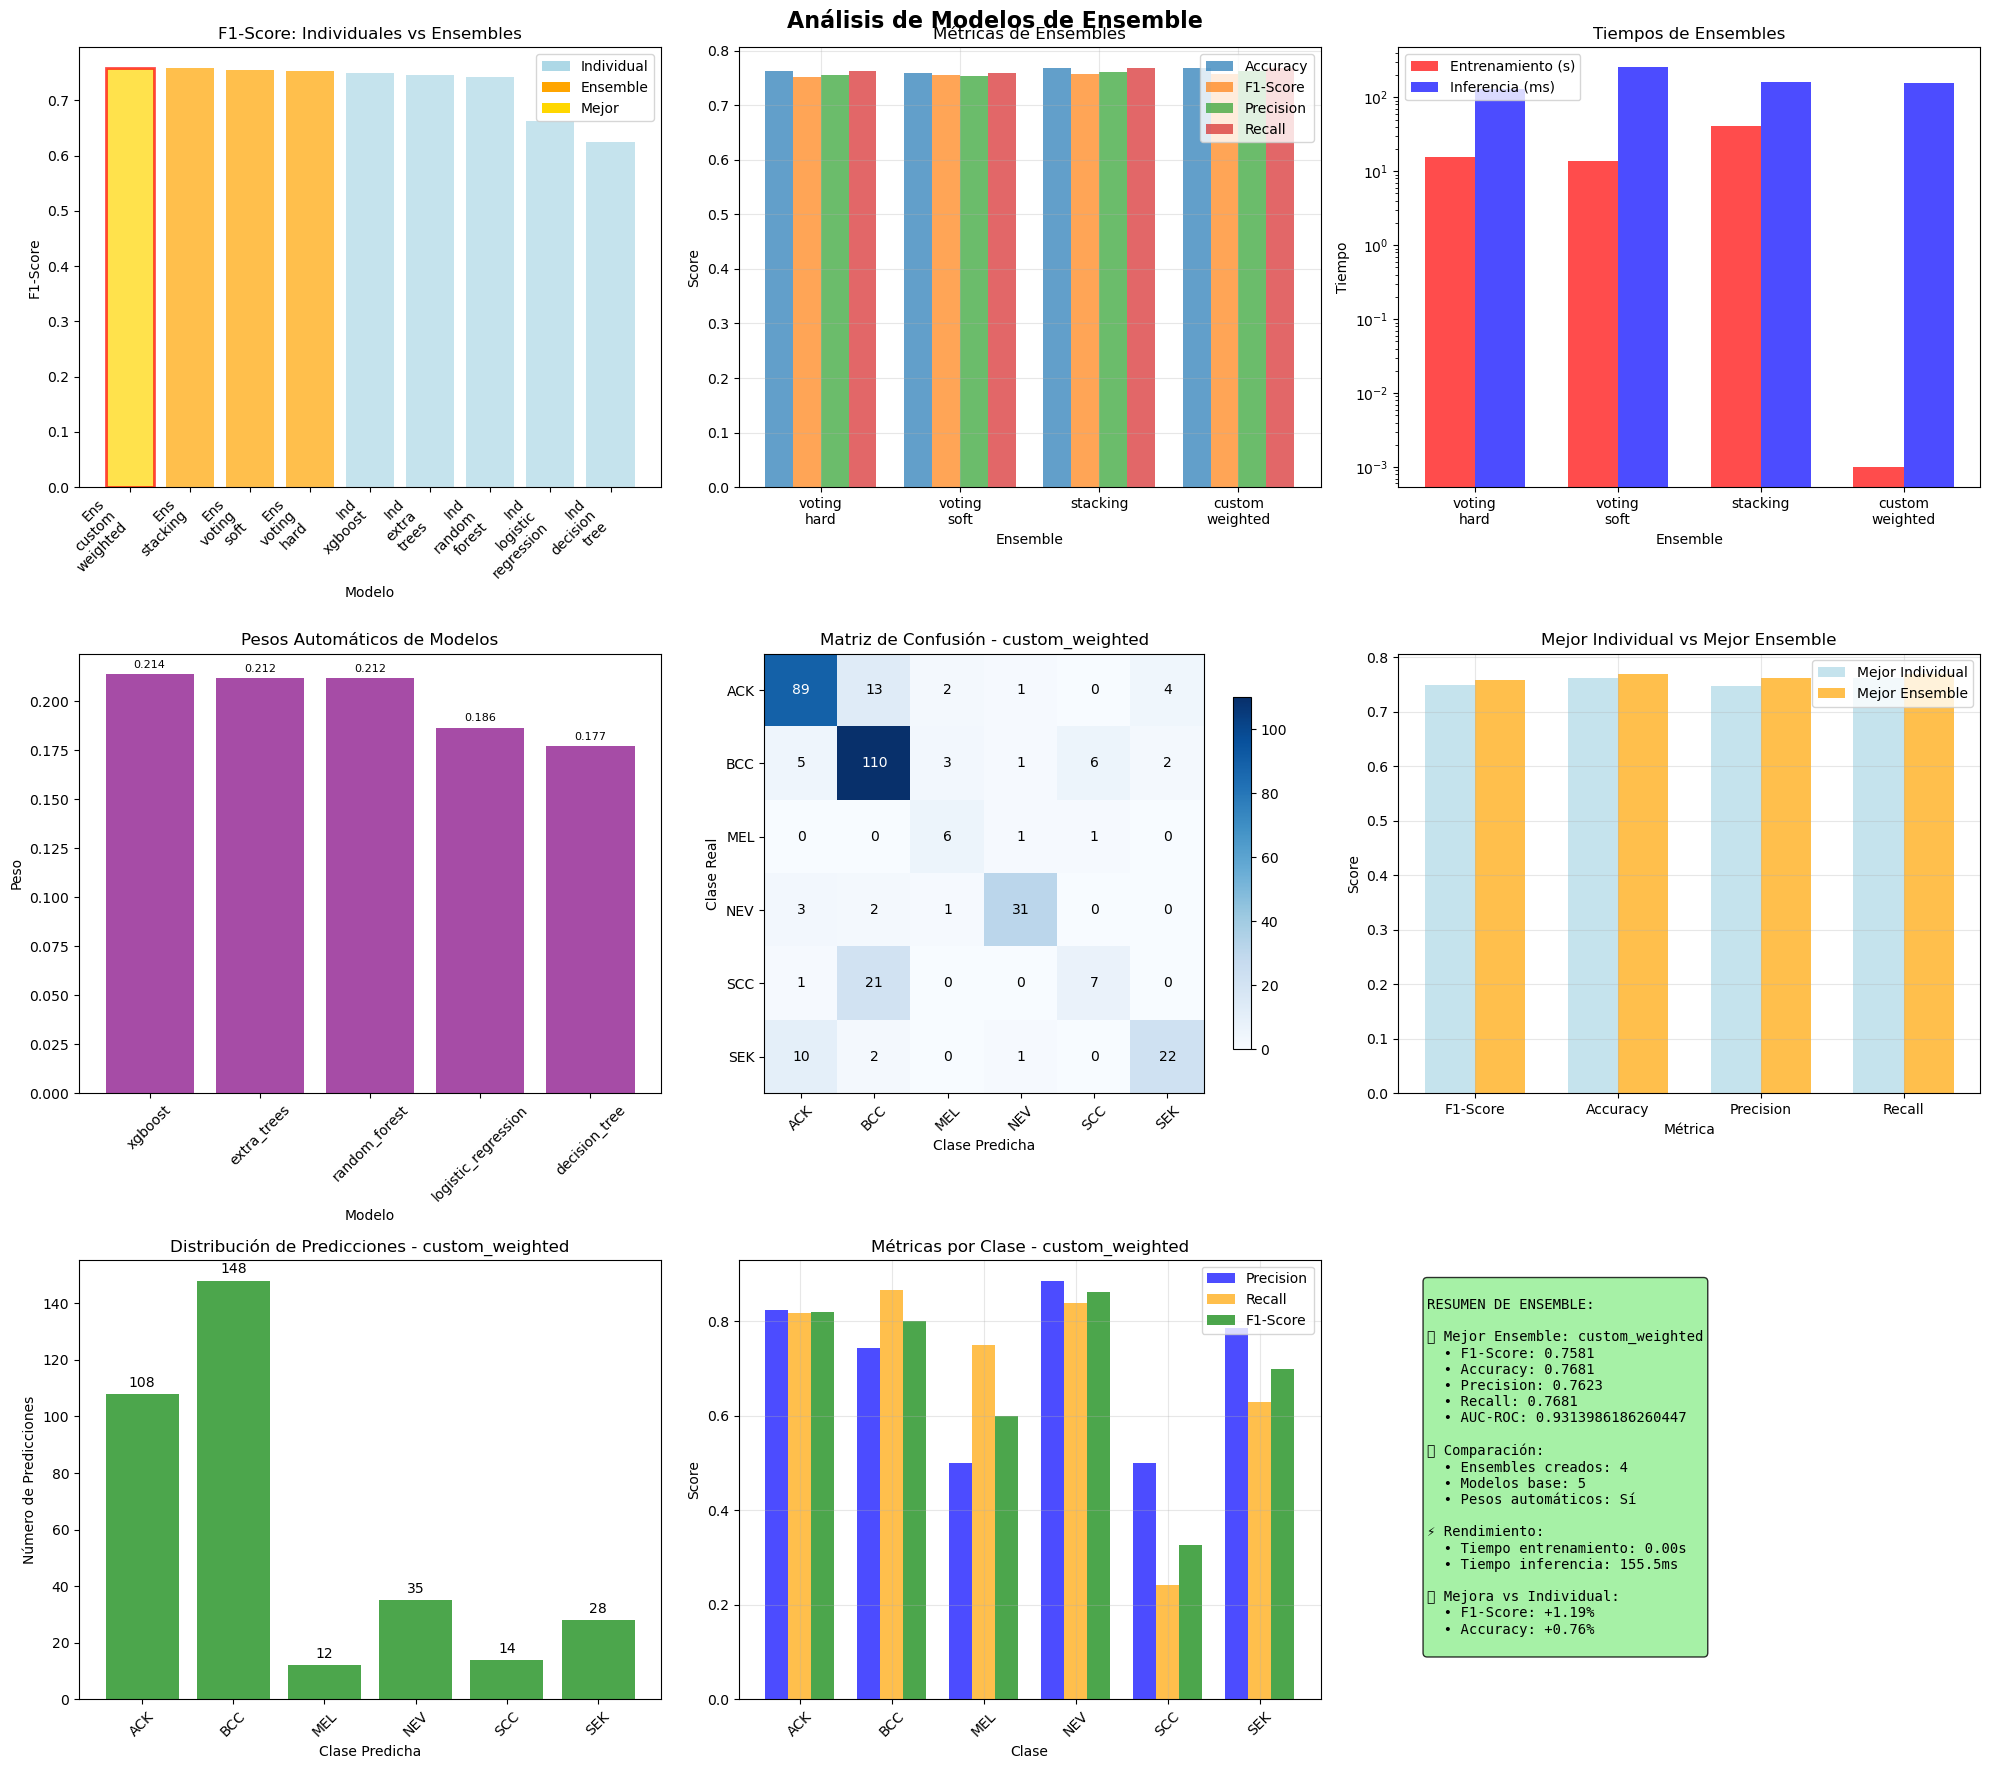


✓ Resultados de ensemble guardados en: ./output\ensemble_models_results.pkl
✓ Mejor ensemble guardado en: ./models\best_ensemble_custom_weighted.pkl

RESUMEN FINAL DEL ENSEMBLE

🏆 Mejor ensemble: custom_weighted
  F1-score: 0.7581
  Accuracy: 0.7681

📊 Comparación con mejor modelo individual:
  Modelo individual: xgboost
    F1-score: 0.7492
  Mejora del ensemble:
    F1-score: +1.19%
    Accuracy: +0.76%

✨ Proceso completado exitosamente ✨


In [11]:
# ===== EJECUCIÓN PRINCIPAL =====
if __name__ == "__main__":
    # Configuración del proyecto
    CONFIG = {
        'model_params': {
            'cv_folds': 5,
            'n_jobs': -1,
            'scoring_metric': 'f1_weighted',
            'hyperparameter_search': 'randomized',
            'n_iter_search': 10,
            'max_iter': 1000
        },
        'visualization': {
            'save_plots': True,
            'plot_format': 'png',
            'dpi': 300
        },
        'paths': {
            'plots_folder': './plots',
            'output_folder': './output',
            'models_folder': './models'
        },
        'ensemble_params': {
            'voting_types': ['hard', 'soft'],
            'auto_weights': True,
            'stacking_cv': 5,
            'stacking_final_estimator': 'logistic_regression'
        }
    }
    
    # Crear directorios si no existen
    for folder in CONFIG['paths'].values():
        os.makedirs(folder, exist_ok=True)
    
    # Cargar resultados de división de datos
    try:
        with open('./resultados/data_split_results.pkl', 'rb') as f:
            data_split_results = pickle.load(f)
        print("✓ Datos de división cargados exitosamente")
    except Exception as e:
        print(f"❌ Error cargando datos de división: {e}")
        raise
    
    # Cargar resultados de modelos individuales
    try:
        with open('./output/individual_models_results.pkl', 'rb') as f:
            individual_models_results = pickle.load(f)
        print("✓ Modelos individuales cargados exitosamente")
    except Exception as e:
        print(f"❌ Error cargando modelos individuales: {e}")
        raise
    
    # Ejecutar creación de ensembles
    ensemble_results = create_ensemble_models_advanced(individual_models_results, data_split_results, CONFIG)
    
    # Resumen final
    print("\n" + "="*60)
    print("RESUMEN FINAL DEL ENSEMBLE")
    print("="*60)
    
    if ensemble_results['best_ensemble_name']:
        best_ensemble = ensemble_results['best_ensemble_name']
        print(f"\n🏆 Mejor ensemble: {best_ensemble}")
        print(f"  F1-score: {ensemble_results['best_ensemble_results']['val_f1']:.4f}")
        print(f"  Accuracy: {ensemble_results['best_ensemble_results']['val_accuracy']:.4f}")
        
        # Comparación con mejor modelo individual
        print(f"\n📊 Comparación con mejor modelo individual:")
        print(f"  Modelo individual: {ensemble_results['comparison_with_individual']['best_individual_name']}")
        print(f"    F1-score: {ensemble_results['comparison_with_individual']['best_individual_f1']:.4f}")
        print(f"  Mejora del ensemble:")
        print(f"    F1-score: {ensemble_results['comparison_with_individual']['f1_improvement_percent']:+.2f}%")
        print(f"    Accuracy: {ensemble_results['comparison_with_individual']['accuracy_improvement_percent']:+.2f}%")
    else:
        print("\n❌ No se pudo crear ningún ensemble exitosamente")
    
    print("\n✨ Proceso completado exitosamente ✨")